<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
batch_size = 128 # 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader) # get some random training images
# images, labels = next(dataiter)
# print(images.shape) # [batch, 3, 32, 32]
# imshow(torchvision.utils.make_grid(images))


In [ ]:
# @title ResBlock
import torch
import torch.nn as nn

def zero_module(module):
    for p in module.parameters(): p.detach().zero_()
    return module

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3):
        super().__init__()
        out_ch = out_ch or in_ch
        act = nn.SiLU() #
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        # self.block = nn.Sequential( # best?
        #     nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), act,
        #     zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)), nn.BatchNorm2d(out_ch), act,
        #     )
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, kernel, padding=kernel//2),
            nn.BatchNorm2d(out_ch), act, zero_module(nn.Conv2d(out_ch, out_ch, kernel, padding=kernel//2)),
            )

    def forward(self, x): # [b,c,h,w]
        return self.block(x) + self.res_conv(x)


In [ ]:
# @title UpDownBlock_me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=1, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        out_ch = out_ch or in_ch
        if self.r>1: self.net = nn.Sequential(ResBlock(in_ch, out_ch*r**2, kernel), nn.PixelShuffle(r))
        # if self.r>1: self.net = nn.Sequential(Attention(in_ch, out_ch*r**2), nn.PixelShuffle(r))
# MaskUnitAttention(in_dim, d_model=16, n_heads=4, q_stride=None, nd=2)

        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), ResBlock(in_ch*r**2, out_ch, kernel))
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), Attention(in_ch*r**2, out_ch))
        elif in_ch != out_ch: self.net = ResBlock(in_ch*r**2, out_ch, kernel)
        else: self.net = lambda x: torch.zeros_like(x)

    def forward(self, x):
        return self.net(x)

def AdaptiveAvgPool_nd(n, *args, **kwargs): return [nn.Identity, nn.AdaptiveAvgPool1d, nn.AdaptiveAvgPool2d, nn.AdaptiveAvgPool3d][n](*args, **kwargs)
def AdaptiveMaxPool_nd(n, *args, **kwargs): return [nn.Identity, nn.AdaptiveMaxPool1d, nn.AdaptiveMaxPool2d, nn.AdaptiveMaxPool3d][n](*args, **kwargs)

def adaptive_avg_pool_nd(n, x, output_size): return [nn.Identity, F.adaptive_avg_pool1d, F.adaptive_avg_pool2d, F.adaptive_avg_pool3d][n](x, output_size)
def adaptive_max_pool_nd(n, x, output_size): return [nn.Identity, F.adaptive_max_pool1d, F.adaptive_max_pool2d, F.adaptive_max_pool3d][n](x, output_size)

class AdaptivePool_at(nn.AdaptiveAvgPool1d): # AdaptiveAvgPool1d AdaptiveMaxPool1d
    def __init__(self, dim=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dim=dim
    def forward(self, x):
        x = x.transpose(self.dim,-1)
        shape = x.shape
        return super().forward(x.flatten(0,-2)).unflatten(0, shape[:-1]).transpose(self.dim,-1)


def adaptive_pool_at(x, dim, output_size, pool='avg'): # [b,c,h,w]
    x = x.transpose(dim,-1)
    shape = x.shape
    parent={'avg':F.adaptive_avg_pool1d, 'max':F.adaptive_max_pool1d}[pool]
    return parent(x.flatten(0,-2), output_size).unflatten(0, shape[:-1]).transpose(dim,-1)


class ZeroExtend():
    def __init__(self, dim=1, output_size=16):
        self.dim, self.out = dim, output_size
    def __call__(self, x): # [b,c,h,w]
        return torch.cat((x, torch.zeros(*x.shape[:self.dim], self.out - x.shape[self.dim], *x.shape[self.dim+1:])), dim=self.dim)

def make_pool_at(pool='avg', dim=1, output_size=5):
    parent={'avg':nn.AdaptiveAvgPool1d, 'max':nn.AdaptiveMaxPool1d}[pool]
    class AdaptivePool_at(parent): # AdaptiveAvgPool1d AdaptiveMaxPool1d
        def __init__(self, dim=1, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.dim=dim
        def forward(self, x):
            x = x.transpose(self.dim,-1)
            shape = x.shape
            return super().forward(x.flatten(0,-2)).unflatten(0, shape[:-1]).transpose(self.dim,-1)
    return AdaptivePool_at(dim, output_size=output_size)

class Shortcut():
    def __init__(self, dim=1, c=3, sp=(3,3), nd=2):
        self.dim = dim
        # self.ch_pool = make_pool_at(pool='avg', dim=dim, output_size=c)
        self.ch_pool = make_pool_at(pool='max', dim=dim, output_size=c)
        # self.ch_pool = ZeroExtend(dim, output_size=c) # only for out_dim>=in_dim
        # self.sp_pool = AdaptiveAvgPool_nd(nd, sp)
        self.sp_pool = AdaptiveMaxPool_nd(nd, sp)

    def __call__(self, x): # [b,c,h,w]
        x = self.sp_pool(x) # spatial first preserves spatial more?
        x = self.ch_pool(x)
        return x

class UpDownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=7, r=1):
        super().__init__()
        act = nn.SiLU()
        self.r = r
        self.block = PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)
        # self.block = nn.Sequential(
        #     nn.BatchNorm2d(in_ch), act, PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)
        # )
        # if self.r>1: self.res_conv = nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, kernel, 2, kernel//2, output_padding=1))
        # if self.r>1: self.res_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(in_ch, out_ch, kernel, 1, kernel//2) if in_ch != out_ch else nn.Identity())
        # if self.r>1: self.res_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.Conv2d(in_ch, out_ch, kernel, 1, kernel//2) if in_ch != out_ch else nn.Identity())
        # if self.r>1: self.res_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), nn.Conv2d(in_ch, out_ch, kernel, 1, kernel//2) if in_ch != out_ch else nn.Identity())


        # elif self.r<1: self.res_conv = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel, 2, kernel//2))
        # elif self.r<1: self.res_conv = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel, 1, kernel//2) if in_ch != out_ch else nn.Identity(), nn.MaxPool2d(2,2))
        # elif self.r<1: self.res_conv = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel, 1, kernel//2) if in_ch != out_ch else nn.Identity(), nn.AvgPool2d(2,2))
        # elif self.r<1: self.res_conv = AttentionBlock(in_ch, out_ch, n_heads=4, q_stride=(2,2))

        # else: self.res_conv = nn.Conv2d(in_ch, out_ch, kernel, 1, kernel//2) if in_ch != out_ch else nn.Identity()

    def forward(self, x): # [b,c,h,w]
        b, num_tok, c, *win = x.shape
        x = x.flatten(0,1)
        out = self.block(x)
        # # shortcut = F.interpolate(x.unsqueeze(1), size=out.shape[1:], mode='nearest-exact').squeeze(1) # pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
        # shortcut = F.adaptive_avg_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        # # shortcut = F.adaptive_max_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        # # shortcut = F.adaptive_avg_pool3d(x, out.shape[1:]) if out.shape[1]>=x.shape[1] else F.adaptive_max_pool3d(x, out.shape[1:])
        # shortcut(x)
        shortcut = Shortcut(dim=1, c=out.shape[1], sp=out.shape[-2:], nd=2)(x)
        out = out + shortcut
        out = out.unflatten(0, (b, num_tok))
        return out

        # return out + shortcut + self.res_conv(x)
        # return out + self.res_conv(x)
        # return self.res_conv(x)

# if out>in, inter=max=ave=near.
# if out<in, inter=ave. max=max

# stride2
# interconv/convpool
# pixelconv
# pixeluib
# pixelres
# shortcut

# in_ch, out_ch = 16,3
in_ch, out_ch = 3,16
model = UpDownBlock(in_ch, out_ch, r=1/2).to(device)
# model = UpDownBlock(in_ch, out_ch, r=2).to(device)

x = torch.rand(12, in_ch, 64,64, device=device)
x = torch.rand(12, 2, in_ch, 64,64, device=device)
out = model(x)

print(out.shape)


torch.Size([12, 2, 16, 32, 32])


In [ ]:
# @title maxpool path bchw
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def conv_nd(n, *args, **kwargs): return [nn.Identity, nn.Conv1d, nn.Conv2d, nn.Conv3d][n](*args, **kwargs)
def maxpool_nd(n, *args, **kwargs): return [nn.Identity, nn.MaxPool1d, nn.MaxPool2d, nn.MaxPool3d][n](*args, **kwargs)
def avgpool_nd(n, *args, **kwargs): return [nn.Identity, nn.AvgPool1d, nn.AvgPool2d, nn.AvgPool3d][n](*args, **kwargs)
import math

class MaskUnitAttention(nn.Module):
    # def __init__(self, d_model=16, n_heads=4, q_stride=None, nd=2):
    def __init__(self, in_dim, d_model=16, n_heads=4, q_stride=None, nd=2):
        super().__init__()
        self.d_model = d_model
        self.n_heads, self.d_head = n_heads, d_model // n_heads
        self.scale = self.d_head**-.5
        # self.qkv = conv_nd(nd, d_model, 3*d_model, 1, bias=False)
        self.qkv = conv_nd(nd, in_dim, 3*d_model, 1, bias=False)
        # self.out = conv_nd(nd, d_model, d_model, 1)
        self.out = nn.Linear(d_model, d_model, 1)
        self.q_stride = q_stride # If greater than 1, pool q with this stride. The stride should be flattened (e.g., 2x2 = 4).
        if q_stride:
            self.q_stride = (q_stride,)*nd if type(q_stride)==int else q_stride
            self.q_pool = maxpool_nd(nd, self.q_stride, stride=self.q_stride)

    def forward(self, x): # [b,num_tok,c,win1,win2]
        b, num_tok, c, *win = x.shape
        # x = x.transpose(1,2).flatten(0,1) # [b*num_tok,c,win1,win2]
        x = x.flatten(0,1) # [b*num_tok,c,win1,win2]
        # print(x.shape)
        # q, k, v = self.qkv(x).reshape(b, 3, self.n_heads, self.d_head, num_tok, win*win).permute(1,0,2,4,5,3) # [b,3*d_model,num_tok*win,win] -> 3* [b, n_heads, num_tok, win*win, d_head]
        # self.qkv(x).flatten(1,-2).unflatten(-1, (self.heads,-1)).chunk(3, dim=-1) # [b,sp,n_heads,d_head]
        q,k,v = self.qkv(x).chunk(3, dim=1) # [b*num_tok,d,win,win]
        if self.q_stride:
            q = self.q_pool(q)
            win=[w//s for w,s in zip(win, self.q_stride)] # win = win/q_stride
        if math.prod(win) >= 200:
            print('MUattn', math.prod(win))
            q, k, v = map(lambda t: t.reshape(b*num_tok, self.n_heads, self.d_head, -1).transpose(-2,-1), (q,k,v)) # [b*num_tok, n_heads, win*win, d_head]
        else: q, k, v = map(lambda t: t.reshape(b, num_tok, self.n_heads, self.d_head, -1).permute(0,2,1,4,3).flatten(2,3), (q,k,v)) # [b, n_heads, num_tok*win*win, d_head]

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2) # [b, n_heads, t(/pool), d_head]
        context = k.transpose(-2,-1) @ v # [b, n_heads, d_head, d_head]
        x = q @ context # [b, n_heads, t(/pool), d_head]

        # print('attn fwd 2',x.shape)
        # x = x.transpose(1, 3).reshape(B, -1, self.d_model)
        x = x.transpose(1,2).reshape(b, -1, self.d_model) # [b,t,d]
        # x = x.transpose(-2,-1).reshape(x.shape[0], self.d_model, ) # [b,t,d]
        # [b, n_heads, num_tok, win*win, d_head] -> [b, n_heads, d_head, num_tok, win*win] -> [b,c,num_tok*win,win]
        # x = x.permute(0,1,4,2,3).reshape(b, self.d_model, num_tok*win,win) # [b, n_heads, num_tok, win*win, d_head]
        # x = x.transpose(-2,-1).reshape(b, self.d_model, num_tok, *win) # [b*num_tok, n_heads, win*win, d_head]
        x = self.out(x)
        L=len(win)
        x = x.reshape(b, num_tok, *win, self.d_model).permute(0,1,L+2,*range(2,L+2)) # [b, num_tok, out_dim, *win]
        # x = x.unflatten(0, (b, num_tok))
        return x # [b,num_tok,c,win1,win2]

d_model=16
model = MaskUnitAttention(d_model, n_heads=4, q_stride=2)
# MaskUnitAttention(d_model=16, n_heads=4, q_stride=None, nd=2)
# x=torch.randn(2,4,4,3)
# x=torch.randn(2,3,d_model,8,8)
x=torch.randn(2,3,d_model,32,32)
# [b*num_tok,c,win,win]

out = model(x)
print(out.shape)


MUattn 256
torch.Size([2, 3, 16, 16, 16])


In [ ]:
# @title hiera vit me
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class LayerNorm_at(nn.RMSNorm): # LayerNorm RMSNorm
    def __init__(self, dim=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dim=dim
    def forward(self, x):
        return super().forward(x.transpose(self.dim,-1)).transpose(self.dim,-1)

def unshuffle(x, window_shape): # [b,c,h,w] -> [b, h/win1* w/win2, c, win1,win2]
    new_shape = list(x.shape[:2]) + [val for xx, win in zip(list(x.shape[2:]), window_shape) for val in [xx//win, win]] # [h,w]->[h/win1, win1, w/win2, win2]
    x = x.reshape(new_shape) # [b, c, h/win1, win1, w/win2, win2]
    # print('unsh',x.shape, window_shape, new_shape)
    L = len(new_shape)
    permute = ([0] + list(range(2, L - 1, 2)) + [1] + list(range(3, L, 2))) # [0,2,4,1,3,5] / [0,2,4,6,1,3,5,6]
    return x.permute(permute).flatten(1, L//2-1) # [b, h/win1* w/win2, c, win1,win2]

class AttentionBlock(nn.Module):
    # def __init__(self, d_model, n_heads, q_stride=None, mult=4, drop=0, nd=2):
    def __init__(self, in_dim, d_model, n_heads, q_stride=None, mult=4, drop=0, nd=2):
        super().__init__()
        self.d_model = d_model
        # self.norm = LayerNorm_at(2, d_model) # LayerNorm RMSNorm
        self.norm = LayerNorm_at(2, in_dim) # LayerNorm RMSNorm
        self.drop = nn.Dropout(drop)
        # self.attn = MaskUnitAttention(d_model, n_heads, q_stride)
        self.attn = MaskUnitAttention(in_dim, d_model, n_heads, q_stride)
        ff_dim=d_model*mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), # ReLU GELU
            nn.RMSNorm(ff_dim), nn.Dropout(drop), nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), act, nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), nn.Dropout(dropout), # ReLU GELU
            # nn.Linear(ff_dim, d_model), nn.Dropout(dropout),
        )
        # self.res = conv_nd(nd, d_model, d_model, q_stride, q_stride) if q_stride else nn.Identity()

        # self.res = nn.Sequential(
        #     conv_nd(nd, in_dim, d_model, 1, 1) if in_dim!=d_model else nn.Identity(),
        #     # maxpool_nd(nd, q_stride, q_stride) if q_stride else nn.Identity(),
        #     avgpool_nd(nd, q_stride, q_stride) if q_stride else nn.Identity(),
        # )
        self.res = UpDownBlock(in_dim, d_model, kernel=1, r=1/2 if q_stride else 1)

        # x = self.proj(x_norm).unflatten(1, (self.attn.q_stride, -1)).max(dim=1).values # pooling res # [b, (Sy, Sx, h/Sy, w/Sx), c] -> [b, (Sy, Sx), (h/Sy, w/Sx), c] -> [b, (h/Sy, w/Sx), c]


    def forward(self, x): # [b, num_tok, c, *win]
        b, num_tok, c, *win = x.shape
        # print('attnblk fwd',x.shape)
        # x = x + self.drop(self.self(self.norm(x)))
        # print('attnblk fwd',self.res(x.flatten(0,1)).shape, self.drop(self.attn(self.norm(x))).flatten(0,1).shape)
        # x = self.res(x.flatten(0,1)) + self.drop(self.attn(self.norm(x))).flatten(0,1) # [b*num_tok,c,win1,win2,win3]
        x = self.res(x) + self.drop(self.attn(self.norm(x))) # [b*num_tok,c,win1,win2,win3]
        # x = x + self.ff(x)
        # x = x + self.ff(x.transpose(1,-1)).transpose(1,-1)
        x = x + self.ff(x.transpose(2,-1)).transpose(2,-1)
        # x = self.ff(x)
        # x = x.unflatten(0, (b, num_tok))
        return x

    # def forward(self, x): # [b,t,c] # [b, (Sy, Sx, h/Sy, w/Sx), c]
    #     # Attention + Q Pooling
    #     x_norm = self.norm1(x)
    #     if self.dim != self.dim_out:
    #         x = self.proj(x_norm).unflatten(1, (self.attn.q_stride, -1)).max(dim=1).values # pooling res # [b, (Sy, Sx, h/Sy, w/Sx), c] -> [b, (Sy, Sx), (h/Sy, w/Sx), c] -> [b, (h/Sy, w/Sx), c]
    #     x = x + self.drop_path(self.attn(x_norm))
    #     x = x + self.drop_path(self.mlp(self.norm2(x)))
    #     return x


class levelBlock(nn.Module):
    def __init__(self, in_dim, out_dim, n_heads=None, depth=1, r=1):
        super().__init__()
        self.seq = nn.Sequential(
            UpDownBlock(in_ch, out_ch, r=min(1,r)) if in_ch != out_ch or r<1 else nn.Identity(),
            # AttentionBlock(d_model, d_model, n_heads, q_stride) if in_ch != out_ch or r<1 else nn.Identity(),
            # AttentionBlock(d_model, d_model, n_heads, q_stride=(2,2)),
            *[AttentionBlock(d_model, d_model, n_heads) for i in range(1)],
            # UpDownBlock(out_ch, out_ch, r=r) if r>1 else nn.Identity(),
        )
    def forward(self, x):
        return self.seq(x)

class SimpleViT(nn.Module):
    def __init__(self, in_dim, out_dim, d_model, n_heads, depth):
        super().__init__()
        self.embed = nn.Sequential( # in, out, kernel, stride, pad
            # nn.Conv2d(in_dim, d_model, 7, 2, 7//2, bias=False), nn.MaxPool2d(3,2,1), # nn.MaxPool2d(2,2)
            nn.Conv2d(in_dim, d_model, 7, 1, 7//2, bias=False),
            # UpDownBlock(in_dim, dim, r=1/2, kernel=3), UpDownBlock(dim, dim, r=1/2, kernel=3)
            # nn.PixelUnshuffle(2), nn.Conv2d(in_dim*2**2, dim, 1, bias=False),
            # ResBlock(in_dim, d_model, kernel),
            )
        # # self.pos_emb = LearnedRoPE2D(dim) # LearnedRoPE2D, RoPE2D
        # self.pos_emb = nn.Parameter(torch.zeros(1, d_model, 32,32)) # positional_embedding == 'learnable'

        emb_shape = (32,32)
        # emb_shape = (8,32,32)
        if len(emb_shape) == 3: # for video
            pos_spatial = nn.Parameter(torch.randn(1, emb_shape[1]*emb_shape[2], d_model)*.02)
            pos_temporal = nn.Parameter(torch.randn(1, emb_shape[0], d_model)*.02)
            self.pos_emb = pos_spatial.repeat(1, emb_shape[0], 1) + torch.repeat_interleave(pos_temporal, emb_shape[1] * emb_shape[2], dim=1)
        elif len(emb_shape) == 2: # for img
            self.pos_emb = nn.Parameter(torch.randn(1, math.prod(emb_shape), d_model)*.02) # 56*56=3136


        # self.blocks = nn.Sequential(*[AttentionBlock(d_model, n_heads, q_stride=(2,2) if i in [1,3] else None) for i in range(depth)])
        # mult = [1,1,1,1]
        mult = [1,2,4,8] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult] # [128, 256, 384, 512]

        self.blocks = nn.Sequential(
            # AttentionBlock(ch_list[0], ch_list[1], n_heads, q_stride=(2,2)),
            # UpDownBlock(ch_list[0], ch_list[1], kernel=1, r=1/2),
            UpDownBlock(ch_list[0], ch_list[1], kernel=4, r=1/2),
            AttentionBlock(ch_list[1], ch_list[1], n_heads),
            # AttentionBlock(ch_list[1], ch_list[2], n_heads, q_stride=(2,2)),
            # UpDownBlock(ch_list[1], ch_list[2], kernel=1, r=1/2),
            UpDownBlock(ch_list[1], ch_list[2], kernel=2, r=1/2),
            AttentionBlock(ch_list[2], ch_list[2], n_heads),
            )
        self.attn_pool = nn.Linear(ch_list[2], 1)
        self.out = nn.Linear(ch_list[2], out_dim, bias=False)

    def forward(self, img): # [b,c,h,w]
        x = self.embed(img)
        # print('vit fwd', x.shape)
        x = x + self.pos_emb
        x = unshuffle(x, (4,4)) # [b,num_tok,c,win1,win2,win3] or [b,1,c,f,h,w]
        # mask # [b, num_tok]
        # x=x[:,:7]
        # print('vit fwd1', x.shape)

        x = self.blocks(x) # [b,num_tok,c,1,1,1]
        # print('vit fwd2', x.shape)
        x = x.squeeze() # [b,num_tok,d]
        attn = self.attn_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn.softmax(dim=1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim] -> [batch, dim]
        return self.out(x)


# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

# norm,act,conv < conv,norm,act
# 2*s1 < uib < resblock
# gatedadaln 3 < 2 = 1 < ffmult4 = 2*gatedadaln
# MaxPool2d(2,2) < MaxPool2d(3,2,3//2)

# patchattn only for

# multiendfusion negligible diff

d_model = 64
dim_head = 8
heads = d_model // dim_head
num_classes = 10
# model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
model = SimpleViT(in_dim=3, out_dim=num_classes, d_model=d_model, depth=5, n_heads=heads).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

# print(images.shape) # [batch, 3, 32, 32]
x = torch.rand(25, 3, 32, 32, device=device)
# x = torch.rand(64, 3, 28,28, device=device)
logits = model(x)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")



In [ ]:
# @title Gated Linear Unit
import torch
import torch.nn as nn
import torch.nn.functional as F

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class GLU(nn.Module): # https://arxiv.org/pdf/2002.05202
    def __init__(self, in_dim, d_model):
        super().__init__()
        self.lin0 = nn.Sequential(
            nn.SiLU(), zero_module(nn.Linear(in_dim, 2*d_model))
            nn.LayerNorm(in_dim), nn.SiLU(), zero_module(nn.Linear(in_dim, 2*d_model, bias=False))
            nn.LayerNorm(in_dim), zero_module(nn.Linear(in_dim, 2*d_model, bias=False))
            zero_module(nn.Linear(in_dim, 2*d_model, bias=False))
        )
        self.lin1 = nn.Sequential(
            nn.SiLU(), zero_module(nn.Linear(d_model, in_dim))
            zero_module(nn.Linear(d_model, in_dim, bias=False))
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x): # [b,t,d]
        x0, x1 = self.lin0(x).chunk(2, dim=-1)
        x = x + x0 * self.norm(x) + x1 # AdaLN
        # x0, x1, x2 = self.lin0(x).chunk(3, dim=-1)
        # x = x + x0 * x1 # Bilinear
        # x = x + x0 * x1 + x2
        # x = x + x0.exp() * x1 + x2

        # x = self.lin1(x0*F.sigmoid(x1)) # GLU
        # x = self.lin1(x0*F.gelu(x1)) # GEGLU
        # x = self.lin1(x0*F.silu(x1)) # SwiGLU
        # x = self.lin1(x0*F.relu(x1)) # ReGLU
        # x = self.lin1(x0*x1.exp()) #
        # x = self.lin1(x0*x1) # Bilinear
        return x



class SwiGLU(nn.Module): # https://arxiv.org/pdf/2002.05202
    def __init__(self, in_dim, d_model):
        super().__init__()
        self.lin0 = zero_module(nn.Linear(in_dim, 2*d_model, bias=False))
        self.lin1 = zero_module(nn.Linear(d_model, in_dim, bias=False))

    def forward(self, x): # [b,t,d]
        x0, x1 = self.lin0(x).chunk(2, dim=-1)
        return self.lin1(x0*F.silu(x1)) # SwiGLU


class AGeLU(nn.Module): # https://openreview.net/pdf?id=I8pdQLfR77
    def __init__(self):
        super().__init__()
        self.act = nn.GELU() # GELU SiLU
        self.coef = nn.Parameter(torch.randn(4))

    def forward(self, x): # [b,t,d]
        return self.coef[0] * self.act(self.coef[1] * x + self.coef[2]) + self.coef[3]


class AMLP(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.lin0 = nn.Sequential(
            nn.SiLU(), nn.Linear(d_model, 2*d_model)
        )
        self.lin1 = nn.Sequential(
            zero_module(nn.Linear(2*d_model, d_model))
        )
        self.act = nn.GELU() # GELU SiLU
        self.agelu0, self.agelu1 = AGeLU(), AGeLU()

    def forward(self, x): # [b,t,d]
        x0, x1 = self.lin0(x).chunk(2, dim=-1) # for btd
        x = torch.cat([self.agelu0(x0), self.agelu1(x1)], dim=-1)
        return self.lin1(x)

dim = 64
# model = GLU(dim, int(3.5*dim))
model = AMLP(dim)

x = torch.randn(2, dim)
out = model(x)
print(out.shape)  # Should be (32, 64)


In [ ]:
# @title ViT me more
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class SelfAttn(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.dim, self.heads = dim, n_heads
        d_head = dim//n_heads
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        # self.lin = nn.Linear(dim, dim)
        self.lin = zero_module(nn.Linear(dim, dim))
        # self.rope = RoPE(d_head, seq_len=512, base=10000)
        # # self.rope = RoPE2D(d_head, h=64, w=64, base=100)
        self.scale = d_head**-.5

    def forward(self, x): # [b,t,d]
        # print('satt',x.shape)
        q,k,v = self.qkv(x).unflatten(-1, (self.heads,-1)).transpose(-3,-2).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, n_heads, d_head]?
        # q, k = self.rope(q), self.rope(k)

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [batch, n_heads, T/num_tok, d_head]

        # print('satt',x.shape)
        x = x.transpose(1,2).flatten(2)
        # print('satt',x.shape)
        return self.lin(x)


class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, drop=0):
        super().__init__()
        self.d_model = d_model
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.drop = nn.Dropout(drop)
        self.attn = SelfAttn(d_model, n_heads) # 16448
        # self.attn = GLAblock(hidden_size=d_model, expand_k=1, expand_v=1, num_heads=n_heads)
        # self.self = Pooling()
        # act = nn.GELU() # ReLU GELU
        # self.ff = nn.Sequential(
        #     *[nn.BatchNorm2d(d_model), act, SeparableConv2d(d_model, d_model),]*3
        #     )
        # self.ff = ResBlock(d_model) # 74112
        # self.ff = UIB(d_model, mult=4) # uib m4 36992, m2 18944
        self.ff = GLU(d_model, int(2*d_model)) # 3.5
        ff_dim=d_model*4#mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), # ReLU GELU
            nn.RMSNorm(ff_dim), nn.Dropout(drop), nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), act, nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), nn.Dropout(dropout), # ReLU GELU
            # nn.Linear(ff_dim, d_model), nn.Dropout(dropout),
        )

    def forward(self, x, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        bchw = x.shape
        x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        # print('attnblk fwd',x.shape)

        x = x + self.drop(self.attn(self.norm(x)))
        x = x + self.ff(x)
        x = x.transpose(1,2).reshape(*bchw)
        # x = self.ff(x)
        # x = x + self.drop(self.norm2(self.ff(x)))
        return x


class SimpleViT(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, n_heads=4, nlyrs=1):
        super().__init__()
        self.embed = nn.Sequential( # in, out, kernel, stride, pad
            nn.Conv2d(in_dim, d_model, 7, 2, 7//2, bias=False), nn.MaxPool2d(3,2,1), # nn.MaxPool2d(2,2)
            # nn.Conv2d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            # nn.Conv2d(d_model, d_model,3,2,3//2),
            # UpDownBlock(in_dim, d_model, r=1/2, kernel=3), UpDownBlock(d_model, d_model, r=1/2, kernel=3)
            # nn.PixelUnshuffle(2), nn.Conv2d(in_dim*2**2, d_model, 1, bias=False),
            )
        # self.pos_emb = LearnedRoPE2D(dim) # LearnedRoPE2D, RoPE2D
        self.pos_emb = nn.Parameter(torch.zeros(1, dim, 8,8)) # positional_embedding == 'learnable'
        # self.transformer = nn.Sequential(*[AttentionBlock(dim, n_heads) for _ in range(nlyrs)])
        self.transformer = nn.ModuleList([AttentionBlock(dim, n_heads) for i in range(2)])

        self.attn_pool = nn.Linear(d_model, 1)
        self.out = nn.Linear(d_model, out_dim or d_model, bias=False)

    def forward(self, img, mask=None):
        # device = img.device
        x = self.embed(img)
        # x = self.pos_emb(x)
        bchw = x.shape
        x = x + self.pos_emb
        # for blk in self.transformer: x = blk(x)
        # x = self.transformer(x)
        x = self.transformer[0](x) + self.transformer[1](x)
        x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        attn = self.attn_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn.softmax(dim=1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim] -> [batch, dim]
        return self.out(x)


# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

# norm,act,conv < conv,norm,act
# 2*s1 < uib < resblock
# gatedadaln 3 < 2 = 1 < ffmult4 = 2*gatedadaln
# MaxPool2d(2,2) < MaxPool2d(3,2,3//2)

# 32^2->8^2=64

# fla 4lyr 234449params 22.56sec
# selfattn 4lyr 213889

dim = 64#64
in_dim=3
out_dim = 10
# model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
model = SimpleViT(in_dim, 64, out_dim, nlyrs=1, n_heads=4).to(device)
model = SimpleViT(in_dim, 32, out_dim, nlyrs=1, n_heads=2).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
print(sum(p.numel() for p in model.transformer[0].attn.parameters() if p.requires_grad)) # 59850
print(sum(p.numel() for p in model.transformer[0].ff.parameters() if p.requires_grad)) # 59850
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

# print(images.shape) # [batch, 3, 32, 32]
x = torch.rand(24, 3, 32,32, device=device)
# x = torch.rand(64, 3, 28,28, device=device)
logits = model(x)
print(logits.shape)



213889
torch.Size([24, 10])


In [ ]:
print(sum(p.numel() for p in model.transformer_blocks[0].self.parameters() if p.requires_grad)) # 59850
print(sum(p.numel() for p in model.transformer_blocks[0].ff.parameters() if p.requires_grad)) # 59850


16448
18944


In [ ]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="vit", config={"model": "res18",})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# @title train test function

def train(dataloader, model, loss_fn, optim):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        pred = model(sx)
        loss = loss_fn(pred, sy)
        optim.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optim.step() # adjust the parameters by the gradients
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            # loss_list.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        try: wandb.log({"loss": loss.item()})
        except: pass

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for X, y in dataloader:
        x, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
        # loss = loss_fn(pred, y)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

import time
start = time.time()
loss_fn = nn.CrossEntropyLoss()

for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optim)
    test(test_loader, model, loss_fn)
    print('time:',time.time() - start, (time.time()-start)/(t+1))
    end = time.time()
print("Done!")

end = time.time()
print("time: ",end - start)

torch.save(model.state_dict(), "model.pth")


Epoch 1
-------------------------------
loss: 2.355891  [    0/50000]
loss: 2.305916  [ 4992/50000]
loss: 2.321788  [ 9984/50000]
loss: 2.261930  [14976/50000]
loss: 2.274566  [19968/50000]
loss: 2.172393  [24960/50000]
loss: 2.116346  [29952/50000]
loss: 2.008737  [34944/50000]
loss: 1.983347  [39936/50000]
loss: 2.011741  [44928/50000]
Test Error: 
 Accuracy: 25.5%, Avg loss: 1.959480 

time: 16.358219861984253 16.35822081565857
Epoch 2
-------------------------------
loss: 2.155640  [    0/50000]
loss: 1.917851  [ 4992/50000]
loss: 2.031436  [ 9984/50000]
loss: 1.979323  [14976/50000]
loss: 1.898517  [19968/50000]
loss: 2.331604  [24960/50000]
loss: 2.288532  [29952/50000]
loss: 2.258516  [34944/50000]
loss: 2.237510  [39936/50000]
loss: 2.207013  [44928/50000]
Test Error: 
 Accuracy: 18.3%, Avg loss: 2.200488 

time: 31.57065463066101 15.785327672958374
Epoch 3
-------------------------------
loss: 2.222084  [    0/50000]
loss: 2.162521  [ 4992/50000]
loss: 2.242355  [ 9984/50000]


KeyboardInterrupt: 

In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'

modelsd, optimsd = torch.load(folder+'vit.pkl', map_location=device).values()
model.load_state_dict(modelsd, strict=False)
optim.load_state_dict(optimsd)

In [ ]:
checkpoint = {'model': model.state_dict(), 'optimizer': optim.state_dict()}
# torch.save(checkpoint, folder+'vit.pkl')
torch.save(checkpoint, 'cct.pkl')

## drawer

In [ ]:
# @title Shortcut
import torch
import torch.nn as nn

def make_pool_at(pool='avg', dim=1, output_size=5):
    parent={'avg':nn.AdaptiveAvgPool1d, 'max':nn.AdaptiveMaxPool1d}[pool]
    class AdaptivePool_at(parent): # AdaptiveAvgPool1d AdaptiveMaxPool1d
        def __init__(self, dim=1, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.dim=dim
        def forward(self, x):
            x = x.transpose(self.dim,-1)
            shape = x.shape
            return super().forward(x.flatten(0,-2)).unflatten(0, shape[:-1]).transpose(self.dim,-1)
    return AdaptivePool_at(dim, output_size=output_size)


# class Shortcut(nn.Module):
class Shortcut():
    def __init__(self, dim=1, c=3, sp=(3,3), nd=2):
        # super().__init__()
        self.dim = dim
        self.ch_pool = make_pool_at(pool='avg', dim=dim, output_size=c)
        self.ch_pool = make_pool_at(pool='max', dim=dim, output_size=c)
        # self.ch_pool = ZeroExtend(dim, output_size=c) # only for out_dim>=in_dim
        self.sp_pool = AdaptiveAvgPool_nd(nd, sp)
        # self.sp_pool = AdaptiveMaxPool_nd(nd, sp)

    # def forward(self, x): # [b,c,h,w]
    def __call__(self, x): # [b,c,h,w]
        x = self.ch_pool(x)
        print('aft ch',x)
        x = self.sp_pool(x)
        return x

class Shortcut2(Shortcut):
    def __init__(self, dim=1, c=5, sp=(4,4), nd=2):
        super().__init__()
    def __call__(self, x): # [b,c,h,w]
        x = self.sp_pool(x)
        print('aft sp',x)
        x = self.ch_pool(x)
        return x


# mmT identical, close to AdaptiveAvgPool3d
# maF diff; down is identical # max can copy adjacent channels
# aaF close
# amFF diff

# shortcut = F.interpolate(x.unsqueeze(1), size=out.shape[1:], mode='nearest-exact').squeeze(1) # pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
# shortcut = F.adaptive_avg_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
# shortcut = F.adaptive_max_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
# pool3 = nn.AdaptiveAvgPool3d((3,3,3))

pool1 = Shortcut()
pool2 = Shortcut2()
x0 = torch.rand(1, 2, 4,4)
x1 = torch.rand(1, 2, 2,2)
x2 = torch.rand(1, 4, 4,4)
x3 = torch.rand(1, 4, 2,2)
print(x2)
# for x in [x0,x1,x2,x3]:
for x in [x2]:
    out1 = pool1(x)
    out2 = pool2(x)
    # out3 = pool3(x)
    # # print(out.shape)
    # print((out1==out2).all())
    print(out1-out2)

# print(out1)
# print(out2)
# print(out3)
print(out1-out2)
print(out1-out3)
print(out2-out3)


In [ ]:
# @title maxpool path bchw
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, Mlp
device = "cuda" if torch.cuda.is_available() else "cpu"

def conv_nd(n, *args, **kwargs): return [nn.Identity, nn.Conv1d, nn.Conv2d, nn.Conv3d][n](*args, **kwargs)
def maxpool_nd(n, *args, **kwargs): return [nn.Identity, nn.MaxPool1d, nn.MaxPool2d, nn.MaxPool3d][n](*args, **kwargs)

class MaskUnitAttention(nn.Module):
    def __init__(self, d_model=16, n_heads=4, q_stride=None):
        super().__init__()
        self.d_model = d_model
        self.n_heads, self.d_head = n_heads, d_model // n_heads
        self.scale = self.d_head**-.5
        nd = 2
        self.qkv = conv_nd(nd, d_model, 3*d_model, 1)
        self.out = conv_nd(nd, d_model, d_model, 1)
        self.q_stride = q_stride # If greater than 1, pool q with this stride. The stride should be flattened (e.g., 2x2 = 4).
        if q_stride:
            self.q_stride = (q_stride,)*nd if type(q_stride)==int else q_stride
            self.q_pool = maxpool_nd(nd, self.q_stride, stride=self.q_stride)

    def forward(self, x): # [b,c,num_tok,win1,win2,win3] [b,num_tok,c,win1,win2,win3]
        b, num_tok, c, *win = x.shape
        # x = x.transpose(1,2).flatten(0,1) # [b*num_tok,c,win1,win2,win3]
        x = x.flatten(0,1) # [b*num_tok,c,win1,win2,win3]
        print(x.shape)
        # q, k, v = self.qkv(x).reshape(b, 3, self.n_heads, self.d_head, num_tok, win*win).permute(1,0,2,4,5,3) # [b,3*d_model,num_tok*win,win] -> 3* [b, n_heads, num_tok, win*win, d_head]
        # self.qkv(x).flatten(1,-2).unflatten(-1, (self.heads,-1)).chunk(3, dim=-1) # [b,sp,n_heads,d_head]
        q,k,v = self.qkv(x).chunk(3, dim=1) # [b,d,num_tok*win,win]
        if self.q_stride:
            q = self.q_pool(q)
            win=[w//s for w,s in zip(win, self.q_stride)] # win = win//self.q_stride
        # q, k, v = map(lambda t: t.reshape(b, self.n_heads, self.d_head, num_tok, -1).permute(0,1,3,4,2), (q,k,v)) # [b,d,num_tok*win(/pool),win(/pool)] -> [b, n_heads, num_tok, win*win, d_head]
        q, k, v = map(lambda t: t.reshape(b*num_tok, self.n_heads, self.d_head, -1).transpose(-2,-1), (q,k,v)) # [b,d,num_tok*win(/pool),win(/pool)] -> [b, n_heads, num_tok, win*win, d_head]

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2) # [b, n_heads, t(/pool), d_head]
        context = k.transpose(-2,-1) @ v # [b, n_heads, d_head, d_head]
        x = q @ context # [b, n_heads, t(/pool), d_head]

        # # x = F.scaled_dot_product_attention(q, k, v)
        # attn = (q * self.scale) @ k.transpose(-2,-1) # [b, n_heads, num_windows, window_size, d_head] @ [b, n_heads, num_windows, d_head, q_stride*window_size] = [b, n_heads, num_windows, window_size, q_stride*window_size]
        # x = attn.softmax(dim=-1) @ v # [b, n_heads, num_windows, window_size, d_head]
        print('attn fwd 2',x.shape)
        # x = x.transpose(1, 3).reshape(B, -1, self.d_model)
        # x = x.transpose(1, 2).reshape(x.shape[0], -1, self.d_model) # [b,t,d]
        # x = x.transpose(-2,-1).reshape(x.shape[0], self.d_model, ) # [b,t,d]
        # [b, n_heads, num_tok, win*win, d_head] -> [b, n_heads, d_head, num_tok, win*win] -> [b,c,num_tok*win,win]
        # x = x.permute(0,1,4,2,3).reshape(b, self.d_model, num_tok*win,win) # [b, n_heads, num_tok, win*win, d_head]
        x = x.transpose(-2,-1).reshape(b*num_tok, self.d_model, *win) # [b*num_tok, n_heads, win*win, d_head]
        x = self.out(x)
        x = x.unflatten(0, (b, num_tok))
        return x

d_model=16
model = MaskUnitAttention(d_model, n_heads=4, q_stride=2)
# x=torch.randn(2,4,4,3)
x=torch.randn(2,3,d_model,8,8)
# [b*num_tok,c,win,win]

out = model(x)
print(out.shape)


torch.Size([6, 16, 8, 8])
attn fwd 2 torch.Size([6, 4, 16, 4])
torch.Size([2, 3, 16, 4, 4])


In [ ]:
# @title facebookresearch hiera_utils.py
# https://github.com/facebookresearch/hiera/blob/main/hiera/hiera_utils.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_nd(n, *args, **kwargs): return [nn.Identity, nn.Conv1d, nn.Conv2d, nn.Conv3d][n](*args, **kwargs)

# [B, (H, W), C] -> [B, (Sy, Sx, H // Sy, W // Sx), C]; stride (Sy, Sx)
def Unroll(x, tokens_spatial_shape, unroll_schedule): # [56, 56] [(2, 2), (2, 2), (2, 2)]
    B, _, C = shape = x.shape
    x = x.view(B, *tokens_spatial_shape, C)
    # print('unroll', x.shape, tokens_spatial_shape, unroll_schedule)
    for strides in unroll_schedule: # q_stride (2, 2)
        tokens_spatial_shape = [i//s for i, s in zip(tokens_spatial_shape, strides)] # [28, 28], [14, 14], [7, 7]
        new_shape = [B] + [val for tup in zip(tokens_spatial_shape, strides) for val in tup] + [C]
        x = x.view(new_shape) # 2d: [B, H/Sy, Sy, W/Sx, Sx, C] # [24, 28, 2, 28, 2, 16], [96, 14, 2, 14, 2, 16], [384, 7, 2, 7, 2, 16]
        L = len(new_shape)
        permute = ([0] + list(range(2, L - 1, 2)) + list(range(1, L - 1, 2)) + [L - 1]) # [0, 2, 4, 1, 3, 5] / [0, 2, 4, 6, 1, 3, 5, 7]
        x = x.permute(permute).flatten(0, len(strides)) # 2d: [B, Sy, Sx, H/Sy, W/Sx, C] -> [B*Sy*Sx, H/Sy, W/Sx, C]
        B *= math.prod(strides)
    # print('unroll out', x.shape)
    x = x.reshape(*shape) # 2d: [B*Sy*Sx, H/Sy* W/Sx, C] # [24, 3136, 16]
    return x # then x.max(1) == MaxPoolNd



# stages=(2, 2, 3, 2)
# input_size = (224, 224)
# q_stride = (2, 2)
# patch_stride = (4, 4)

# x = torch.rand(24, 16, 56, 56)
# x = x.flatten(2).transpose(1, 2) # [b,t,c]
# stage_ends = [sum(stages[:i]) - 1 for i in range(1, len(stages) + 1)]
# tokens_spatial_shape = [i//s for i, s in zip(input_size, patch_stride)] # list [224/4, 224/4] = [56, 56]
# x = Unroll(x, tokens_spatial_shape, [q_stride]*len(stage_ends[:-1]))
# print(x.shape)
# print(x)


# [24, 49, 8, 8, 16] [56, 56] [8, 8] -> [24, 56, 56, 16]
# [24, 49, 4, 4, 32] [28, 28] [4, 4] -> [24, 28, 28, 16]
# [24, 49, 2, 2, 64] [14, 14] [2, 2] -> [24, 14, 14, 16]
# [24, 49, 1, 1, 128] [7, 7] [1, 1] -> [24, 7, 7, 16]
# [B, #MUy*#MUx, MUy, MUx, C] -> [B, #MUy*MUy, #MUx*MUx, C]
def undo_windowing(x, shape, mu_shape): # x [B, #MUy*#MUx, MUy, MUx, C] # shape: desired spatial shape. 2d: [B, #MUy*MUy, #MUx*MUx, C] # mu_shape: current mask unit shape. 2d: [MUy, MUx]
    # print("undo_windowing", x.shape, shape, mu_shape)
    B, C = x.shape[0], x.shape[-1]
    num_MUs = [s//mu for s, mu in zip(shape, mu_shape)] # [7,7]
    x = x.view(B, *num_MUs, *mu_shape, C) # [B, #MUy*#MUx, MUy, MUx, C] -> [B, #MUy, #MUx, MUy, MUx, C]
    D = len(shape)
    # permute = ([0] + sum([list(p) for p in zip(range(1, 1 + D), range(1 + D, 1 + 2 * D))], []) + [len(x.shape) - 1]) # [0, 1, 3, 2, 4, 5]
    permute = ([0] + [val for tup in zip(range(1, 1+D), range(1+D, 1+2*D)) for val in tup] + [len(x.shape)-1]) # [0, 1, 3, 2, 4, 5] / [0, 1, 4, 2, 5, 3, 6, 7]
    x = x.permute(permute).reshape(B, *shape, C) # [B, #MUy, #MUx, MUy, MUx, C] -> [B, #MUy*MUy, #MUx*MUx, C]
    return x # [B, #MUy*MUy, #MUx*MUx, C]

# ss=2 # 8 4 2 1
# x = torch.rand(24, 49, 2**ss,2**ss, 16)
# shape, mu_shape = [7*2**ss, 7*2**ss], [2**ss, 2**ss]
# o = undo_windowing(x, shape, mu_shape)
# print(o.shape) # [24, 56, 56, 16]

# [q_stride] * len(self.stage_ends[:-1]), self.stage_ends, q_pool

def Reroll(x, size, schedule, mask=None): # [24, 256, 16], [56, 56], list[(2, 2), (2, 2), (2, 2)]
    # print('Reroll', schedule, size)
    B, N, C = x.shape
    # print('in', x.shape)
    D = len(size)
    cur_mu_shape = [1] * D
    for strides in schedule:
        x = x.view(B, *strides, N // math.prod(strides), *cur_mu_shape, C) # 2d: [B, Sy, Sx, N//(Sy*Sx), MUy, MUx, C]
        L = len(x.shape)
        permute = ([0, 1+D] + [val for tup in zip(range(1, 1+D), range(1+D+1, L-1)) for val in tup] + [L-1]) # [0, 1, 3, 2, 4, 5] / [0, 1, 4, 2, 5, 3, 6, 7]
        x = x.permute(permute) # 2d: [B, Sy, Sx, N//(Sy*Sx), MUy, MUx, C] -> [B, N//(Sy*Sx), Sy, MUy, Sx, MUx, C]
        for i in range(D):
            cur_mu_shape[i] *= strides[i]
        # print('cur_mu_shape',cur_mu_shape)
        x = x.reshape(B, -1, *cur_mu_shape, C) # [B, N//(Sy*Sx), *MU, C]
        N = x.shape[1]
        # print('in stride', x.shape)
    # print('final cur_mu_shape',cur_mu_shape)
    x = x.view(B, N, *cur_mu_shape, C) # 2d: [B, #MUy*#MUx, MUy, MUx, C]
    # if mask != None: return x # decoder # 2d: [B, #MUs, MUy, MUx, C]
    # print(size, cur_mu_shape)
    # x = undo_windowing(x, size, cur_mu_shape) # encoder [B, H, W, C] / [B, T, H, W, C]
    # print('mask', x.shape)
    return x

                # intermediate = Reroll(x, size, schedule)
                # print(intermediate.shape)
                # intermediates.append(intermediate)
                # if len(schedule) > 0: size = [n//s for n, s in zip(size, schedule[0])]
                # schedule = schedule[1:]

# stages=(2, 2, 3, 2)
# input_size = (224, 224)
# q_stride = (2, 2)
# patch_stride = (4, 4)
# q_pool = 3
# x = torch.rand(24, 16, 56, 56)
# x = x.flatten(2).transpose(1, 2) # [b,t,c]
# stage_ends = [sum(stages[:i]) - 1 for i in range(1, len(stages) + 1)] # [1, 3, 6, 8]
# tokens_spatial_shape = [i//s for i, s in zip(input_size, patch_stride)] # list [224/4, 224/4] = [56, 56]
# reroll = Reroll(x, tokens_spatial_shape, [q_stride] * len(stage_ends[:-1]))

# torch.Size([24, 256, 16]) 1 torch.Size([24, 49]) # [24, 4, 8, 8, 16] 1: ([(2, 2), (2, 2), (2, 2)], [56, 56])
# torch.Size([24, 64, 32]) 3 torch.Size([24, 49]) # [24, 4, 4, 4, 32] 3: ([(2, 2), (2, 2)], [28, 28])
# torch.Size([24, 16, 64]) 6 torch.Size([24, 49]) # [24, 4, 2, 2, 64] 6: ([(2, 2)], [14, 14])
# torch.Size([24, 4, 128]) 8 torch.Size([24, 49]) # [24, 4, 1, 1, 128]  8: ([], [7, 7])

def randpatch(length, B, gamma=0.9): # num patches of seq, mask patch size, masking ratio
    g = torch.normal(gamma, std=.1, size=(1,)).clamp(.5,.9)
    # g = gamma
    noise = torch.rand(B, length, device=device)
    ids = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove

    mask = torch.zeros((B, length), dtype=bool, device=device)
    mask[:, :int(length*(1-gamma))] = True
    mask = torch.gather(mask, dim=1, index=ids)

    # idx = torch.randperm(length)[:int(length*gamma)]
    # mask = torch.zeros((B, length), dtype=bool)
    # mask[:,idx] = True
    return mask


In [ ]:
# @title facebookresearch hiera.py
# https://github.com/facebookresearch/hiera/blob/main/hiera/hiera.py
# Hiera: A Hierarchical Vision Transformer without the Bells-and-Whistles https://arxiv.org/abs/2306.00989/
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, Mlp
device = "cuda" if torch.cuda.is_available() else "cpu"

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class MaskUnitAttention(nn.Module):
    def __init__(self, in_dim, d_model, n_heads, q_stride=1, window_size=0, use_mask_unit_attn=False):
        super().__init__()
        self.in_dim, self.d_model = in_dim, d_model
        self.n_heads, self.d_head = n_heads, d_model // n_heads
        self.scale = self.d_head**-.5
        self.qkv = nn.Linear(in_dim, 3*d_model)
        self.lin = nn.Linear(d_model, d_model)
        self.q_stride = q_stride # If greater than 1, pool q with this stride. The stride should be flattened (e.g., 2x2 = 4).
        self.window_size = window_size # The current (flattened) size of a mask unit *after* pooling (if any).
        self.use_mask_unit_attn = use_mask_unit_attn # Use Mask Unit or Global Attention.
        # within each window, pool exery q_stride

    def forward(self, x): # [b,t,c] # x must be already been flattened and unrolled into mask units
        B, N, _ = x.shape
        # print('attn N,q,win', N,self.q_stride, self.window_size, self.use_mask_unit_attn)
        num_windows = ((N // (self.q_stride * self.window_size)) if self.use_mask_unit_attn else 1) # for Mask Unit else Global Attention
        q, k, v = self.qkv(x).reshape(B, -1, num_windows, 3, self.n_heads, self.d_head).permute(3, 0, 4, 2, 1, 5) # [b,t,3*d_model] -> [b, t/num_windows = q_stride*window_size, num_windows, 3, n_heads, d_head] -> [3, b, n_heads, num_windows, q_stride*window_size, d_head]
        if self.q_stride > 1: q = q.view(B, self.n_heads, num_windows, self.q_stride, -1, self.d_head).max(dim=3).values # q pooling # [b, n_heads, num_windows, q_stride,window_size, d_head]-> [b, n_heads, num_windows, window_size, d_head]

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [b, n_heads, num_windows, d_head, d_head]
        x = q @ context # [b, n_heads, num_windows, window_size, d_head]

        # # x = F.scaled_dot_product_attention(q, k, v)
        # attn = (q * self.scale) @ k.transpose(-1, -2) # [b, n_heads, num_windows, window_size, d_head] @ [b, n_heads, num_windows, d_head, q_stride*window_size] = [b, n_heads, num_windows, window_size, q_stride*window_size]
        # x = attn.softmax(dim=-1) @ v # [b, n_heads, num_windows, window_size, d_head]

        x = x.transpose(1, 3).reshape(B, -1, self.d_model)
        x = self.lin(x)
        return x


class HieraBlock(nn.Module):
    def __init__(self, dim, dim_out, heads, drop_path = 0,
        q_stride = 1, window_size = 0, use_mask_unit_attn = False):
        super().__init__()
        self.dim = dim
        self.dim_out = dim_out
        self.norm1 = nn.LayerNorm(dim)
        print('hiera init',dim, dim_out)
        self.attn = MaskUnitAttention(dim, dim_out, heads, q_stride, window_size, use_mask_unit_attn)
        self.norm2 = nn.LayerNorm(dim_out)
        self.mlp = Mlp(dim_out, int(dim_out * 4), act_layer=nn.GELU)
        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()
        if dim != dim_out:
            self.proj = nn.Linear(dim, dim_out)

    def forward(self, x): # [b,t,c] # [b, (Sy, Sx, h/Sy, w/Sx), c]
        # Attention + Q Pooling
        x_norm = self.norm1(x)
        if self.dim != self.dim_out:
            x = self.proj(x_norm).unflatten(1, (self.attn.q_stride, -1)).max(dim=1).values # pooling res # [b, (Sy, Sx, h/Sy, w/Sx), c] -> [b, (Sy, Sx), (h/Sy, w/Sx), c] -> [b, (h/Sy, w/Sx), c]
        print('HieraBlock fwd', x.shape, self.attn(x_norm).shape, x_norm.shape)
        x = x + self.drop_path(self.attn(x_norm))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

# class levelBlock(nn.Module):
#     def __init__(self, in_dim, out_dim, n_heads=None, depth=1, r=1, drop):
#         super().__init__()
#         n_heads = n_heads or out_ch//d_head
#         self.seq = nn.Sequential(
#             # UpDownBlock(in_ch, out_ch, r=min(1,r)) if in_ch != out_ch or r<1 else nn.Identity(),
#             # *[U_DiTBlock(out_ch, cond_dim, n_heads) for i in range(1)],
#             # UpDownBlock(out_ch, out_ch, r=r) if r>1 else nn.Identity(),
#             block = HieraBlock(dim=in_dim, dim_out=out_dim, heads=n_heads,
#                 q_stride=(flat_q_stride if i in q_pool_blocks else 1),
#                 window_size=flat_mu_size,
#                 use_mask_unit_attn=use_mask_unit_attn,
#                 drop_path=drop
#             )
#         )

#     def forward(self, x):
#         return self.seq(x)


def apply_fusion_head(head, x): # [B, #MUs, My, Mx, C]
    if isinstance(head, nn.Identity): return x
    B, num_mask_units = x.shape[0:2]
    permute = [0] + [len(x.shape) - 2] + list(range(1, len(x.shape) - 2))
    x = head(x.reshape(B * num_mask_units, *x.shape[2:]).permute(permute)) # [B, #MUs, My, Mx, C] -> head([B * #MUs, C, My, Mx])
    permute = [0] + list(range(2, len(x.shape))) + [1] # [0, *2345.., 1]
    x = x.permute(permute).reshape(B, num_mask_units, *x.shape[2:], x.shape[1]) # [B * #MUs, C', My', Mx'] -> [B, #MUs, My', Mx', C']
    return x


class Hiera(nn.Module):
    def __init__(self, input_size = (224, 224), in_dim = 3, d_model = 16, n_heads = 1,
        stages = (2, 2, 3, 2),
        q_pool = 3,  # number of q_pool stages
        q_stride = (2, 2),
        mask_unit_size = (8, 8), # must divide q_stride**(num_stages-1)
        mask_unit_attn = (True, True, False, False), # which stages use mask unit attention
        patch_kernel = (7, 7), patch_stride = (4, 4), patch_padding = (3, 3),
        drop_path_rate = 0):
        super().__init__()
        self.patch_stride = patch_stride
        self.tokens_spatial_shape = [i//s for i, s in zip(input_size, patch_stride)] # list [224/4, 224/4] = [56, 56]
        flat_mu_size = math.prod(mask_unit_size)

        # assert q_pool < len(stages)
        self.q_pool, self.q_stride = q_pool, q_stride
        self.mu_size, self.mask_unit_size = flat_mu_size, mask_unit_size
        self.mask_spatial_shape = [i//s for i, s in zip(self.tokens_spatial_shape, self.mask_unit_size)]
        self.stage_ends = [sum(stages[:i]) - 1 for i in range(1, len(stages) + 1)] # [1, 3, 6, 8]
        self.proj = conv_nd(len(patch_kernel), in_dim, d_model, patch_kernel, patch_stride, patch_padding)

        if len(patch_kernel) == 3: # for video
            pos_embed_spatial = nn.Parameter(torch.randn(1, self.tokens_spatial_shape[1]*self.tokens_spatial_shape[2], d_model)*0.02)
            pos_embed_temporal = nn.Parameter(torch.randn(1, self.tokens_spatial_shape[0], d_model)*0.02)
            self.pos_embed = pos_embed_spatial.repeat(1, self.tokens_spatial_shape[0], 1) + torch.repeat_interleave(pos_embed_temporal, self.tokens_spatial_shape[1] * self.tokens_spatial_shape[2], dim=1)
        elif len(patch_kernel) == 2: # for img
            self.pos_embed = nn.Parameter(torch.randn(1, math.prod(self.tokens_spatial_shape), d_model)*0.02) # 56*56=3136

        depth = sum(stages)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]

        flat_q_stride = math.prod(q_stride)
        q_pool_blocks = [x + 1 for x in self.stage_ends[:q_pool]] # list[2, 4, 7] # q_pool locations. the first q_pool num of stage_end loc + 1
        # Transformer blocks
        cur_stage = 0
        self.blocks = nn.ModuleList()
        for i in range(depth):
            dim_out = d_model
            use_mask_unit_attn = mask_unit_attn[cur_stage] # Lag by 1 block, so that global attention, applied post pooling on lower resolution

            if i - 1 in self.stage_ends:
                # dim_out, n_heads = d_model * 2, n_heads * 2
                dim_out, n_heads = d_model * 1, n_heads * 2
                cur_stage += 1
                if i in q_pool_blocks: flat_mu_size //= flat_q_stride

            print(i, "q_pool, mask_unit, mu_attn", (flat_q_stride if i in q_pool_blocks else 1), flat_mu_size, use_mask_unit_attn)
            block = HieraBlock(dim=d_model, dim_out=dim_out, heads=n_heads,
                q_stride=(flat_q_stride if i in q_pool_blocks else 1),
                window_size=flat_mu_size,
                use_mask_unit_attn=use_mask_unit_attn,
                drop_path=dpr[i],
            )
            d_model = dim_out
            self.blocks.append(block)

        # encoder_dim_out = self.blocks[-1].dim_out
        # self.encoder_norm = nn.LayerNorm(encoder_dim_out)
        self.encoder_norm = nn.LayerNorm(dim_out)
        self.mask_unit_spatial_shape_final = [i//s**self.q_pool for i, s in zip(self.mask_unit_size, self.q_stride)]
        self.tokens_spatial_shape_final = [i//s**self.q_pool for i, s in zip(self.tokens_spatial_shape, self.q_stride)]
        # --------------------------------------------------------------------------
        # Multi-scale fusion heads
        curr_mu_size = self.mask_unit_size
        self.multi_scale_fusion_heads = nn.ModuleList()
        for i in self.stage_ends[: self.q_pool]:  # resolution constant after q_pool # [1,3,6]
            kernel = [i//s for i, s in zip(curr_mu_size, self.mask_unit_spatial_shape_final)]
            curr_mu_size = [i//s for i, s in zip(curr_mu_size, self.q_stride)]
            self.multi_scale_fusion_heads.append(
                # conv_nd(len(self.q_stride), self.blocks[i].dim_out, dim_out, kernel_size=kernel, stride=kernel)
                zero_module(conv_nd(len(self.q_stride), self.blocks[i].dim_out, dim_out, kernel_size=kernel, stride=kernel))
            )
            print('multi_scale_fusion_heads',len(self.q_stride), self.blocks[i].dim_out, dim_out, kernel)
            # 2 16 64 [4, 4] # conv2d, indim to final dim, kernel=MU_size
            # 2 32 64 [2, 2]
        self.multi_scale_fusion_heads.append(nn.Identity())  # final stage, no transform
        # print('multi_scale_fusion_heads', self.multi_scale_fusion_heads)


    def forward(self, x, mask=None, return_intermediates=False): # [b,c,h,w], [b,(f*)h*w]
        # print('fwd0', x.shape, self.mask_spatial_shape)
        # [24, 3, 32, 32], [24, 4], [4, 4]
        if mask != None: x = x * F.interpolate(mask.unflatten(-1, (1, *self.mask_spatial_shape)).float(), size=x.shape[2:], mode='nearest-exact').bool() # zero masked locations
        x = self.proj(x) # [24, 3, 224, 224]->[24, 16, 56, 56]
        x = x.flatten(2).transpose(1, 2) # [b,t,c]
        x = x + self.pos_embed
        print('fwd1', x.shape)

        size, schedule = self.tokens_spatial_shape, [self.q_stride] * len(self.stage_ends[:-1])
        x = Unroll(x, size, schedule) # [B, (H, W), C] -> [B, (Sy, Sx, H // Sy, W // Sx), C] ; stride of (Sy, Sx)

        # try: print('fwd2', x.shape, mask.shape, self.mu_size)
        # except: print('fwd2', x.shape, self.mu_size)
        if mask is not None: x = x[mask[..., None].tile(1, self.mu_size, x.shape[-1])].view(x.shape[0], -1, x.shape[-1]) # Discard masked tokens

        print('fwd3', x.shape)
        intermediates = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if return_intermediates and i in self.stage_ends:#[:self.q_pool]: # [1,3,6]
                # print(i, x.shape, self.stage_ends)
                intermediate = Reroll(x, size, schedule)
                # intermediates.appen(Reroll(x, size, schedule))
                print('intermediate',i,intermediate.shape)
                intermediates.append(intermediate)
                if i in self.stage_ends[:self.q_pool]:
                    if len(schedule) > 0: size = [n//s for n, s in zip(size, schedule[0])]
                    schedule = schedule[1:]

        if return_intermediates:
            intermediates = intermediates[:self.q_pool] + intermediates[-1:] # take only last of each resolution
            x = sum([apply_fusion_head(head, interm_x) for head, interm_x in zip(self.multi_scale_fusion_heads, intermediates)])
        # print('fwd out', x.shape)
        x = self.encoder_norm(x) # [b, num_tok, 1, 1, dim_out]

        return x.flatten(1,-2).mean(1)


input_size = (32,32)
# input_size = (64,64)
# model = Hiera(d_model=16, n_heads=1, stages=(1, 1, 1, 1))
# model = Hiera(input_size, d_model=16, n_heads=1, stages=(2, 2, 3, 2))
# model = Hiera(input_size, d_model=16, n_heads=1, stages=(2, 3, 2),
model = Hiera(input_size, d_model=16, n_heads=4, stages=(1, 2,1),
        # patch_stride = (2,2),
        # patch_kernel = (3, 3), patch_stride = (1, 1), patch_padding = (1, 1),
        patch_kernel = (7, 7), patch_stride = (2, 2), patch_padding = (3, 3),
        # q_pool = 2, q_stride = (2, 2),
        q_pool = 2, q_stride = (2, 2),
        # mask_unit_size = (4,4), mask_unit_attn = (True, True, False)).to(device)
        mask_unit_size = (4,4), mask_unit_attn = (False, False, False)).to(device)
        # mask_unit_size = (1,1), mask_unit_attn = (False, False, False)).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

batch=24
# x = torch.randn(batch, 3, 224, 224)

# mask should be a boolean tensor of shape [B, #MUt*#MUy*#MUx] where #MU are the number of mask units in that dim.
# Note: 1 in mask is *keep*, 0 is *remove*; mask.sum(dim=-1) should be the same across the batch.
# mask = (torch.randn(batch, (224//4)*(224//4))>0)
# print(model.mask_spatial_shape)
gamma=0.8
length = 16**2
# (input_size/patch_stride/q_stride^q_pool)^2

mask = randpatch(length, batch, gamma=0.9)
mask=None
# print(mask)
# print(mask.sum(-1))

x = torch.randn(batch, 3, *input_size, device=device)
# print(mask)
# print(mask.shape)
y = model(x, mask, return_intermediates=True)
# y = model(x, mask)
# y, intermediates = model(x, return_intermediates=True)
# y = model(x)
print(y.shape)
# print(y)

# [batch, (224/patch_stride/q_stride^q_pool)^2=(224/32)^2=7^2, embed_dim^num_stages]


# # Image hiera_tiny_224(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2))
# # Video # def hiera_base_16x224(num_classes=400,
        # input_size=(16, 224, 224), q_stride=(1, 2, 2), mask_unit_size=(1, 8, 8),
#         patch_kernel=(3, 7, 7), patch_stride=(2, 4, 4), patch_padding=(1, 3, 3))
# def hiera_base_plus_16x224(hiera_base_16x224(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3), **kwdargs



0 q_pool, mask_unit, mu_attn 1 16 False
hiera init 16 16
1 q_pool, mask_unit, mu_attn 4 4 False
hiera init 16 16
2 q_pool, mask_unit, mu_attn 1 4 False
hiera init 16 16
3 q_pool, mask_unit, mu_attn 4 1 False
hiera init 16 16
multi_scale_fusion_heads 2 16 16 [4, 4]
multi_scale_fusion_heads 2 16 16 [2, 2]
24768
fwd1 torch.Size([24, 256, 16])
fwd3 torch.Size([24, 256, 16])
HieraBlock fwd torch.Size([24, 256, 16]) torch.Size([24, 256, 16]) torch.Size([24, 256, 16])
intermediate 0 torch.Size([24, 16, 4, 4, 16])
HieraBlock fwd torch.Size([24, 256, 16]) torch.Size([24, 64, 16]) torch.Size([24, 256, 16])


RuntimeError: The size of tensor a (256) must match the size of tensor b (64) at non-singleton dimension 1

In [ ]:
# @title hiera vit me
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

# class LayerNorm2d(nn.LayerNorm):
class LayerNorm2d(nn.RMSNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 1, 2)
        return x

def unshuffle(x, window_shape): # [b,c,h,w] -> [b, h/win1* w/win2, c, win1,win2]
    new_shape = list(x.shape[:2]) + [val for xx,win in zip(list(x.shape[2:]), window_shape) for val in [win,xx//win]]
    # x = x.reshape(new_shape) # [b, c, h/win1, win1, w/win2, win2]
    print('unsh',x.shape, window_shape, new_shape)
    x = x.reshape(new_shape) # [b, c, win1, h/win1, win2, w/win2]
    L = len(new_shape)
    permute = ([0] + list(range(3, L, 2)) + [1] + list(range(2, L - 1, 2))) # [0,3,5,1,2,4] / [0,3,5,7,1,2,4,6]
    x = x.permute(permute).flatten(1, L//2-1) # [b, h/win1* w/win2, c, win1,win2]
    return x

def shuffle(x, window_shape): # [b,win*win, c, h/win, w/win] -> [b,1,c,h,w]
    out_shape = [x.shape[0], -1, x.shape[2]] + [x*w for x,w in zip(x.shape[3:], window_shape)] # [b,1,c,h/win*wim, w/win*wim]
    x = x.unflatten(1, (-1, *window_shape)) # [b,num_tok,win,win, c, h/win, w/win]
    D=x.dim()+1
    permute = [0,1,D//2] + [val for tup in zip(range(1+D//2, D), range(2, D//2)) for val in tup]
    x = x.permute(permute).reshape(out_shape)
    return x


class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, cond_dim=None, mult=4, drop=0.1, q_stride=None):
        super().__init__()
        self.d_model = d_model
        # self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.norm = LayerNorm_at(2, d_model) # LayerNorm RMSNorm
        self.drop = nn.Dropout(drop)
        self.cond_dim = cond_dim
        # self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0) # 16448
        self.self = MaskUnitAttention(d_model, n_heads, q_stride)
        # in_dim, d_model, n_heads, q_stride=(2,2)
        # self.self = Pooling()
        # act = nn.GELU() # ReLU GELU
        # self.ff = nn.Sequential(
        #     *[nn.BatchNorm2d(d_model), act, SeparableConv2d(d_model, d_model),]*3
        #     )
        # self.ff = ResBlock(d_model) # 74112
        self.ff = UIB(d_model, mult=4) # uib m4 36992, m2 18944
        # self.q_stride = q_stride
        self.res = zero_module(conv_nd(2, d_model, d_model, q_stride, stride=q_stride)) if q_stride else nn.Identity()


    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        b, num_tok, c, *win = x.shape
        # bchw = x.shape
        # [b,c,num_tok*win,win] # [b,c,num_tok,win1,win2,win3]
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        # print('attnblk fwd',x.shape)

        # if self.cond_dim==None: cond=None # is self attn
        # x = x + self.drop(self.self(self.norm(x)))
        x = self.res(x.flatten(0,1)) + self.drop(self.self(self.norm(x))).flatten(0,1)
        # x = x.transpose(1,2).reshape(*bchw)
        # [b*num_tok,c,win1,win2,win3]

        # x = x.flatten(0,1) # [b*num_tok,c,win1,win2,win3]
        x = x + self.ff(x)
        # x = self.ff(x)
        # x = x + self.drop(self.norm2(self.ff(x)))
        x = x.unflatten(0, (b, num_tok))
        return x


class SimpleViT(nn.Module):
    def __init__(self, in_dim, out_dim, d_model, depth, n_heads, mlp_dim, channels=3, dim_head=8):
        super().__init__()
        self.to_patch_embedding = nn.Sequential( # in, out, kernel, stride, pad
            # nn.Conv2d(in_dim, d_model, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            nn.Conv2d(in_dim, d_model, kernel_size=7, stride=1, padding=7//2, bias=False),
            # nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(2,2)
            # UpDownBlock(in_dim, dim, r=1/2, kernel=3), UpDownBlock(dim, dim, r=1/2, kernel=3)
            # nn.PixelUnshuffle(2), nn.Conv2d(in_dim*2**2, dim, 1, bias=False),
            )
        # self.pos_embedding = LearnedRoPE2D(dim) # LearnedRoPE2D, RoPE2D
        # self.positional_emb = nn.Parameter(torch.zeros(1, d_model, 8,8)) # positional_embedding == 'learnable'
        self.positional_emb = nn.Parameter(torch.zeros(1, d_model, 32,32)) # positional_embedding == 'learnable'
        # self.blocks = nn.ModuleList([AttentionBlock(d_model=dim, d_head=dim_head) for i in range(depth)])
        # self.blocks = nn.Sequential(*[AttentionBlock(d_model, n_heads, q_stride) for _ in range(depth)])
        # self.blocks = nn.Sequential(*[AttentionBlock(d_model, n_heads, q_stride=(2,2) if i in [1,3] else None) for i in range(depth)])
        self.blocks = nn.ModuleList([
            AttentionBlock(d_model, n_heads, q_stride=(2,2)),
            AttentionBlock(d_model, n_heads),
            AttentionBlock(d_model, n_heads, q_stride=(2,2)),
            AttentionBlock(d_model, n_heads),
            ])

        self.attn_pool = nn.Linear(d_model, 1)
        self.out = nn.Linear(d_model, out_dim, bias=False)

    def forward(self, img): # [b,c,h,w]
        # [b,c,num_tok,win1,win2,win3]
        x = self.to_patch_embedding(img)
        # x = self.pos_embedding(x)
        bchw = x.shape
        print('vit fwd', x.shape)
        x = x + self.positional_emb
        # mask
        x = unshuffle(x, (16,16)) # [b,num_tok,c,win1,win2,win3] or [b,1,c,f,h,w]
        print('vit fwd', x.shape)

        for i, blk in enumerate(self.blocks):
            print(i, x.shape)
            x = blk(x)
            print('bef shf',i, x.shape)
            # if i==0: x = shuffle(x, (16,16))
            if i==0: x = shuffle(x, (2,2))
        # x = self.blocks(x) # [b,num_tok,c,1,1,1]
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        print('vit fwd2', x.shape)
        x = x.squeeze() # [b,num_tok,d]
        attn = self.attn_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn.softmax(dim=1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim] -> [batch, dim]
        return self.out(x)



        # self.multi_scale_fusion_heads = nn.ModuleList([
        #         zero_module(conv_nd(2, d_model, 4*d_model, kernel_size=(4,4), stride=(4,4))),
        #         zero_module(conv_nd(2, 2*d_model, 4*d_model, kernel_size=(2,2), stride=(2,2))),
        # ])


    def forward(self, img): # [b,c,h,w]

        # intermediates = []
        for i, blk in enumerate(self.blocks):
            # print(i, x.shape)
            x = blk(x)
            # if i in [0,2]:
                # intermediates.append(x)
        # x = x + sum([conv(interm_x.flatten(0,1)) for conv, interm_x in zip(self.multi_scale_fusion_heads, intermediates)]).unflatten(0, x.shape[:2])

            # print('bef shf',i, x.shape)
        # x = self.blocks(x) # [b,num_tok,c,1,1,1]
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        # print('vit fwd2', x.shape)
        x = x.squeeze() # [b,num_tok,d]
        attn = self.attn_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn.softmax(dim=1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim] -> [batch, dim]
        return self.out(x)



# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

# norm,act,conv < conv,norm,act
# 2*s1 < uib < resblock
# gatedadaln 3 < 2 = 1 < ffmult4 = 2*gatedadaln
# MaxPool2d(2,2) < MaxPool2d(3,2,3//2)


d_model = 64
dim_head = 8
heads = d_model // dim_head
num_classes = 10
# model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
model = SimpleViT(in_dim=3, out_dim=num_classes, d_model=d_model, depth=5, n_heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

# print(images.shape) # [batch, 3, 32, 32]
x = torch.rand(64, 3, 32, 32, device=device)
# x = torch.rand(64, 3, 28,28, device=device)
logits = model(x)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")



323073
vit fwd torch.Size([64, 64, 32, 32])
unsh torch.Size([64, 64, 32, 32]) (16, 16) [64, 64, 16, 2, 16, 2]
vit fwd torch.Size([64, 4, 64, 16, 16])
0 torch.Size([64, 4, 64, 16, 16])
torch.Size([256, 64, 16, 16])
attn fwd 2 torch.Size([256, 8, 64, 8])
bef shf 0 torch.Size([64, 4, 64, 8, 8])
1 torch.Size([64, 1, 64, 16, 16])
torch.Size([64, 64, 16, 16])
attn fwd 2 torch.Size([64, 8, 256, 8])
bef shf 1 torch.Size([64, 1, 64, 16, 16])
2 torch.Size([64, 1, 64, 16, 16])
torch.Size([64, 64, 16, 16])
attn fwd 2 torch.Size([64, 8, 64, 8])
bef shf 2 torch.Size([64, 1, 64, 8, 8])
3 torch.Size([64, 1, 64, 8, 8])
torch.Size([64, 64, 8, 8])
attn fwd 2 torch.Size([64, 8, 64, 8])
bef shf 3 torch.Size([64, 1, 64, 8, 8])
vit fwd2 torch.Size([64, 1, 64, 8, 8])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32768x8 and 64x1)

In [ ]:
# @title get_random_mask
def get_random_mask(x, mask_ratio=.9, mask_spatial_shape=(3,8,8)):
    """
    Generates a random mask, mask_ratio fraction are dropped.
    1 is *keep*, 0 is *remove*. Useful for MAE, FLIP, etc.
    """
    B = x.shape[0]
    # Tokens selected for masking at mask unit level
    num_windows = math.prod(mask_spatial_shape)  # num_mask_units
    len_keep = int(num_windows * (1 - mask_ratio))
    noise = torch.rand(B, num_windows, device=x.device)
    # Sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    # Generate the binary mask: 1 is *keep*, 0 is *remove*
    # Note this is opposite to original MAE
    mask = torch.zeros([B, num_windows], device=x.device)
    mask[:, :len_keep] = 1
    # Unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)
    return mask.bool()

x = torch.rand(2,3,4,4)
mask = get_random_mask(x)
print(mask.shape)
print(mask)

mask = torch.rand((x.shape[0],8*8))>.9 # True->keep
# mask = torch.rand((x.shape[0],math.prod(mask_spatial_shape)))>mask_ratio # True->keep
print(mask.shape)
print(mask)


In [ ]:
# @title DropPath
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module

# https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/models/fractalnet_cifar.py
    def calc_drop_mask(batch_size,
                       glob_num_columns,
                       curr_num_columns,
                       max_num_columns,
                       loc_drop_prob):
        """
        Calculate drop path mask.

        Parameters:
        ----------
        batch_size
            Size of batch.
        glob_num_columns
            Number of columns in global drop path mask.
        curr_num_columns
            Number of active columns in the current level of block.
        max_num_columns
            Number of columns for all network.
        loc_drop_prob
            Local drop path probability.

        Returns
        -------
        Tensor
            Resulted mask.
        """
        glob_batch_size = glob_num_columns.shape[0]
        glob_drop_mask = np.zeros((curr_num_columns, glob_batch_size), dtype=np.float32)
        glob_drop_num_columns = glob_num_columns - (max_num_columns - curr_num_columns)
        glob_drop_indices = np.where(glob_drop_num_columns >= 0)[0]
        glob_drop_mask[glob_drop_num_columns[glob_drop_indices], glob_drop_indices] = 1.0

        loc_batch_size = batch_size - glob_batch_size
        loc_drop_mask = np.random.binomial(
            n=1,
            p=(1.0 - loc_drop_prob),
            size=(curr_num_columns, loc_batch_size)).astype(np.float32)
        alive_count = loc_drop_mask.sum(axis=0)
        dead_indices = np.where(alive_count == 0.0)[0]
        loc_drop_mask[np.random.randint(0, curr_num_columns, size=dead_indices.shape), dead_indices] = 1.0

        drop_mask = np.concatenate((glob_drop_mask, loc_drop_mask), axis=1)
        return torch.from_numpy(drop_mask)

# https://github.com/FrancescoSaverioZuppichini/DropPath


class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = float(drop_prob)

    def forward(self, x):
        batch, drop_prob, device, dtype = x.shape[0], self.drop_prob, x.device, x.dtype
        if drop_prob <= 0. or not self.training: return x
        keep_prob = 1 - self.drop_prob
        shape = (batch, *((1,) * (x.ndim - 1)))
        keep_mask = torch.zeros(shape, device = device).float().uniform_(0, 1) < keep_prob
        output = x.div(keep_prob) * keep_mask.float()
        return output




# class DropPath(nn.Module):
#     """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
#     def __init__(self, drop_prob=0.1):
#         super().__init__()
#         self.drop_prob = drop_prob

#     # def forward(self, x):
#     # def drop_path(x, drop_prob = 0., training = False):
#     def forward(x, drop_prob = 0., training = False):
#         if drop_prob == 0. or not training: return x
#         keep_prob = 1 - drop_prob
#         shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
#         random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
#         random_tensor.floor_()  # binarize
#         output = x.div(keep_prob) * random_tensor
#         # return output
#         return drop_path(x, self.drop_prob, self.training)



# d_model=8
# d_head=4
# batch=4
# h,w=5,6
# x=torch.rand(batch,d_model,h,w)
# cond_dim=10
# cross = AttentionBlock(d_model=d_model, d_head=d_head,cond_dim=cond_dim)
# num_tok=1
# cond=torch.rand(batch,num_tok,cond_dim)
# mask=torch.rand(batch,h*w)>0.5
# out = cross(x, cond)
# print(out.shape)
# print(out)


In [ ]:
# @title test pos emb, polar
import torch

h,w = 3,5
batch, dim = 2,8
img = torch.rand(batch, dim, h, w)

y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
# y, x = torch.meshgrid(torch.arange(h), torch.arange(w)) # print(y,x) # [h,w], y:row_num, x:col_num
# print(y,x)

# self.weights = nn.Parameter(torch.randn(1, dim//2))
weight_x, weight_y = torch.arange(dim//2).unsqueeze(0), torch.arange(dim//2).unsqueeze(0)/10
# weight_x, weight_y = torch.randn(1, dim//2), torch.randn(1, dim//2)
# print(weight_x, weight_y)
# out = weight_x * x + weight_y * y # [1, dim//2] * [h,w] = [h,w, dim//2]
out = weight_x * x.reshape(-1,1) + weight_y * y.reshape(-1,1) # [1, dim//2] * [h*w] = [h*w, dim//2]
# print(out)


# y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
# (self.weight_x * x + self.weight_y * y) # [b,dim,h,w] * [1,h,w,]

# angles = (self.weights * pos * 2*math.pi).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
# angles = (weight_x * x + weight_y * y * 2*math.pi)[None,...,None] #.unsqueeze(-1) # [1,h,w,1] ; # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
angles = (out * 2*torch.pi)[None,...,None] #.unsqueeze(-1) # [1,h*w, dim//2,1] ; # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [1,h*w, dim//2,2]
# return x * rot_emb.flatten(-2).unsqueeze(0)
# return x * rot_emb.flatten(-2).transpose(-2,-1).reshape(1,dim,h,w)
out = img * rot_emb.flatten(-2).transpose(-2,-1).reshape(1,dim,h,w)
# print(out)


pe = posemb_sincos_2d(h,w,dim)
print(pe)


# x = torch.randn(2,2, dtype=torch.cfloat)
# x = torch.randn(3, 2)
# y = torch.view_as_complex(x)
# torch.view_as_real(y)
# torch.polar(abs, angle)
# torch.real(x)
# torch.complex(x)
# x.real
# x.imag
# x1=torch.tensor([3j, 4+4j])
# x1.abs()
# x1.angle()




In [ ]:
# !git clone https://github.com/fla-org/flash-bidirectional-linear-attention.git
%pip install -e flash-bidirectional-linear-attention/.
import fbi_la
from fbi_la.ops.linear_attn.attention import linear_attention
x = linear_attention(q,k,v)

Obtaining file:///content/flash-bidirectional-linear-attention
  Preparing metadata (setup.py) ... done
  Attempting uninstall: fbi_la
    Found existing installation: fbi_la 0.1
    Uninstalling fbi_la-0.1:
      Successfully uninstalled fbi_la-0.1
  Running setup.py develop for fbi_la


In [ ]:
# @title fla-org simple_gla
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat

# https://github.com/fla-org/flash-linear-attention/blob/main/fla/ops/simple_gla/naive.py#L7
def torch_simple_gla(q, k, v, g, chunk_size=64, scale=None):
    scale = scale or q.shape[-1]**-.5
    q = rearrange(q, 'b h (n c) d -> b h n c d', c=chunk_size) * scale # [b, n_heads, t/c, c, key_dim]
    k = rearrange(k, 'b h (n c) d -> b h n c d', c=chunk_size)
    v = rearrange(v, 'b h (n c) d -> b h n c d', c=chunk_size)
    g = rearrange(g, 'b h (n c) -> b h n c', c=chunk_size) # [b,n_heads,t/c,c]
    g = g.cumsum(-1)
    # kv = k.transpose(-1, -2) @ (v * (-g + g[:, :, :, -1, None]).exp()[..., None])
    kv = k.transpose(-1, -2) @ (v * (-g + g[:, :, :, -1:]).exp()[..., None])
    S = torch.zeros_like(kv)

    for i in range(1, g.shape[-2]):
        # S[:, :, i] = S[:, :, i-1].clone() * g[:, :, i-1, -1, None, None].exp() + kv[:, :, i-1]
        S[:, :, i] = S[:, :, i-1].clone() * g[:, :, i-1, -1:, None].exp() + kv[:, :, i-1]

    # print('torch_simple_gla 1',q.shape, k.shape, v.shape, g.shape, S.shape)
    inter = (q * g[..., None].exp()) @ S # [2, 4, 64, 16, 32]
    attn = q @ k.transpose(-1, -2)
    attn = attn * (g[..., None] - g[..., None, :]).exp()
    # attn = attn * (g.unsqueeze(-1) - g.unsqueeze(-2)).exp()
    attn = attn.masked_fill(torch.triu(torch.ones(chunk_size, chunk_size, dtype=bool, device=q.device), diagonal=1), 0)
    intra = attn @ v
    # print('torch_simple_gla 3',inter.shape, intra.shape)#[2, 10, 1, 16, 8]) torch.Size([2, 10, 1, 16, 8][2, 4, 1024, 32]) torch.Size([2, 1024, 128]
    #     [2, 10, 8, 16, 8]) torch.Size([2, 10, 8, 16, 8]
    o = inter + intra
    return rearrange(o, 'b h n c d -> b h (n c) d') # [b, n_heads, t, key_dim]

# https://github.com/fla-org/flash-linear-attention/blob/main/fla/layers/simple_gla.py#L21
class GLAblock(nn.Module):
    def __init__(self, hidden_size, expand_k=.5, expand_v=1, num_heads=4, num_kv_heads=None):
        super().__init__()
        self.num_heads = num_heads
        self.num_kv_heads = num_kv_heads if num_kv_heads is not None else num_heads
        self.num_kv_groups = self.num_heads // self.num_kv_heads

        self.key_dim = int(hidden_size * expand_k)
        self.value_dim = int(hidden_size * expand_v)
        self.key_dim_per_group = self.key_dim // self.num_kv_groups
        self.value_dim_per_group = self.value_dim // self.num_kv_groups
        self.head_k_dim = self.key_dim // num_heads
        self.head_v_dim = self.value_dim // num_heads

        self.q_proj = nn.Linear(hidden_size, self.key_dim, bias=False)
        self.k_proj = nn.Linear(hidden_size, self.key_dim_per_group, bias=False)
        self.v_proj = nn.Linear(hidden_size, self.value_dim_per_group, bias=False)
        self.g_proj = nn.Linear(hidden_size, self.value_dim, bias=False)
        gate_low_rank_dim=16
        self.gk_proj = nn.Sequential(nn.Linear(hidden_size, gate_low_rank_dim, bias=False),
                                nn.Linear(gate_low_rank_dim, self.num_heads, bias=True))
        self.o_proj = nn.Linear(self.value_dim, hidden_size, bias=False)
        self.g_norm = nn.RMSNorm(self.head_v_dim)
        self.gate_fn = nn.SiLU()

    def forward(self, x): # [b,t,d]
        q, k, v = self.q_proj(x), self.k_proj(x), self.v_proj(x) # [b,t,key_dim/key_dim_per_group/value_dim_per_group]
        gk = self.gk_proj(x) # [b,t,n_heads]
        # if attention_mask is not None: v = v.mul_(attention_mask[:, -v.shape[-2]:, None]) # 0-1 matrix with shape [batch_size, seq_len]
        gk = gk.transpose(-2,-1)
        # q = rearrange(q, '... (h d) -> ... h d', d=self.head_k_dim)
        # q = rearrange(q, '... (h d) -> ... h d', h=self.num_heads) # [b,t,n_heads,key_dim/n_heads]
        q = rearrange(q, 'b t (h d) -> b h t d', h=self.num_heads) # [b,t,n_heads,key_dim/n_heads]
        if self.num_kv_groups > 1:
            print(self.num_kv_groups)
            k, gk = (repeat(x, '... (h d) -> ... (h g) d', g=self.num_kv_groups, d=self.head_k_dim) for x in (k, gk))
            # k = repeat(k, '... (h d) -> ... (h g) d', g=self.num_kv_groups, d=self.head_k_dim)
            v = repeat(v, '... (h d) -> ... (h g) d', g=self.num_kv_groups, d=self.head_v_dim)
            # k, v = (repeat(x, '... (h d) -> ... (h g) d', h=self.num_kv_heads, g=self.num_kv_groups) for x in (k, v))
        else:
            # k = rearrange(k, '... (h d) -> ... h d', d=self.head_k_dim)
            # v = rearrange(v, '... (h d) -> ... h d', d=self.head_v_dim)
            # k, v = (rearrange(x, '... (h d) -> ... h d', h=self.num_kv_heads) for x in (k, v)) # [b,t,num_kv_heads,head_k/v_dim]
            k, v = (rearrange(x, 'b t (h d) -> b h t d', h=self.num_kv_heads) for x in (k, v)) # [b,t,num_kv_heads,head_k/v_dim]
        gk = F.logsigmoid(gk) / 16 # gate_logit_normalizer

        # print('fwd 1',q.shape, k.shape, v.shape, gk.shape)
        o = torch_simple_gla(q, k, v, gk, chunk_size=16) # [b, n_heads, t, key_dim]

        g = self.g_proj(x) # [b,t,value_dim]
        # print(o.shape, g.shape)
        # o = rearrange(self.g_norm(o), '... h d -> ... (h d)')
        o = rearrange(self.g_norm(o), 'b h t d -> b t (h d)')
        # print(o.shape, g.shape)
        o = o * self.gate_fn(g)
        o = self.o_proj(o)
        return o


import torch
d_model=128
# attn = GatedLinearAttention(mode='chunk', hidden_size=d_model, expand_k=.5, expand_v=1, num_heads=4)
# attn = GLAblock(hidden_size=d_model, expand_k=.5, expand_v=1, num_heads=16, num_kv_heads=2)
attn = GLAblock(hidden_size=d_model, expand_k=1, expand_v=1, num_heads=4)
# torch_simple_gla(q, k, v, g, chunk_size=64)
# n_heads must be mul of chunk

x = torch.randn(2, 512, d_model)
out = attn(x)
print(out.shape)

# GLAblock fwd 1 torch.Size([2, 10, 64]) torch.Size([2, 10, 64]) torch.Size([2, 10, 128]) torch.Size([2, 10, 16])
# GLAblock fwd 2 torch.Size([2, 10, 16, 4]) torch.Size([2, 10, 16, 4]) torch.Size([2, 10, 16, 8]) torch.Size([2, 10, 16])
# torch_simple_gla 1 torch.Size([2, 10, 1, 16, 4]) torch.Size([2, 10, 1, 16, 4]) torch.Size([2, 10, 1, 16, 8]) torch.Size([2, 10, 1, 16])
# torch_simple_gla 3 torch.Size([2, 10, 1, 16, 8]) torch.Size([2, 10, 1, 16, 8])
# torch.Size([2, 10, 16, 8]) torch.Size([2, 10, 128])
# torch.Size([2, 10, 128]) torch.Size([2, 10, 128])
# torch.Size([2, 10, 128])

torch.Size([2, 512, 128])


In [ ]:
# @title GlobalContext AttentionPool
        # x = x.flatten(-2).mean(dim=-1) # mean pool
        attn_weights = self.attention_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn_weights.softmax(dim = 1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim]
        # cls_token = repeat(self.class_emb, '1 1 d -> b 1 d', b = b)
        # x = torch.cat((cls_token, x), dim=1)
        # x = x[:, 0] # first token

# https://github.com/lucidrains/imagen-pytorch/blob/main/imagen_pytorch/imagen_pytorch.py#L969
class GlobalContext(nn.Module):
    """ basically a superior form of squeeze-excitation that is attention-esque """
    def __init__(self, *, dim_in, dim_out):
        super().__init__()
        self.to_k = nn.Conv2d(dim_in, 1, 1)
        hidden_dim = max(3, dim_out // 2)
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, hidden_dim, 1), nn.SiLU(),
            nn.Conv2d(hidden_dim, dim_out, 1), nn.Sigmoid()
        )

    def forward(self, x):
        context = self.to_k(x)
        x, context = map(lambda t: rearrange(t, 'b n ... -> b n (...)'), (x, context))
        out = einsum('b i n, b c n -> b c i', context.softmax(dim = -1), x)
        out = rearrange(out, '... -> ... 1')
        return self.net(out)


# https://github.com/lucidrains/enformer-pytorch/blob/main/enformer_pytorch/modeling_enformer.py#L159
class AttentionPool(nn.Module):
    def __init__(self, dim, pool_size = 2):
        super().__init__()
        self.pool_size = pool_size
        self.pool_fn = Rearrange('b d (n p) -> b d n p', p = pool_size)
        self.to_attn_logits = nn.Conv2d(dim, dim, 1, bias = False)
        nn.init.dirac_(self.to_attn_logits.weight)
        with torch.no_grad():
            self.to_attn_logits.weight.mul_(2)

    def forward(self, x):
        b, _, n = x.shape
        remainder = n % self.pool_size
        needs_padding = remainder > 0
        if needs_padding:
            x = F.pad(x, (0, remainder), value = 0)
            mask = torch.zeros((b, 1, n), dtype = torch.bool, device = x.device)
            mask = F.pad(mask, (0, remainder), value = True)
        x = self.pool_fn(x)
        logits = self.to_attn_logits(x)
        if needs_padding:
            mask_value = -torch.finfo(logits.dtype).max
            logits = logits.masked_fill(self.pool_fn(mask), mask_value)
        attn = logits.softmax(dim = -1)
        return (x * attn).sum(dim = -1)


torch.Size([3, 32, 32])


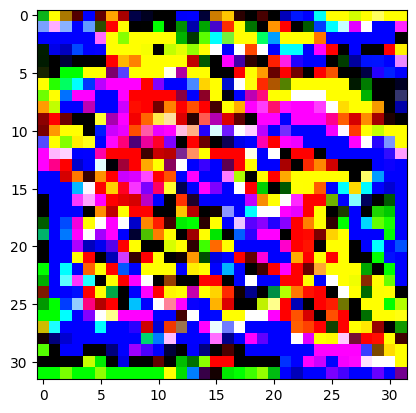

In [ ]:
# @title PixelShuffle init_conv
import torch
import torch.nn as nn

def init_conv(conv, out_r=1, in_r=1):
    o, i, h, w = conv.weight.shape
    conv_weight = torch.empty(o//out_r**2, i//in_r**2, h, w)
    nn.init.kaiming_uniform_(conv_weight)
    conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat_interleave(in_r**2, dim=1))
    if conv.bias is not None: nn.init.zeros_(conv.bias)
    return conv

# Inline model initialization
net = nn.Sequential(
    # nn.PixelUnshuffle(2), nn.Conv2d(3 * 2**2, 4, 3, 1, padding=3//2),
    # nn.Conv2d(4, 3 * 2**2, 3, 1, padding=3//2), nn.PixelShuffle(2)
    # nn.PixelUnshuffle(2), init_conv(nn.Conv2d(3 * 2**2, 4, 3, 1, padding=3//2), down=2),
    init_conv(nn.Conv2d(3, 3 * 2**2, 3, 1, padding=3//2), out_r=2), nn.PixelShuffle(2), # good
    # nn.PixelShuffle(2), init_conv(nn.Conv2d(3* 2**2, 3, 3, 1, padding=3//2), in_r=2),

    # nn.PixelUnshuffle(2), init_conv(nn.Conv2d(3 * 2**2, 2* 2**2, 3, 1, padding=3//2), up=2, down=2), nn.PixelUnshuffle(2),
    # nn.PixelShuffle(2), init_conv(nn.Conv2d(2* 2**2, 3 * 2**2, 3, 1, padding=3//2), up=2, down=2), nn.PixelShuffle(2),

    nn.PixelUnshuffle(2), init_conv(nn.Conv2d(3 * 2**2, 3, 3, 1, padding=3//2), in_r=2), # good
    # init_conv(nn.Conv2d(3, 3, 3, 1, padding=3//2))
)
# self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch * r**2, kernel_size, 1, padding=kernel_size//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
# self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch * r**2, out_ch, kernel_size, 1, padding=kernel_size//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]


# for n, p in net.named_parameters():
#     print(n, p)


dataiter = iter(train_loader) # get some random training images
images, labels = next(dataiter)
out = net(images[0])
# out = net(images[0].repeat_interleave(4, dim=0))

print(out.shape)
imshow(out.detach().cpu())



In [ ]:

# x = torch.rand(1,2,4,4)
# print(x)
# x = nn.PixelUnshuffle(2)(x)
# print(x) # [1,8,2,2]
# print(x.shape) # [1,2,4,4]
x = torch.rand(1,2,2,2).repeat(1,4,1,1)
print(x)
x = torch.rand(1,2,2,2).repeat_interleave(4,dim=1)
print(x)

# x = torch.rand(1,4,2,2)
# print(x)
# x = nn.PixelShuffle(2)(x)
# print(x)


In [ ]:
# @title ViT me
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SimpleViT(nn.Module):
    def __init__(self, in_dim, out_dim, dim, depth, heads, mlp_dim, channels=3, dim_head=8):
        super().__init__()

        self.to_patch_embedding = nn.Sequential( # in, out, kernel, stride, pad
            # nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # PixelShuffleConv(3, dim, 1, r=1/4),
            nn.PixelUnshuffle(2), nn.Conv2d(in_dim * 2**2, dim//2**2, 7, 1, padding=7//2), nn.PixelUnshuffle(2),
            )


        # dim = h/2^2 * w/2^2
        # self.pos_embedding = LearnedRoPE2D(dim)
        # self.pos_embedding = RoPE2D(dim)
        self.positional_emb = nn.Parameter(torch.zeros(1, 8*8, dim), requires_grad=True) # positional_embedding == 'learnable'
        # nn.init.trunc_normal_(self.positional_emb, std=0.2)

        # self.dropout = nn.Dropout(p=0.1)
        self.transformer = AttentionBlock(d_model=dim, d_head=dim_head)
        # self.norm = nn.LayerNorm(dim)

        self.attention_pool = nn.Linear(dim, 1)
        self.out = nn.Linear(dim, out_dim, bias=False)

    def forward(self, img):
        device = img.device
        x = self.to_patch_embedding(img)
        # x = self.pos_embedding(x)
        x = x.flatten(-2).transpose(-2,-1) # b c h w -> b (h w) c
        x = x + self.positional_emb
        # x = self.dropout(x)

        x = self.transformer(x)
        # x = self.norm(x)

        # x = x.flatten(-2).mean(dim=-1) # meal pool
        attn_weights = self.attention_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn_weights.softmax(dim = 1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim]

        # cls_token = repeat(self.class_emb, '1 1 d -> b 1 d', b = b)
        # x = torch.cat((cls_token, x), dim=1)
        # x = x[:, 0] # first token
        return self.out(x)


# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

dim = 64
dim_head = 8
heads = dim // dim_head
num_classes = 10
# model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
model = SimpleViT(in_dim=3, out_dim=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

# print(images.shape) # [batch, 3, 32, 32]
x = torch.rand(64, 3, 32, 32, device=device)
# x = torch.rand(64, 3, 28,28, device=device)
logits = model(x)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")



In [ ]:
# @title ViT me simple
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0.): # .1
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        self.lin = nn.Linear(d_model, d_model)
        # self.lin = zero_module(nn.Linear(d_model, d_model))
        # self.lin = nn.Sequential(nn.Dropout(dropout), zero_module(nn.Linear(d_model, d_model)))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        batch = x.shape[0]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2)
        K, V = self.kv(cond).view(batch, -1, self.n_heads, 2*self.d_head).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.drop(self.lin(out)) # [batch, T, d_model]

# if self, dont pass cond_dim in init, dont pass cond in fwd
# Softmax(Q @ K.T) @ V ~ Softmax(Q) @ Softmax(K).T @ V

# https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py#L1855

class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head, cond_dim=None, ff_mult=1, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.norm2 = nn.RMSNorm(d_model)
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0)
        if self.cond_dim!=None: self.cross = MultiHeadAttention(d_model, d_head=d_head, cond_dim=cond_dim, dropout=0)
        act = nn.GELU() # ReLU GELU
        ff_dim=d_model*ff_mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(d_model, ff_dim), act, # ReLU GELU
            nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), act, nn.Dropout(dropout), nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        # bchw = x.shape
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]

        if self.cond_dim==None: cond=None # is self attn
        x = x + self.drop(self.self(self.norm1(x)))
        if self.cond_dim!=None: x = x + self.cross(self.norm2(x), cond, mask)
        x = x + self.ff(x)
        # x = x + self.drop(self.ff(x))

        # return x.transpose(1,2).reshape(*bchw)
        return x


class SimpleViT(nn.Module):
    def __init__(self, in_dim, out_dim, dim, depth, heads, mlp_dim, channels=3, dim_head=8):
        super().__init__()
        self.to_patch_embedding = nn.Sequential( # in, out, kernel, stride, pad
            nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(2,2)
            )
        # self.pos_embedding = LearnedRoPE2D(dim) # LearnedRoPE2D, RoPE2D
        self.positional_emb = nn.Parameter(torch.zeros(1, 8*8, dim)) # positional_embedding == 'learnable'
        self.transformer = AttentionBlock(d_model=dim, d_head=dim_head)
        # self.transformer_blocks = nn.ModuleList([AttentionBlock(d_model=dim, d_head=dim_head) for i in range(depth)])

        self.attention_pool = nn.Linear(dim, 1)
        self.out = nn.Linear(dim, out_dim, bias=False)

    def forward(self, img):
        device = img.device
        x = self.to_patch_embedding(img)
        # x = self.pos_embedding(x)
        x = x.flatten(-2).transpose(-2,-1) # b c h w -> b (h w) c
        x = x + self.positional_emb
        x = self.transformer(x)
        # for blk in self.predictor_blocks: x = blk(x)

        # x = x.flatten(-2).mean(dim=-1) # mean pool
        attn_weights = self.attention_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn_weights.softmax(dim = 1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim]
        # cls_token = repeat(self.class_emb, '1 1 d -> b 1 d', b = b)
        # x = torch.cat((cls_token, x), dim=1)
        # x = x[:, 0] # first token
        return self.out(x)


# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

# dim = 64
# dim_head = 8
# heads = dim // dim_head
# num_classes = 10
# # model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
# model = SimpleViT(in_dim=3, out_dim=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head).to(device)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
# optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

# # print(images.shape) # [batch, 3, 32, 32]
# x = torch.rand(64, 3, 32, 32, device=device)
# # x = torch.rand(64, 3, 28,28, device=device)
# logits = model(x)
# print(logits.shape)
# pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = pred_probab.argmax(1)
# # print(y_pred)


In [ ]:
# @title lucidrains simple_vit.py
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/simple_vit.py
import torch
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def posemb_sincos_2d(h, w, dim, temperature = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim//4) / (dim//4 - 1)
    omega = 1.0 / (temperature ** omega)
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)
# pos_embedding = posemb_sincos_2d(h = image_height // patch_height, w = image_width // patch_width, dim = dim)
# x = x+pos_embedding

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim), nn.Linear(dim, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)


def pair(t): return t if isinstance(t, tuple) else (t, t)
class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        patch_dim = channels * patch_height * patch_width
        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim), nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )
        self.pos_embedding = posemb_sincos_2d(h = image_height // patch_height, w = image_width // patch_width, dim = dim)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)
        self.to_latent = nn.Identity()
        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        device = img.device
        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)
        x = self.transformer(x)
        x = x.mean(dim = 1)
        x = self.to_latent(x)
        return self.linear_head(x)


# dim = 64
# dim_head = 8
# heads = dim // dim_head
# num_classes = 10
# # model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
# model = SimpleViT(num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
# optim = torch.optim.AdamW(model.parameters(), lr=1e-3)


In [ ]:
# @title lucid CCT
# !pip install -q vit-pytorch

import torch
from vit_pytorch.cct import CCT
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CCT(
    img_size = (32,32),
    embedding_dim = 64,
    n_conv_layers = 1,
    kernel_size = 7,
    stride = 2,
    padding = 3,
    pooling_kernel_size = 3,
    pooling_stride = 2,
    # pooling_padding = 1,
    num_layers = 1,
    num_heads = 8,
    mlp_ratio = 1.,
    num_classes = 10,
    positional_embedding = 'learnable', # ['sine', 'learnable', 'none']
    dim_head = 8,
    # pool='mean', # ['mean', 'cls', 'max']
)


# def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):

optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 236235


x = torch.rand(64, 3, 32, 32, device=device)
# x = torch.rand(64, 1, 28,28, device=device)
logits = model(x)
print(logits.shape)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

# loss: 1.057389  [49920/50000]
# Test Error:
#  Accuracy: 58.5%, Avg loss: 1.146490
# 8: loss: 0.801141  [49920/50000]
# Test Error:
#  Accuracy: 69.9%, Avg loss: 0.885053

# print(model)

# # cct 39371 learn
# loss: 1.426435  [49920/50000]
# Test Error:
#  Accuracy: 50.0%, Avg loss: 1.355331
# 5: loss: 0.954245  [49920/50000]
# Test Error:
#  Accuracy: 64.1%, Avg loss: 1.000242

39371
torch.Size([64, 10])


In [ ]:
# @title sincos_pos_embed
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py
import numpy as np

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False): # grid_size of the grid height and width
    grid_h, grid_w = np.arange(grid_size, dtype=float), np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0) # prepend zeros for cls token later?
    return pos_embed # [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)
    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

import math
def interpolate_pos_encoding(x, pos_embed):
    npatch = x.shape[1] - 1
    N = pos_embed.shape[1] - 1
    if npatch == N: return pos_embed
    class_emb, pos_embed = pos_embed[:, 0], pos_embed[:, 1:]
    dim = x.shape[-1]
    pos_embed = nn.functional.interpolate(pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2), scale_factor=math.sqrt(npatch / N), mode='bicubic',)
    pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)


import torch
import torch.nn as nn
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size, self.patch_size = img_size, patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x): # [b,c,h,w]
        # B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

num_patches = 16
embed_dim = 8
# pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
pos_embed = torch.zeros(1, num_patches, embed_dim)
# patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
patch_embed = PatchEmbed()
# print(pos_embed)
# patch_embed.num_patches = (224/16)^2 = 14^2 = 196
# pos_embed = get_2d_sincos_pos_embed(pos_embed.shape[-1], int(patch_embed.num_patches**.5), cls_token=False)
pos_embed = get_2d_sincos_pos_embed(embed_dim, 14)
print(pos_embed)
print(pos_embed.shape) # 14^2, embed_dim

# x = torch.rand(4,224*224,embed_dim)
# pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

# pos_embed = interpolate_pos_encoding(x, pos_embed)
# print(pos_embed)

import matplotlib.pyplot as plt
plt.imshow(pos_embed)
plt.show()


In [ ]:
# @title posemb_sincos_2d
def posemb_sincos_2d(h, w, dim, temperature = 10000, dtype = torch.float32):
    print(h,w)
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    # print(y,x) # [h,w], y:row_num, x:col_num
    # assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = 1. / (temperature**torch.linspace(0,1,dim//4))
    # print(omega)
    y = y.reshape(-1,1) * omega.unsqueeze(0) # [h*w,1]*[1,dim//4] = [h*w,dim//4]
    x = x.reshape(-1,1) * omega.unsqueeze(0)
    print(y.shape,x.shape) # [h,w], y:row num, x:col num
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1) # [h*w,dim]
    return pe.type(dtype)

# image_height, image_width = 64, 64
# patch_height, patch_width = 8, 8
h=3
w=5
dim=18
# pos_embedding = posemb_sincos_2d(h = image_height // patch_height, w = image_width // patch_width, dim = dim)
pos_embedding = posemb_sincos_2d(h=h, w=w, dim=dim)
# x = x+pos_embedding
# print(pos_embedding)
# print(pos_embedding.shape) # [h*w, dim]
# for i,x in enumerate(pos_embedding):
#     if i%h==0: print('### ', i, ' ###')
#     print(x)


In [ ]:
# @title data
import torchvision
import torchvision.transforms as transforms

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),) # do not normalise! want img in [0,1)
batch_size = 512 # 64 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# dataiter = iter(train_data)
# x,y = next(dataiter)
# print(x)

In [ ]:
# @title lucidrains cct.py
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/cct.py

def sinusoidal_embedding(n_channels, dim):
    pe = torch.FloatTensor([[p / (10000 ** (2 * (i // 2) / dim)) for i in range(dim)]
                            for p in range(n_channels)])
    pe[:, 0::2] = torch.sin(pe[:, 0::2])
    pe[:, 1::2] = torch.cos(pe[:, 1::2])
    return rearrange(pe, '... -> 1 ...')

# modules

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, attention_dropout=0.1, projection_dropout=0.1):
        super().__init__()
        self.heads = num_heads
        head_dim = dim // self.heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attn_drop = nn.Dropout(attention_dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(projection_dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        q = q * self.scale
        attn = einsum('b h i d, b h j d -> b h i j', q, k)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = einsum('b h i j, b h j d -> b h i d', attn, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        return self.proj_drop(self.proj(x))


class TransformerEncoderLayer(nn.Module):
    """
    Inspired by torch.nn.TransformerEncoderLayer and
    rwightman's timm package.
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,attention_dropout=0.1, drop_path_rate=0.1):
        super().__init__()
        self.pre_norm = nn.LayerNorm(d_model)
        self.self_attn = Attention(dim=d_model, num_heads=nhead, attention_dropout=attention_dropout, projection_dropout=dropout)
        self.linear1  = nn.Linear(d_model, dim_feedforward)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1    = nn.LayerNorm(d_model)
        self.linear2  = nn.Linear(dim_feedforward, d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.drop_path = DropPath(drop_path_rate)
        self.activation = F.gelu

    def forward(self, src, *args, **kwargs):
        src = src + self.drop_path(self.self_attn(self.pre_norm(src)))
        src = self.norm1(src)
        src2 = self.linear2(self.dropout1(self.activation(self.linear1(src))))
        src = src + self.drop_path(self.dropout2(src2))
        return src

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = float(drop_prob)

    def forward(self, x):
        batch, drop_prob, device, dtype = x.shape[0], self.drop_prob, x.device, x.dtype

        if drop_prob <= 0. or not self.training:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (batch, *((1,) * (x.ndim - 1)))

        keep_mask = torch.zeros(shape, device = device).float().uniform_(0, 1) < keep_prob
        output = x.div(keep_prob) * keep_mask.float()
        return output


class Tokenizer(nn.Module):
    def __init__(self, kernel_size, stride, padding, pooling_kernel_size=3, pooling_stride=2, pooling_padding=1, n_conv_layers=1,
                 n_input_channels=3, n_output_channels=64, in_planes=64,
                 activation=None, max_pool=True, conv_bias=False):
        super().__init__()
        n_filter_list = [n_input_channels] + [in_planes for _ in range(n_conv_layers - 1)] + [n_output_channels]
        n_filter_list_pairs = zip(n_filter_list[:-1], n_filter_list[1:])
        self.conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(chan_in, chan_out, kernel_size=(kernel_size, kernel_size), stride=(stride, stride), padding=(padding, padding), bias=conv_bias),
                nn.Identity() if not exists(activation) else activation(),
                nn.MaxPool2d(kernel_size=pooling_kernel_size, stride=pooling_stride, padding=pooling_padding) if max_pool else nn.Identity())
                for chan_in, chan_out in n_filter_list_pairs
            ])
        self.apply(self.init_weight)

    def sequence_length(self, n_channels=3, height=224, width=224):
        return self.forward(torch.zeros((1, n_channels, height, width))).shape[1]

    def forward(self, x):
        return rearrange(self.conv_layers(x), 'b c h w -> b (h w) c')

    @staticmethod
    def init_weight(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

class Tokenizer(nn.Module):
    def __init__(self, n_conv_layers=1, n_input_channels=3, n_output_channels=64, in_planes=64,):
        super().__init__()
        n_filter_list = [n_input_channels] + [in_planes for _ in range(n_conv_layers - 1)] + [n_output_channels]
        # print(n_filter_list)
        n_filter_list_pairs = zip(n_filter_list[:-1], n_filter_list[1:])
        # print([x for x in n_filter_list_pairs])
        self.conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(chan_in, chan_out, kernel_size=7, stride=2, padding=7//2, bias=False),
                # nn.Identity() if not exists(activation) else activation(), # None
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                ) for chan_in, chan_out in n_filter_list_pairs
            ])

    # def sequence_length(self, n_channels=3, height=224, width=224):
    #     return self.forward(torch.zeros((1, n_channels, height, width))).shape[1]

    def forward(self, x):
        # return rearrange(self.conv_layers(x), 'b c h w -> b (h w) c')
        return self.conv_layers(x)

class TransformerClassifier(nn.Module):
    def __init__(self,
                 seq_pool=True,
                 embedding_dim=768,
                 num_layers=12,
                 num_heads=12,
                 mlp_ratio=4.0,
                 num_classes=1000,
                 dropout_rate=0.1,
                 attention_dropout=0.1,
                 stochastic_depth_rate=0.1,
                 positional_embedding='sine',
                 sequence_length=None,
                 *args, **kwargs):
        super().__init__()
        assert positional_embedding in {'sine', 'learnable', 'none'}

        dim_feedforward = int(embedding_dim * mlp_ratio)
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.seq_pool = seq_pool

        assert exists(sequence_length) or positional_embedding == 'none', \
            f"Positional embedding is set to {positional_embedding} and" \
            f" the sequence length was not specified."
        if not seq_pool:
            sequence_length += 1
            self.class_emb = nn.Parameter(torch.zeros(1, 1, self.embedding_dim), requires_grad=True)
        else:
            self.attention_pool = nn.Linear(self.embedding_dim, 1)
        if positional_embedding == 'none':
            self.positional_emb = None
        elif positional_embedding == 'learnable':
            self.positional_emb = nn.Parameter(torch.zeros(1, sequence_length, embedding_dim),
                                               requires_grad=True)
            nn.init.trunc_normal_(self.positional_emb, std=0.2)
        else:
            self.positional_emb = nn.Parameter(sinusoidal_embedding(sequence_length, embedding_dim),
                                               requires_grad=False)
        self.dropout = nn.Dropout(p=dropout_rate)
        dpr = [x.item() for x in torch.linspace(0, stochastic_depth_rate, num_layers)]
        self.blocks = nn.ModuleList([
            TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads,
                                    dim_feedforward=dim_feedforward, dropout=dropout_rate,
                                    attention_dropout=attention_dropout, drop_path_rate=layer_dpr)
            for layer_dpr in dpr])
        self.norm = nn.LayerNorm(embedding_dim)
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.apply(self.init_weight)

    def forward(self, x):
        b = x.shape[0]
        if not exists(self.positional_emb) and x.size(1) < self.sequence_length:
            x = F.pad(x, (0, 0, 0, self.n_channels - x.size(1)), mode='constant', value=0)
        if not self.seq_pool:
            cls_token = repeat(self.class_emb, '1 1 d -> b 1 d', b = b)
            x = torch.cat((cls_token, x), dim=1)
        if exists(self.positional_emb):
            x += self.positional_emb
        x = self.dropout(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        if self.seq_pool:
            attn_weights = rearrange(self.attention_pool(x), 'b n 1 -> b n')
            x = einsum('b n, b n d -> b d', attn_weights.softmax(dim = 1), x)
        else:
            x = x[:, 0]
        return self.fc(x)

    @staticmethod
    def init_weight(m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and exists(m.bias):
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)




In [ ]:
# @title lucidrains vit.py
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
import torch
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim), nn.Linear(dim, hidden_dim), nn.GELU(),
            nn.Dropout(dropout), nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout)) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim), nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return self.mlp_head(x)


In [ ]:
# @title 2D RoPE
# https://github.com/naver-ai/rope-vit/blob/main/models/vit_rope.py


# https://github.com/facebookresearch/deit
# https://github.com/meta-llama/codellama/blob/main/llama/model.py

import torch
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
# from timm.models.vision_transformer import Mlp, PatchEmbed , _cfg
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from deit.models_v2 import vit_models, Layer_scale_init_Block, Attention

def init_random_2d_freqs(dim, num_heads, theta = 10.0, rotate = True):
    freqs_x = []
    freqs_y = []
    mag = 1 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    for i in range(num_heads):
        angles = torch.rand(1) * 2 * torch.pi if rotate else torch.zeros(1)
        fx = torch.cat([mag * torch.cos(angles), mag * torch.cos(torch.pi/2 + angles)], dim=-1)
        fy = torch.cat([mag * torch.sin(angles), mag * torch.sin(torch.pi/2 + angles)], dim=-1)
        freqs_x.append(fx)
        freqs_y.append(fy)
    freqs_x = torch.stack(freqs_x, dim=0)
    freqs_y = torch.stack(freqs_y, dim=0)
    freqs = torch.stack([freqs_x, freqs_y], dim=0)
    return freqs

def compute_mixed_cis(freqs, t_x, t_y, num_heads):
    N = t_x.shape[0]
    depth = freqs.shape[1]
    # No float 16 for this range
    with torch.cuda.amp.autocast(enabled=False):
        freqs_x = (t_x.unsqueeze(-1) @ freqs[0].unsqueeze(-2)).view(depth, N, num_heads, -1).permute(0, 2, 1, 3)
        freqs_y = (t_y.unsqueeze(-1) @ freqs[1].unsqueeze(-2)).view(depth, N, num_heads, -1).permute(0, 2, 1, 3)
        freqs_cis = torch.polar(torch.ones_like(freqs_x), freqs_x + freqs_y)
    return freqs_cis


def compute_axial_cis(dim, end_x, end_y, theta = 100.0):
    freqs_x = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    freqs_y = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))

    t_x, t_y = init_t_xy(end_x, end_y)
    freqs_x = torch.outer(t_x, freqs_x)
    freqs_y = torch.outer(t_y, freqs_y)
    freqs_cis_x = torch.polar(torch.ones_like(freqs_x), freqs_x)
    freqs_cis_y = torch.polar(torch.ones_like(freqs_y), freqs_y)
    return torch.cat([freqs_cis_x, freqs_cis_y], dim=-1)

def init_t_xy(end_x, end_y):
    t = torch.arange(end_x * end_y, dtype=torch.float32)
    t_x = (t % end_x).float()
    t_y = torch.div(t, end_x, rounding_mode='floor').float()
    return t_x, t_y


def reshape_for_broadcast(freqs_cis, x):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    if freqs_cis.shape == (x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-2 else 1 for i, d in enumerate(x.shape)]
    elif freqs_cis.shape == (x.shape[-3], x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-3 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rotary_emb(xq, xk, freqs_cis):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq).to(xq.device), xk_out.type_as(xk).to(xk.device)


class RoPEAttention(Attention):
    """Multi-head Attention block with rotary position embeddings."""
    def forward(self, x, freqs_cis):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q[:, :, 1:], k[:, :, 1:] = apply_rotary_emb(q[:, :, 1:], k[:, :, 1:], freqs_cis=freqs_cis)
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class RoPE_Layer_scale_init_Block(Layer_scale_init_Block):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    # with slight modifications
    def __init__(self, *args, **kwargs):
        kwargs["Attention_block"] = RoPEAttention
        super().__init__(*args, **kwargs)

    def forward(self, x, freqs_cis):
        x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), freqs_cis=freqs_cis))
        x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

class rope_vit_models(vit_models):
    def __init__(self, rope_theta=100.0, rope_mixed=False, use_ape=False, **kwargs):
        super().__init__(**kwargs)
        img_size = kwargs['img_size'] if 'img_size' in kwargs else 224
        patch_size = kwargs['patch_size'] if 'patch_size' in kwargs else 16
        num_heads = kwargs['num_heads'] if 'num_heads' in kwargs else 12
        embed_dim = kwargs['embed_dim'] if 'embed_dim' in kwargs else 768
        mlp_ratio = kwargs['mlp_ratio'] if 'mlp_ratio' in kwargs else 4.

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        trunc_normal_(self.cls_token, std=.02)

        self.use_ape = use_ape
        if not self.use_ape:
            self.pos_embed = None

        self.rope_mixed = rope_mixed
        self.num_heads = num_heads
        self.patch_size = patch_size

        if self.rope_mixed:
            self.compute_cis = partial(compute_mixed_cis, num_heads=self.num_heads)

            freqs = []
            for i, _ in enumerate(self.blocks):
                freqs.append(
                    init_random_2d_freqs(dim=embed_dim // num_heads, num_heads=num_heads, theta=rope_theta)
                )
            freqs = torch.stack(freqs, dim=1).view(2, len(self.blocks), -1)
            self.freqs = nn.Parameter(freqs.clone(), requires_grad=True)

            t_x, t_y = init_t_xy(end_x = img_size // patch_size, end_y = img_size // patch_size)
            self.register_buffer('freqs_t_x', t_x)
            self.register_buffer('freqs_t_y', t_y)
        else:
            self.compute_cis = partial(compute_axial_cis, dim=embed_dim//num_heads, theta=rope_theta)

            freqs_cis = self.compute_cis(end_x = img_size // patch_size, end_y = img_size // patch_size)
            self.freqs_cis = freqs_cis

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'freqs'}

    def forward_features(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)

        if self.use_ape:
            pos_embed = self.pos_embed
            if pos_embed.shape[-2] != x.shape[-2]:
                img_size = self.patch_embed.img_size
                patch_size = self.patch_embed.patch_size
                pos_embed = pos_embed.view(
                    1, (img_size[1] // patch_size[1]), (img_size[0] // patch_size[0]), self.embed_dim
                ).permute(0, 3, 1, 2)
                pos_embed = F.interpolate(
                    pos_embed, size=(H // patch_size[1], W // patch_size[0]), mode='bicubic', align_corners=False
                )
                pos_embed = pos_embed.permute(0, 2, 3, 1).flatten(1, 2)
            x = x + pos_embed

        x = torch.cat((cls_tokens, x), dim=1)

        if self.rope_mixed:
            if self.freqs_t_x.shape[0] != x.shape[1] - 1:
                t_x, t_y = init_t_xy(end_x = W // self.patch_size, end_y = H // self.patch_size)
                t_x, t_y = t_x.to(x.device), t_y.to(x.device)
            else:
                t_x, t_y = self.freqs_t_x, self.freqs_t_y
            freqs_cis = self.compute_cis(self.freqs, t_x, t_y)

            for i , blk in enumerate(self.blocks):
                x = blk(x, freqs_cis=freqs_cis[i])
        else:
            if self.freqs_cis.shape[0] != x.shape[1] - 1:
                freqs_cis = self.compute_cis(end_x = W // self.patch_size, end_y = H // self.patch_size)
            else:
                freqs_cis = self.freqs_cis
            freqs_cis = freqs_cis.to(x.device)

            for i , blk in enumerate(self.blocks):
                x = blk(x, freqs_cis=freqs_cis)

        x = self.norm(x)
        x = x[:, 0]

        return x


def adjust_pos_embed_size(model, state_dict):
    # interpolate position embedding
    if 'pos_embed' in state_dict:
        pos_embed_checkpoint = state_dict['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
        # only the position tokens are interpolated
        pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
        pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
        pos_tokens = torch.nn.functional.interpolate(
            pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
        pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
        new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
        state_dict['pos_embed'] = new_pos_embed

    return state_dict

In [ ]:
# @title facebookresearch ViT down
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py
import math
import numpy as np
import torch
import torch.nn as nn
from src.utils.tensors import trunc_normal_, repeat_interleave_batch

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (pred_emb_dim//2, 1,h,h) ->
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False): # grid_size of the grid height and width
    grid_h, grid_w = np.arange(grid_size, dtype=float), np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid) # (pred_emb_dim, [2,1,h,h])
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0) # prepend zeros for cls token later?
    return pos_embed # [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)
    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob = 0., training = False):
    if drop_prob == 0. or not training: return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class Block(nn.Module):
    def __init__(self, dim, num_heads, drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        # self.attn = Attention(dim, num_heads=num_heads, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=drop)
        self.attn = AttentionBlock(dim, dim//num_heads)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * 4)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=nn.GELU, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention: return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size, self.patch_size = img_size, patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x): # [b,c,h,w]
        # B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """3x3 Convolution stems for ViT following ViTC models"""
    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        stem = []
        channels = [in_chans] + channels
        act = nn.ReLU(inplace=True)
        for i in range(len(channels) - 2):
            # stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm))]
            # if batch_norm:
            #     stem += [nn.BatchNorm2d(channels[i+1])]
            # stem += [nn.ReLU(inplace=True)]
            # nn.Sequential(
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm)), nn.BatchNorm2d(channels[i+1]) if batch_norm else nn.Identity(), act,]
            # )
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


# https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
def apply_masks(x, masks):
    """:param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep"""
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1))
        all_x += [torch.gather(x, dim=1, index=mask_keep)]
    return torch.cat(all_x, dim=0)

class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(self, num_patches, embed_dim=768, predictor_embed_dim=384,
        depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs):
        super().__init__()
        self.init_std = init_std
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim), requires_grad=False) # [1, (h*w), pred_emb_dim]
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1], int(num_patches**.5), cls_token=False) # get_2d_sincos_pos_embed(pred_emb_dim, (h)) ->
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0))
        # --
        self.predictor_blocks = nn.ModuleList([Block(dim=predictor_embed_dim, num_heads=num_heads, drop=drop_rate, drop_path=dpr[i]) for i in range(depth)])
        self.predictor_norm = nn.LayerNorm(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        trunc_normal_(self.mask_token, std=self.init_std)

    def forward(self, x, masks_x, masks):
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'
        if not isinstance(masks_x, list): masks_x = [masks_x]
        if not isinstance(masks, list): masks = [masks]

        # -- Batch Size
        B = len(x) // len(masks_x) # batch*M // M

        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x)

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1)
        x += apply_masks(x_pos_embed, masks_x) # apply pos emb to mask tokens

        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1)
        pos_embs = apply_masks(pos_embs, masks)
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x))
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1)
        # --
        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, embed_dim=768, predictor_embed_dim=384, depth=12, predictor_depth=12,
        num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.init_std = init_std
        # --
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list):
                masks = [masks]

        # -- patchify x
        x = self.patch_embed(x)
        B, N, D = x.shape

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        # -- mask x
        if masks is not None:
            x = apply_masks(x, masks)

        # -- fwd prop
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None:
            x = self.norm(x)
        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N: return pos_embed
        class_emb, pos_embed = pos_embed[:, 0], pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2), scale_factor=math.sqrt(npatch / N), mode='bicubic',)
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)

# from functools import partial
# def vit_predictor(**kwargs):
#     model = VisionTransformerPredictor(
#         mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

def vit(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, # tiny
        # patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, # small
        # patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, # base
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model




In [ ]:
# @title facebookresearch ViT base
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py

# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import math
import numpy as np
import torch
import torch.nn as nn
from src.utils.tensors import trunc_normal_, repeat_interleave_batch
from src.masks.utils import apply_masks

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False): # grid_size of the grid height and width
    grid_h, grid_w = np.arange(grid_size, dtype=float), np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0) # prepend zeros for cls token later?
    return pos_embed # [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)
    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob = 0., training = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
# lin act drop lin drop


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """3x3 Convolution stems for ViT following ViTC models"""
    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(self, num_patches, embed_dim=768, predictor_embed_dim=384,
        depth=6, num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None,
        drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim), requires_grad=False)
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1], int(num_patches**.5), cls_token=False)
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0))
        # --
        self.predictor_blocks = nn.ModuleList([
            Block(dim=predictor_embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.predictor_norm = norm_layer(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        self.init_std = init_std
        trunc_normal_(self.mask_token, std=self.init_std)
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.predictor_blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks_x, masks):
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'

        if not isinstance(masks_x, list): masks_x = [masks_x]
        if not isinstance(masks, list): masks = [masks]

        # -- Batch Size
        B = len(x) // len(masks_x)

        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x)

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1)
        x += apply_masks(x_pos_embed, masks_x)

        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1)
        pos_embs = apply_masks(pos_embs, masks)
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x))
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1)
        # --
        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, embed_dim=768, predictor_embed_dim=384, depth=12, predictor_depth=12,
        num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        # --
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # ------
        self.init_std = init_std
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list):
                masks = [masks]

        # -- patchify x
        x = self.patch_embed(x)
        B, N, D = x.shape

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        # -- mask x
        if masks is not None:
            x = apply_masks(x, masks)

        # -- fwd prop
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None:
            x = self.norm(x)
        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N:
            return pos_embed
        class_emb = pos_embed[:, 0]
        pos_embed = pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(
            pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=math.sqrt(npatch / N),
            mode='bicubic',
        )
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)


from functools import partial
def vit_predictor(**kwargs):
    model = VisionTransformerPredictor(
        mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def vit(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, # tiny
        # patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, # small
        # patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, # base
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model




In [ ]:
# @title lucid SimpleViT
import torch
from vit_pytorch import SimpleViT

model = SimpleViT(
    image_size = 32,
    patch_size = 8,
    num_classes = 10,
    dim = 64,
    depth = 1,
    heads = 8,
    mlp_dim = 64,

    # num_heads = 8,
    # mlp_ratio = 1.,
    # positional_embedding = 'learnable', # ['sine', 'learnable', 'none']
    dim_head = 8,

)
# def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):

# img = torch.randn(1, 3, 256, 256)
# preds = v(img) # (1, 1000)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 236235
x = torch.rand(64, 3, 32, 32, device=device)
# x = torch.rand(64, 1, 28,28, device=device)
logits = model(x)
print(logits.shape)

# loss: 1.684826  [49920/50000]
# Test Error:
#  Accuracy: 40.7%, Avg loss: 1.642769


38602
torch.Size([64, 10])


In [ ]:
# @title NVlabs afno2d.py
# https://github.com/NVlabs/AFNO-transformer/blob/master/afno/afno2d.py
# Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.

# import math
import torch
# import torch.fft
import torch.nn as nn
import torch.nn.functional as F

class AFNO2D(nn.Module):
    """
    hidden_size: channel dimension size
    num_blocks: how many blocks to use in the block diagonal weight matrices (higher => less complexity but less parameters)
    hard_thresholding_fraction: how many frequencies you want to completely mask out (lower => hard_thresholding_fraction^2 less FLOPs)
    """
    def __init__(self, hidden_size, num_blocks=8, hard_thresholding_fraction=1, hidden_size_factor=1):
        super().__init__()
        assert hidden_size % num_blocks == 0, f"hidden_size {hidden_size} should be divisble by num_blocks {num_blocks}"

        self.hidden_size = hidden_size
        self.num_blocks = num_blocks
        self.block_size = self.hidden_size // self.num_blocks
        self.hard_thresholding_fraction = hard_thresholding_fraction
        self.hidden_size_factor = hidden_size_factor
        self.scale = 0.02

        self.w1 = nn.Parameter(self.scale * torch.randn(2, self.num_blocks, self.block_size, self.block_size * self.hidden_size_factor))
        self.b1 = nn.Parameter(self.scale * torch.randn(2, self.num_blocks, self.block_size * self.hidden_size_factor))
        self.w2 = nn.Parameter(self.scale * torch.randn(2, self.num_blocks, self.block_size * self.hidden_size_factor, self.block_size))
        self.b2 = nn.Parameter(self.scale * torch.randn(2, self.num_blocks, self.block_size))

    def forward(self, x, spatial_size=None):
        bias = x
        dtype = x.dtype
        x = x.float()
        B, N, C = x.shape

        x = x.reshape(B, H, W, C)
        x = torch.fft.rfft2(x, dim=(1, 2), norm="ortho")
        x = x.reshape(B, x.shape[1], x.shape[2], self.num_blocks, self.block_size) # [b, h, w//2+1, n_blocks, block_size]
        o1_real = torch.zeros([B, x.shape[1], x.shape[2], self.num_blocks, self.block_size * self.hidden_size_factor], device=x.device)
        o1_imag = torch.zeros([B, x.shape[1], x.shape[2], self.num_blocks, self.block_size * self.hidden_size_factor], device=x.device)
        o2_real = torch.zeros(x.shape, device=x.device)
        o2_imag = torch.zeros(x.shape, device=x.device)

        total_modes = N // 2 + 1
        kept_modes = int(total_modes * self.hard_thresholding_fraction)

        o1_real[:, :, :kept_modes] = F.relu(
            torch.einsum('...bi,bio->...bo', x[:, :, :kept_modes].real, self.w1[0]) - \
            torch.einsum('...bi,bio->...bo', x[:, :, :kept_modes].imag, self.w1[1]) + \
            self.b1[0]
        )

        o1_imag[:, :, :kept_modes] = F.relu(
            torch.einsum('...bi,bio->...bo', x[:, :, :kept_modes].imag, self.w1[0]) + \
            torch.einsum('...bi,bio->...bo', x[:, :, :kept_modes].real, self.w1[1]) + \
            self.b1[1]
        )

        o2_real[:, :, :kept_modes] = (
            torch.einsum('...bi,bio->...bo', o1_real[:, :, :kept_modes], self.w2[0]) - \
            torch.einsum('...bi,bio->...bo', o1_imag[:, :, :kept_modes], self.w2[1]) + \
            self.b2[0]
        )

        o2_imag[:, :, :kept_modes] = (
            torch.einsum('...bi,bio->...bo', o1_imag[:, :, :kept_modes], self.w2[0]) + \
            torch.einsum('...bi,bio->...bo', o1_real[:, :, :kept_modes], self.w2[1]) + \
            self.b2[1]
        )

        x = torch.stack([o2_real, o2_imag], dim=-1)
        x = F.softshrink(x, lambd=0.01)
        x = torch.view_as_complex(x)
        x = x.reshape(B, x.shape[1], x.shape[2], C)
        x = torch.fft.irfft2(x, s=(H, W), dim=(1, 2), norm="ortho")
        x = x.reshape(B, N, C)
        x = x.type(dtype)
        return x + bias

b,c,h,w = 2,16,9,9
# w//2+1
# b,c,h,w = 2,3,16,16
mix = AFNO2D(c)
x = torch.rand(b,c,h,w)
out = mix(x)
print(out.shape)
# print(out)



In [ ]:
# @title AFNO2D_channelfirst save
# Adaptive Frequency Filters As Efficient Global Token Mixers
# https://arxiv.org/pdf/2307.14008
# https://github.com/microsoft/TokenMixers/blob/main/Adaptive%20Frequency%20Filters/affnet/modules/aff_block.py#L62
import torch
import torch.nn as nn
import torch.nn.functional as F

class AFNO2D_channelfirst(nn.Module):
    def __init__(self, hidden_size, num_blocks=8, hidden_size_factor=1):
        super().__init__()
        self.num_blocks = num_blocks # num_blocks: how many blocks to use in the block diagonal weight matrices (higher => less complexity but less parameters)
        self.block_size = hidden_size // self.num_blocks
        scale = 0.02

        self.w1 = nn.Parameter(scale * torch.randn(2, self.num_blocks, self.block_size, self.block_size * hidden_size_factor))
        self.b1 = nn.Parameter(scale * torch.randn(2, self.num_blocks, self.block_size * hidden_size_factor))
        self.w2 = nn.Parameter(scale * torch.randn(2, self.num_blocks, self.block_size * hidden_size_factor, self.block_size))
        self.b2 = nn.Parameter(scale * torch.randn(2, self.num_blocks, self.block_size))

    @torch.cuda.amp.autocast(enabled=False)
    def forward(self, x): # [b,c,h,w]
        bias = x
        dtype = x.dtype
        x = x.float()
        B, C, H, W = x.shape
        x = torch.fft.rfft2(x, dim=(2, 3), norm="ortho") # [b, c, h, w//2+1]
        origin_ffted = x
        x = x.unflatten(1, (self.num_blocks, self.block_size)) # [b, n_blocks, block_size, h, w//2+1]

# [b, n_blocks, block_size, h, w//2+1] @ [n_blocks, block_size, block_size * h_factor] -> [b, n_blocks, block_size * h_factor, h, w//2+1]
# + [n_blocks, block_size * h_factor]
        o1_real = F.relu(torch.einsum('bkihw,kio->bkohw', x.real, self.w1[0]) - \
            torch.einsum('bkihw,kio->bkohw', x.imag, self.w1[1]) + self.b1[0, :, :, None, None])
        o1_imag = F.relu(torch.einsum('bkihw,kio->bkohw', x.imag, self.w1[0]) + \
            torch.einsum('bkihw,kio->bkohw', x.real, self.w1[1]) + self.b1[1, :, :, None, None])
        o2_real = (torch.einsum('bkihw,kio->bkohw', o1_real, self.w2[0]) - \
            torch.einsum('bkihw,kio->bkohw', o1_imag, self.w2[1]) + self.b2[0, :, :, None, None])
        o2_imag = (torch.einsum('bkihw,kio->bkohw', o1_imag, self.w2[0]) + \
            torch.einsum('bkihw,kio->bkohw', o1_real, self.w2[1]) + self.b2[1, :, :, None, None])

# [n_blocks, block_size * h_factor, block_size]


        x = torch.stack([o2_real, o2_imag], dim=-1)
        x = F.softshrink(x, lambd=0.01)
        x = torch.view_as_complex(x)
        x = x.flatten(1,2) # [b, c, h, w]

        x = x * origin_ffted
        x = torch.fft.irfft2(x, s=(H, W), dim=(2, 3), norm="ortho")
        x = x.type(dtype)
        return x + bias

# batch, T, dim = 2,7,5
b,c,h,w = 2,16,9,9
# w//2+1
# b,c,h,w = 2,3,16,16
mix = AFNO2D_channelfirst(c, 4)
x = torch.rand(b,c,h,w)
out = mix(x)
print(out.shape)
# print(out)


torch.Size([2, 16, 9, 5])
torch.Size([2, 4, 4, 9, 5])
torch.Size([2, 16, 9, 9])


<ipython-input-36-6b5c42229079>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## trash

In [ ]:
# @title hiera_mae.py
# https://github.com/facebookresearch/hiera/blob/main/hiera/hiera_mae.py
import math
import torch
import torch.nn as nn

def apply_fusion_head(head, x):
    if isinstance(head, nn.Identity):
        return x
    B, num_mask_units = x.shape[0:2]
    # Apply head, e.g [B, #MUs, My, Mx, C] -> head([B * #MUs, C, My, Mx])
    permute = [0] + [len(x.shape) - 2] + list(range(1, len(x.shape) - 2))
    x = head(x.reshape(B * num_mask_units, *x.shape[2:]).permute(permute))

    # Restore original layout, e.g. [B * #MUs, C', My', Mx'] -> [B, #MUs, My', Mx', C']
    permute = [0] + list(range(2, len(x.shape))) + [1]
    x = x.permute(permute).reshape(B, num_mask_units, *x.shape[2:], x.shape[1])
    return x


class MaskedAutoencoderHiera(Hiera):
    def __init__(self, in_chans = 3, patch_stride = (4, 4),
        decoder_embed_dim = 512, decoder_depth = 8, decoder_num_heads = 16, **kwdargs,):
        super().__init__(in_chans=in_chans, patch_stride=patch_stride, **kwdargs)
        del self.head
        encoder_dim_out = self.blocks[-1].dim_out
        self.encoder_norm = nn.LayerNorm(encoder_dim_out)
        self.mask_unit_spatial_shape_final = [i // s ** (self.q_pool) for i, s in zip(self.mask_unit_size, self.q_stride)]
        self.tokens_spatial_shape_final = [i // s ** (self.q_pool) for i, s in zip(self.tokens_spatial_shape, self.q_stride)]
        # --------------------------------------------------------------------------
        # Multi-scale fusion heads
        curr_mu_size = self.mask_unit_size
        self.multi_scale_fusion_heads = nn.ModuleList()
        for i in self.stage_ends[: self.q_pool]:  # resolution constant after q_pool
            kernel = [i // s for i, s in zip(curr_mu_size, self.mask_unit_spatial_shape_final)]
            curr_mu_size = [i // s for i, s in zip(curr_mu_size, self.q_stride)]
            self.multi_scale_fusion_heads.append(
                conv_nd(len(self.q_stride))(self.blocks[i].dim_out, encoder_dim_out, kernel_size=kernel, stride=kernel)
            )
        self.multi_scale_fusion_heads.append(nn.Identity())  # final stage, no transform

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(encoder_dim_out, decoder_embed_dim)
        self.mask_token = nn.Parameter(torch.randn(1, 1, decoder_embed_dim)*0.02)
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, math.prod(self.tokens_spatial_shape_final), decoder_embed_dim)*0.02)
        self.decoder_blocks = nn.ModuleList([HieraBlock(dim=decoder_embed_dim, dim_out=decoder_embed_dim, heads=decoder_num_heads) for i in range(decoder_depth)])
        self.pred_stride = patch_stride[-1] * (self.q_stride[-1] ** self.q_pool)
        self.decoder_out = nn.Sequential(nn.LayerNorm(decoder_embed_dim), nn.Linear(decoder_embed_dim, (self.pred_stride**min(2, len(self.q_stride)))*in_chans))

    def get_pixel_label_2d(self, input_img, mask, norm=True): # mask: bool, True -> mask
        input_img = input_img.permute(0, 2, 3, 1)

        size = self.pred_stride
        label = input_img.unfold(1, size, size).unfold(2, size, size)
        label = label.flatten(1, 2).flatten(2)
        label = label[mask]
        if norm:
            label = F.layer_norm(label, label.shape[-1:]) # l = F.layer_norm(label, (label.size(-1),))
        return label

    def get_pixel_label_3d(self, input_vid, mask, norm = True): # [b,c,f,h,w]?
        # mask (boolean tensor): True must correspond to *masked*
        # We use time strided loss, only take the first frame from each token
        input_vid = input_vid[:, :, ::self.patch_stride[0], :, :]
        size = self.pred_stride
        label = input_vid.unfold(3, size, size).unfold(4, size, size)
        label = label.permute(0, 2, 3, 4, 5, 6, 1)  # Different from 2d, mistake during training lol
        label = label.flatten(1, 3).flatten(2)
        label = label[mask]
        if norm:
            label = F.layer_norm(label, label.shape[-1:])
        return label

    def forward_encoder(self, x, mask=None):
        # Get multi-scale representations from encoder
        _, intermediates = super().forward(x, mask, return_intermediates=True)
        # Resolution unchanged after q_pool stages, so skip those features
        intermediates = intermediates[: self.q_pool] + intermediates[-1:]

        # Multi-scale fusion
        x = sum([apply_fusion_head(head, interm_x) for head, interm_x in zip(self.multi_scale_fusion_heads, intermediates)])
        x = self.encoder_norm(x)
        return x, mask

    def forward_decoder(self, x, mask):
        x = self.decoder_embed(x)

        # Combine visible and mask tokens

        # x: [B, #MUs, *mask_unit_spatial_shape_final, encoder_dim_out]
        # mask: [B, #MUs_all]
        x_dec = torch.zeros(*mask.shape, *x.shape[2:], device=x.device, dtype=x.dtype)
        mask_tokens = self.mask_token.view((1,) * (len(mask.shape) + len(x.shape[2:-1])) + (-1,))
        mask = mask.reshape(mask.shape + (1,) * len(x.shape[2:]))
        mask = mask.expand((-1,) * 2 + x.shape[2:]).bool()
        x_dec[mask] = x.flatten()
        x_dec = ~mask * mask_tokens + mask * x_dec

        # Get back spatial order
        x = undo_windowing(x_dec, self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final)
        mask = undo_windowing(mask[..., 0:1], self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final)

        # Flatten
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        mask = mask.view(x.shape[0], -1)

        x = x + self.decoder_pos_embed
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_out(x)
        return x, mask

    def forward_loss(self, x, pred, mask):
        """
        Note: in mask, 0 is *visible*, 1 is *masked*

        x: e.g. [B, 3, H, W]
        pred: [B * num_pred_tokens, num_pixels_in_pred_patch * in_chans]
        label: [B * num_pred_tokens, num_pixels_in_pred_patch * in_chans]
        """
        if len(self.q_stride) == 2:
            label = self.get_pixel_label_2d(x, mask)
        elif len(self.q_stride) == 3:
            label = self.get_pixel_label_3d(x, mask)
        pred = pred[mask]
        loss = (pred - label) ** 2
        return loss.mean(), pred, label

    def forward(self, x, mask=None):
        latent, mask = self.forward_encoder(x, mask=mask)
        pred, pred_mask = self.forward_decoder(latent, mask)  # pred_mask is mask at resolution of *prediction*
        # Toggle mask, to generate labels for *masked* tokens
        return *self.forward_loss(x, pred, ~pred_mask), mask


# model = MaskedAutoencoderHiera(embed_dim=16, num_heads=1, stages=(1, 2, 2, 2), q_pool=2)
mask_ratio=.8
# x = torch.randn((1, 3, 224, 224))
# mask = randpatch(math.prod(model.mask_spatial_shape), x.shape[0], mask_ratio)  # [B, #MUs_all]
# # out = model(x, mask_ratio=0.6, mask=mask)
out = model(x, mask=mask)
# out = model(x)
print(out)
print(len(out))
for o in out:
    print(o.shape)

# [], [116, 768], [116, 768], [1, 49]

# # Image Models
# def mae_hiera_tiny_224(**kwargs):
#     return MaskedAutoencoderHiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2), q_pool=2, **kwargs,
# def mae_hiera_small_224(embed_dim=96, num_heads=1, stages=(1, 2, 11, 2), q_pool=2, **kwargs,
# def mae_hiera_base_224(embed_dim=96, num_heads=1, stages=(2, 3, 16, 3), q_pool=2, **kwargs,
# def mae_hiera_base_plus_224(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3), q_pool=2, **kwargs,
# def mae_hiera_large_224(embed_dim=144, num_heads=2, stages=(2, 6, 36, 4), q_pool=2, **kwargs,
# def mae_hiera_huge_224(embed_dim=256, num_heads=4, stages=(2, 6, 36, 4), q_pool=2, **kwargs,

# # Video Models
# def mae_hiera_base_16x224(num_classes = 400, **kwdargs):
#     return MaskedAutoencoderHiera(num_classes=num_classes,  # K400 has 400 classes
#         input_size=(16, 224, 224), q_stride=(1, 2, 2), mask_unit_size=(1, 8, 8),
#         patch_kernel=(3, 7, 7), patch_stride=(2, 4, 4), patch_padding=(1, 3, 3),
#         sep_pos_embed=True, q_pool=2, **kwdargs)
# def mae_hiera_base_plus_16x224(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3), **kwdargs
# def mae_hiera_large_16x224(embed_dim=144, num_heads=2, stages=(2, 6, 36, 4), **kwdargs
# def mae_hiera_huge_16x224(embed_dim=256, num_heads=4, stages=(2, 6, 36, 4), **kwdargs


In [ ]:
# @title hiera_mae.py
# https://github.com/facebookresearch/hiera/blob/main/hiera/hiera_mae.py
import math
import torch
import torch.nn as nn

def apply_fusion_head(head, x): # [B, #MUs, My, Mx, C]
    if isinstance(head, nn.Identity): return x
    B, num_mask_units = x.shape[0:2]
    permute = [0] + [len(x.shape) - 2] + list(range(1, len(x.shape) - 2))
    x = head(x.reshape(B * num_mask_units, *x.shape[2:]).permute(permute)) # [B, #MUs, My, Mx, C] -> head([B * #MUs, C, My, Mx])
    permute = [0] + list(range(2, len(x.shape))) + [1] # [0, *2345.., 1]
    x = x.permute(permute).reshape(B, num_mask_units, *x.shape[2:], x.shape[1]) # [B * #MUs, C', My', Mx'] -> [B, #MUs, My', Mx', C']
    return x

class Decoder(nn.Module):
    def __init__(self, in_dim=16*2**3, d_model = 512, out_dim=3,depth = 8, n_heads=16, patch_stride = (4, 4),tokens_spatial_shape=(56,56),q_pool=3 , q_stride=(2, 2),
        mask_unit_size = (8, 8), # must divide q_stride**(num_stages-1)
        ):
        super().__init__()
        self.mask_unit_spatial_shape_final = [i//s**q_pool for i, s in zip(mask_unit_size, q_stride)] # [1, 1]
        self.tokens_spatial_shape_final = [i//s**q_pool for i, s in zip(tokens_spatial_shape, q_stride)] # [7, 7]

        self.embed = nn.Linear(in_dim, d_model)
        self.mask_token = nn.Parameter(torch.randn(1, 1, d_model)*0.02)
        self.pos_embed = nn.Parameter(torch.randn(1, math.prod(self.tokens_spatial_shape_final), d_model)*0.02)
        self.blocks = nn.ModuleList([HieraBlock(dim=d_model, dim_out=d_model, heads=n_heads) for i in range(depth)])
        self.pred_stride = patch_stride[-1] * (q_stride[-1] ** q_pool)
        self.out = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, (self.pred_stride**min(2, len(q_stride)))*out_dim))

    def forward(self, x, mask): # [24, 9, 2, 2, 128], [24, 49] # [24, 9, 128], [24, 49]
        # print('fwd dec1', x.shape)
        print('fwd dec1', x.shape, mask.shape)
        x = self.embed(x) # [24, 9, 2, 2, 512]

        # # x: [B, #MUs, *mask_unit_spatial_shape_final, encoder_dim_out]
        # # mask: [B, #MUs_all]
        # x_dec = torch.zeros(*mask.shape, *x.shape[2:], device=x.device, dtype=x.dtype) # [24, 49, 2, 2, 512]
        # mask_tokens = self.mask_token.view((1,) * (mask.dim() + x.dim()-3) + (-1,)) # (1, 1, 1, 1, -1) # [1, 1, 1, 1, 512]
        # mask = mask[...,*[None for _ in range(x.dim()-2)]] # [24, 49, 1, 1, 1] # ([24, 49, 1, 1, 1]
        # mask = mask.expand((-1,) * 2 + x.shape[2:]).bool() # (-1, -1, 2, 2, 512) # [24, 49, 2, 2, 512]

        x_dec = torch.zeros(*mask.shape, x.shape[-1], device=x.device, dtype=x.dtype) # [24, 49, 512]

        # print('fwd dec3', x_dec.shape, mask.shape, mask_tokens.shape)
        print('fwd dec3', x_dec.shape, mask.shape, self.mask_token.shape) # [24, 49, 512], [24, 49], [1, 1, 512]
        mask = mask.unsqueeze(-1).repeat(1,1, x.shape[-1])

        x_dec[mask] = x.flatten()
        # x_dec = ~mask * mask_tokens + mask * x_dec # [24, 49, 2, 2, 512]
        x_dec = ~mask * self.mask_token + mask * x_dec # [24, 49, 2, 2, 512]
        # print('fwd dec3', x_dec.shape)

        # Get back spatial order
        # print(self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final) # [24, 14, 14, 512]
        x = undo_windowing(x_dec, self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final) # [24, 14, 14, 512]
        # mask = undo_windowing(mask[..., 0:1], self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final) # [24, 14, 14, 1]
        # print('fwd dec4', x.shape, mask[..., 0].shape) # ,

        x = x.reshape(x.shape[0], -1, x.shape[-1])
        # mask = mask.view(x.shape[0], -1)

        x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.out(x)
        return x#, mask

encoder = Hiera(d_model=16, n_heads=1, stages=(2, 2, 3, 2), q_pool=3)
decoder = Decoder(in_dim=16*2**3, n_heads=1, out_dim=3, tokens_spatial_shape=(56,56))
# self.decoder_blocks = nn.ModuleList([HieraBlock(dim=decoder_embed_dim, dim_out=decoder_embed_dim, heads=decoder_num_heads) for i in range(decoder_depth)])

mask_ratio=.8
x = torch.randn((24, 3, 224, 224))
mask = randpatch(math.prod(encoder.mask_spatial_shape), x.shape[0], mask_ratio)  # [B, #MUs_all]
latent = encoder(x, mask, return_intermediates=True)
print('latent',latent.shape)
pred = decoder(latent, mask)

# print(out.shape)
print(pred.shape)

# # Image Models
# mae_hiera_tiny_224(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2), q_pool=2)
# # Video Models
# def mae_hiera_base_16x224(num_classes = 400, **kwdargs):
#     return MaskedAutoencoderHiera(num_classes=num_classes,  # K400 has 400 classes
#         input_size=(16, 224, 224), q_stride=(1, 2, 2), mask_unit_size=(1, 8, 8),
#         patch_kernel=(3, 7, 7), patch_stride=(2, 4, 4), patch_padding=(1, 3, 3),
#         sep_pos_embed=True, q_pool=2, **kwdargs)
# def mae_hiera_base_plus_16x224(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3)



NameError: name 'Hiera' is not defined

In [ ]:
# @title hiera_mae.py
# https://github.com/facebookresearch/hiera/blob/main/hiera/hiera_mae.py
import math
import torch
import torch.nn as nn

def apply_fusion_head(head, x): # [B, #MUs, My, Mx, C]
    if isinstance(head, nn.Identity): return x
    B, num_mask_units = x.shape[0:2]
    permute = [0] + [len(x.shape) - 2] + list(range(1, len(x.shape) - 2))
    x = head(x.reshape(B * num_mask_units, *x.shape[2:]).permute(permute)) # [B, #MUs, My, Mx, C] -> head([B * #MUs, C, My, Mx])
    permute = [0] + list(range(2, len(x.shape))) + [1] # [0, *2345.., 1]
    x = x.permute(permute).reshape(B, num_mask_units, *x.shape[2:], x.shape[1]) # [B * #MUs, C', My', Mx'] -> [B, #MUs, My', Mx', C']
    return x

# class MaskedAutoencoderHiera(Hiera):
class MaskedAutoencoderHiera(nn.Module):
    def __init__(self, in_dim=16*2**3, d_model = 512, out_dim=3,depth = 8, n_heads=16, patch_stride = (4, 4),tokens_spatial_shape=(56,56),q_pool=3 , q_stride=(2, 2),
        mask_unit_size = (8, 8), # must divide q_stride**(num_stages-1)
        ):
        super().__init__()
        self.mask_unit_spatial_shape_final = [i//s**q_pool for i, s in zip(mask_unit_size, q_stride)] # [1, 1]
        self.tokens_spatial_shape_final = [i//s**q_pool for i, s in zip(tokens_spatial_shape, q_stride)] # [7, 7]

        self.embed = nn.Linear(in_dim, d_model)
        self.mask_token = nn.Parameter(torch.randn(1, 1, d_model)*0.02)
        self.pos_embed = nn.Parameter(torch.randn(1, math.prod(self.tokens_spatial_shape_final), d_model)*0.02)
        self.blocks = nn.ModuleList([HieraBlock(dim=d_model, dim_out=d_model, heads=n_heads) for i in range(depth)])
        self.pred_stride = patch_stride[-1] * (q_stride[-1] ** q_pool)
        self.out = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, (self.pred_stride**min(2, len(q_stride)))*out_dim))

    # def get_pixel_label_2d(self, input_img, mask, norm=True): # mask: bool, True -> mask
    #     # [b,c,h,w], [B * num_pred_tokens, num_pixels_in_pred_patch * in_dim], 1->mask
    #     input_img = input_img.permute(0, 2, 3, 1) # [b,h,w,c]
    #     size = self.pred_stride
    #     label = input_img.unfold(1, size, size).unfold(2, size, size) # [b,h/s,w/s,c,s,s]
    #     label = label.flatten(1, 2).flatten(2) # [b, h/s* w/s, s*s*c]
    #     label = label[mask]
    #     if norm: label = F.layer_norm(label, label.shape[-1:]) # l = F.layer_norm(label, (label.size(-1),))
    #     return label

    # def get_pixel_label_3d(self, input_vid, mask, norm = True): # [b,c,f,h,w]?
    #     # mask (boolean tensor): True must correspond to *masked*
    #     # We use time strided loss, only take the first frame from each token
    #     input_vid = input_vid[:, :, ::self.patch_stride[0], :, :]
    #     # input_img = input_img.permute(0, 2, 3, 4, 1) # [b,f,h,w,c]
    #     size = self.pred_stride
    #     label = input_vid.unfold(3, size, size).unfold(4, size, size) # [b,c,patch_stride[0],h/s,w/s,s,s]
    #     label = label.permute(0, 2, 3, 4, 5, 6, 1) # [b,patch_stride[0],h/s,w/s,s,s,c] # Different from 2d, mistake during training lol
    #     label = label.flatten(1, 3).flatten(2) # [b,patch_stride[0]* h/s* w/s,s*s*c]
    #     label = label[mask]
    #     if norm: label = F.layer_norm(label, label.shape[-1:])
    #     return label

    def forward_decoder(self, x, mask): # [24, 9, 2, 2, 128], [24, 49]
        print('fwd dec1', x.shape)
        x = self.embed(x) # [24, 9, 2, 2, 512]

        # x: [B, #MUs, *mask_unit_spatial_shape_final, encoder_dim_out]
        # mask: [B, #MUs_all]
        x_dec = torch.zeros(*mask.shape, *x.shape[2:], device=x.device, dtype=x.dtype) # [24, 49, 2, 2, 512]
        mask_tokens = self.mask_token.view((1,) * (mask.dim() + x.dim()-3) + (-1,)) # (1, 1, 1, 1, -1) # [1, 1, 1, 1, 512]

        mask = mask[...,*[None for _ in range(x.dim()-2)]] # [24, 49, 1, 1, 1] # ([24, 49, 1, 1, 1]
        # print('fwd dec3', x_dec.shape, mask.shape, mask_tokens.shape)
        mask = mask.expand((-1,) * 2 + x.shape[2:]).bool() # (-1, -1, 2, 2, 512) # [24, 49, 2, 2, 512]
        # print((-1,) * 2 + x.shape[2:])
        x_dec[mask] = x.flatten()
        x_dec = ~mask * mask_tokens + mask * x_dec # [24, 49, 2, 2, 512]
        print('fwd dec3', x_dec.shape)

        # Get back spatial order
        print(self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final) # [24, 14, 14, 512]
        x = undo_windowing(x_dec, self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final) # [24, 14, 14, 512]
        # mask = undo_windowing(mask[..., 0:1], self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final) # [24, 14, 14, 1]
        # print('fwd dec4', x.shape, mask[..., 0].shape) # ,

        x = x.reshape(x.shape[0], -1, x.shape[-1])
        # mask = mask.view(x.shape[0], -1)

        x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.out(x)
        return x#, mask

    # def forward_loss(self, x, pred, mask): # [b,c,(f,)h,w], [B * num_pred_tokens, num_pixels_in_pred_patch * in_chans], 1->mask
    #     if len(self.q_stride) == 2: label = self.get_pixel_label_2d(x, mask) # [B * num_pred_tokens, num_pixels_in_pred_patch * in_chans]
    #     elif len(self.q_stride) == 3: label = self.get_pixel_label_3d(x, mask)
    #     pred = pred[mask]
    #     loss = F.mse_loss(pred, label) # ((pred-label)**2).mean()
    #     return loss, pred, label

    # def forward(self, x, mask=None):
    #     latent, mask = self.forward_encoder(x, mask=mask)
    #     # latent = self.forward_encoder(x, mask=mask)
    #     # print('mse fwd', latent.shape, mask.shape)
    #     # pred, pred_mask = self.forward_decoder(latent, mask)  # pred_mask is mask at resolution of *prediction*
    #     pred = self.forward_decoder(latent, mask)  # pred_mask is mask at resolution of *prediction*
    #     # Toggle mask, to generate labels for *masked* tokens
    #     # return *self.forward_loss(x, pred, ~pred_mask), mask
    #     return pred


# model = MaskedAutoencoderHiera(embed_dim=16, num_heads=1, stages=(1, 2, 2, 2), q_pool=2)
encoder = Hiera(embed_dim=16, num_heads=1, stages=(1, 2, 2, 2), q_pool=2)
# # decoder = MaskedAutoencoderHiera(embed_dim=16, num_heads=1, stages=(1, 2, 2, 2), q_pool=2)
decoder = MaskedAutoencoderHiera(in_dim=16*2**3, n_heads=1, out_dim=3, tokens_spatial_shape=(56,56))

# self.decoder_blocks = nn.ModuleList([HieraBlock(dim=decoder_embed_dim, dim_out=decoder_embed_dim, heads=decoder_num_heads) for i in range(decoder_depth)])


mask_ratio=.8
# x = torch.randn((1, 3, 224, 224))
# mask = randpatch(math.prod(model.mask_spatial_shape), x.shape[0], mask_ratio)  # [B, #MUs_all]
mask = randpatch(math.prod(encoder.mask_spatial_shape), x.shape[0], mask_ratio)  # [B, #MUs_all]
# # out = model(x, mask_ratio=0.6, mask=mask)
out = model(x, mask=mask)
# latent = encoder(x, mask, return_intermediates=True)
# print(latent.shape)
# pred = decoder.forward_decoder(latent, mask)

# pred =
# out = model.forward_loss(x, pred, mask)
# out = model(x)
# loss, pred, label, msk = out
# for o in out:
#     print(o.shape)
# print(label.shape, pred.shape)
print(out.shape)

# [], [116, 768], [116, 768], [1, 49]

# # Image Models
# def mae_hiera_tiny_224(**kwargs):
#     return MaskedAutoencoderHiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2), q_pool=2, **kwargs,
# def mae_hiera_small_224(embed_dim=96, num_heads=1, stages=(1, 2, 11, 2), q_pool=2, **kwargs,
# def mae_hiera_base_224(embed_dim=96, num_heads=1, stages=(2, 3, 16, 3), q_pool=2, **kwargs,
# def mae_hiera_base_plus_224(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3), q_pool=2, **kwargs,
# def mae_hiera_large_224(embed_dim=144, num_heads=2, stages=(2, 6, 36, 4), q_pool=2, **kwargs,
# def mae_hiera_huge_224(embed_dim=256, num_heads=4, stages=(2, 6, 36, 4), q_pool=2, **kwargs,

# # Video Models
# def mae_hiera_base_16x224(num_classes = 400, **kwdargs):
#     return MaskedAutoencoderHiera(num_classes=num_classes,  # K400 has 400 classes
#         input_size=(16, 224, 224), q_stride=(1, 2, 2), mask_unit_size=(1, 8, 8),
#         patch_kernel=(3, 7, 7), patch_stride=(2, 4, 4), patch_padding=(1, 3, 3),
#         sep_pos_embed=True, q_pool=2, **kwdargs)
# def mae_hiera_base_plus_16x224(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3), **kwdargs
# def mae_hiera_large_16x224(embed_dim=144, num_heads=2, stages=(2, 6, 36, 4), **kwdargs
# def mae_hiera_huge_16x224(embed_dim=256, num_heads=4, stages=(2, 6, 36, 4), **kwdargs



fwd1 torch.Size([24, 3136, 96])
1 torch.Size([24, 576, 96]) [1, 4, 20, 23]
4 torch.Size([24, 144, 192]) [1, 4, 20, 23]
20 torch.Size([24, 36, 384]) [1, 4, 20, 23]
23 torch.Size([24, 9, 768]) [1, 4, 20, 23]
fwd dec1 torch.Size([24, 9, 1, 1, 768])
fwd dec3 torch.Size([24, 49, 1, 1, 512])
[7, 7] [1, 1]
torch.Size([24, 49, 768])


In [ ]:
# @title conv_nd maxpool_nd
import torch
import torch.nn as nn
import torch.nn.functional as F

# if self.q_stride > 1: q = q.view(B, self.n_heads, num_windows, self.q_stride, -1, self.d_head).max(dim=3).values # q pooling # [b, n_heads, num_windows, q_stride,window_size, d_head]-> [b, n_heads, num_windows, window_size, d_head]

# def conv_nd(n): return [nn.Identity, nn.Conv1d, nn.Conv2d, nn.Conv3d][n]
def conv_nd(n, *args, **kwargs): return [nn.Identity, nn.Conv1d, nn.Conv2d, nn.Conv3d][n](*args, **kwargs)
def maxpool_nd(n, *args, **kwargs): return [nn.Identity, nn.MaxPool1d, nn.MaxPool2d, nn.MaxPool3d][n](*args, **kwargs)
# conv = conv_nd(2, 3,16,(3,3), 1,3//2)
conv = conv_nd(2, 3,16,(3,3), 1,padding=3//2)
# conv = nn.Conv2d(3,16,(3,3), 1,3//2) # Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
pool = maxpool_nd(3, (3, 2, 2), stride=(2, 1, 2))
print(conv)
print(pool)

# [b,c,f,h,w]
b,c,f,h,w = 2,3,5,8,8
x = torch.rand(b,c,f,h,w)
# pool of square window of size=3, stride=2
pool = nn.MaxPool3d((2,4,4), stride=(2,4,4))
# # pool of non-square window
# m = nn.MaxPool3d((3, 2, 2), stride=(2, 1, 2))
# input = torch.randn(20, 16, 50, 44, 31)
out = pool(x)
print(out.shape)


Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool3d(kernel_size=(3, 2, 2), stride=(2, 1, 2), padding=0, dilation=1, ceil_mode=False)
torch.Size([2, 3, 2, 2, 2])


In [ ]:
# @title facebookresearch hiera_utils.py
# https://github.com/facebookresearch/hiera/blob/main/hiera/hiera_utils.py

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# def conv_nd(n): return [nn.Identity, nn.Conv1d, nn.Conv2d, nn.Conv3d][n]

# [B, (H, W), C] -> [B, (Sy, Sx, H // Sy, W // Sx), C]; stride (Sy, Sx)
def Unroll(x, tokens_spatial_shape, unroll_schedule): # [56, 56] [(2, 2), (2, 2), (2, 2)]
    B, _, C = shape = x.shape
    x = x.view(B, *tokens_spatial_shape, C)
    for strides in unroll_schedule: # q_stride (2, 2)
        tokens_spatial_shape = [i//s for i, s in zip(tokens_spatial_shape, strides)] # [28, 28], [14, 14], [7, 7]
        new_shape = [B] + [val for tup in zip(tokens_spatial_shape, strides) for val in tup] + [C]
        x = x.view(new_shape) # 2d: [B, H/Sy, Sy, W/Sx, Sx, C] # [24, 28, 2, 28, 2, 16], [96, 14, 2, 14, 2, 16], [384, 7, 2, 7, 2, 16]
        L = len(new_shape)
        permute = ([0] + list(range(2, L - 1, 2)) + list(range(1, L - 1, 2)) + [L - 1]) # [0, 2, 4, 1, 3, 5] / [0, 2, 4, 6, 1, 3, 5, 7]
        x = x.permute(permute).flatten(0, len(strides)) # 2d: [B, Sy, Sx, H/Sy, W/Sx, C] -> [B*Sy*Sx, H/Sy, W/Sx, C]
        B *= math.prod(strides)
    x = x.reshape(*shape) # 2d: [B*Sy*Sx, H/Sy* W/Sx, C] # [24, 3136, 16]
    return x # then x.max(1) == MaxPoolNd



# stages=(2, 2, 3, 2)
# input_size = (224, 224)
# q_stride = (2, 2)
# patch_stride = (4, 4)

# x = torch.rand(24, 16, 56, 56)
# x = x.flatten(2).transpose(1, 2) # [b,t,c]
# stage_ends = [sum(stages[:i]) - 1 for i in range(1, len(stages) + 1)]
# tokens_spatial_shape = [i//s for i, s in zip(input_size, patch_stride)] # list [224/4, 224/4] = [56, 56]
# x = Unroll(x, tokens_spatial_shape, [q_stride]*len(stage_ends[:-1]))
# print(x.shape)
# print(x)


# [24, 49, 8, 8, 16] [56, 56] [8, 8] -> [24, 56, 56, 16]
# [24, 49, 4, 4, 32] [28, 28] [4, 4] -> [24, 28, 28, 16]
# [24, 49, 2, 2, 64] [14, 14] [2, 2] -> [24, 14, 14, 16]
# [24, 49, 1, 1, 128] [7, 7] [1, 1] -> [24, 7, 7, 16]

def undo_windowing(x, shape, mu_shape): # x [B, #MUy*#MUx, MUy, MUx, C] # shape: desired spatial shape. 2d: [B, #MUy*MUy, #MUx*MUx, C] # mu_shape: current mask unit shape. 2d: [MUy, MUx]
    # print("undo_windowing", x.shape, shape, mu_shape)
    B, C = x.shape[0], x.shape[-1]
    num_MUs = [s//mu for s, mu in zip(shape, mu_shape)] # [7,7]
    x = x.view(B, *num_MUs, *mu_shape, C) # [B, #MUy*#MUx, MUy, MUx, C] -> [B, #MUy, #MUx, MUy, MUx, C]
    D = len(shape)
    # permute = ([0] + sum([list(p) for p in zip(range(1, 1 + D), range(1 + D, 1 + 2 * D))], []) + [len(x.shape) - 1]) # [0, 1, 3, 2, 4, 5]
    permute = ([0] + [val for tup in zip(range(1, 1+D), range(1+D, 1+2*D)) for val in tup] + [len(x.shape)-1]) # [0, 1, 3, 2, 4, 5] / [0, 1, 4, 2, 5, 3, 6, 7]
    x = x.permute(permute).reshape(B, *shape, C) # [B, #MUy, #MUx, MUy, MUx, C] -> [B, #MUy*MUy, #MUx*MUx, C]
    return x # [B, #MUy*MUy, #MUx*MUx, C]

# ss=2 # 8 4 2 1
# x = torch.rand(24, 49, 2**ss,2**ss, 16)
# shape, mu_shape = [7*2**ss, 7*2**ss], [2**ss, 2**ss]
# o = undo_windowing(x, shape, mu_shape)
# print(o.shape) # [24, 56, 56, 16]

# [q_stride] * len(self.stage_ends[:-1]), self.stage_ends, q_pool
class Reroll(nn.Module):
    """Undos the "unroll" operation so that you can use intermediate features."""
    def __init__(self, tokens_spatial_shape, unroll_schedule, stage_ends, q_pool):
        # print(unroll_schedule, stage_ends, q_pool)
        super().__init__()
        # The first stage has to reverse everything, The next stage has to reverse all but the first unroll, etc.
        # self.schedule = {}
        # for i in range(stage_ends[-1] + 1):
        #     self.schedule[i] = unroll_schedule, tokens_spatial_shape
        #     # schedule unchanged if no pooling at a stage end
        #     if i in stage_ends[:q_pool]:
        #         if len(unroll_schedule) > 0:
        #             tokens_spatial_shape = [n//s for n, s in zip(tokens_spatial_shape, unroll_schedule[0])]
        #         unroll_schedule = unroll_schedule[1:]
        # print(self.schedule)
# {0: ([(2, 2), (2, 2), (2, 2)], [56, 56]), 1: ([(2, 2), (2, 2), (2, 2)], [56, 56]),
# 2: ([(2, 2), (2, 2)], [28, 28]), 3: ([(2, 2), (2, 2)], [28, 28]),
# 4: ([(2, 2)], [14, 14]), 5: ([(2, 2)], [14, 14]), 6: ([(2, 2)], [14, 14]),
# 7: ([], [7, 7]), 8: ([], [7, 7])}

    # if i in stage_ends[:q_pool]:
        depth = sum([i<1 for i in stage_ends[:q_pool]])
        print(depth)
        for _ in range(depth):
                if len(unroll_schedule) > 0:
                    tokens_spatial_shape = [n//s for n, s in zip(tokens_spatial_shape, unroll_schedule[0])]
                unroll_schedule = unroll_schedule[1:]
        print(unroll_schedule, tokens_spatial_shape)
    # def forward(self, x, block_idx, mask=None):
    # def forward(self, x, block_idx):
    def forward(self, x, size, schedule, stage_ends, q_pool): # [24, 256, 16], list[(2, 2), (2, 2), (2, 2)], [56, 56]
    # def forward(x, schedule, size): # [24, 256, 16], list[(2, 2), (2, 2), (2, 2)], [56, 56]
        """Roll the given tensor back up to spatial order assuming it's from the given block."""
        # schedule, size = self.schedule[block_idx]
        print(schedule, size)
        depth = sum([i<1 for i in stage_ends[:q_pool]])
        print(depth)
        for _ in range(depth):
                if len(schedule) > 0:
                    size = [n//s for n, s in zip(size, schedule[0])]
                schedule = schedule[1:]

        B, N, C = x.shape
        D = len(size)
        cur_mu_shape = [1] * D
        for strides in schedule:
            x = x.view(B, *strides, N // math.prod(strides), *cur_mu_shape, C) # 2d: [B, Sy, Sx, N//(Sy*Sx), MUy, MUx, C]
            L = len(x.shape)
            permute = ([0, 1+D] + [val for tup in zip(range(1, 1+D), range(1+D+1, L-1)) for val in tup] + [L-1]) # [0, 1, 3, 2, 4, 5] / [0, 1, 4, 2, 5, 3, 6, 7]
            x = x.permute(permute) # 2d: [B, Sy, Sx, N//(Sy*Sx), MUy, MUx, C] -> [B, N//(Sy*Sx), Sy, MUy, Sx, MUx, C]

            for i in range(D):
                cur_mu_shape[i] *= strides[i]
            print('cur_mu_shape',cur_mu_shape)
            x = x.reshape(B, -1, *cur_mu_shape, C) # [B, N//(Sy*Sx), *MU, C]
            N = x.shape[1]

        print('final cur_mu_shape',cur_mu_shape)
        x = x.view(B, N, *cur_mu_shape, C) # 2d: [B, #MUy*#MUx, MUy, MUx, C]
        # if mask != None: return x # 2d: [B, #MUs, MUy, MUx, C]
        # x = undo_windowing(x, size, cur_mu_shape) # decoder [B, H, W, C] / [B, T, H, W, C]
        return x

# def Reroll(x, idx, size, schedule, stage_ends, q_pool): # [24, 256, 16], [56, 56], list[(2, 2), (2, 2), (2, 2)]
# # def Reroll(x, size, schedule, stage_ends): # [24, 256, 16], list[(2, 2), (2, 2), (2, 2)], [56, 56]
#     """Roll the given tensor back up to spatial order assuming it's from the given block."""
#     # schedule, size = self.schedule[block_idx]
#     # print(stage_ends)
#     depth = sum([i<idx for i in stage_ends[:q_pool]])
#     print(depth)
#     for _ in range(depth):
#             if len(schedule) > 0:
#                 size = [n//s for n, s in zip(size, schedule[0])]
#             schedule = schedule[1:]
    # print(idx, schedule, size)
def Reroll(x, size, schedule): # [24, 256, 16], [56, 56], list[(2, 2), (2, 2), (2, 2)]
    print(schedule, size)
    B, N, C = x.shape
    D = len(size)
    cur_mu_shape = [1] * D
    for strides in schedule:
        x = x.view(B, *strides, N // math.prod(strides), *cur_mu_shape, C) # 2d: [B, Sy, Sx, N//(Sy*Sx), MUy, MUx, C]
        L = len(x.shape)
        permute = ([0, 1+D] + [val for tup in zip(range(1, 1+D), range(1+D+1, L-1)) for val in tup] + [L-1]) # [0, 1, 3, 2, 4, 5] / [0, 1, 4, 2, 5, 3, 6, 7]
        x = x.permute(permute) # 2d: [B, Sy, Sx, N//(Sy*Sx), MUy, MUx, C] -> [B, N//(Sy*Sx), Sy, MUy, Sx, MUx, C]

        for i in range(D):
            cur_mu_shape[i] *= strides[i]
        print('cur_mu_shape',cur_mu_shape)
        x = x.reshape(B, -1, *cur_mu_shape, C) # [B, N//(Sy*Sx), *MU, C]
        N = x.shape[1]

    print('final cur_mu_shape',cur_mu_shape)
    x = x.view(B, N, *cur_mu_shape, C) # 2d: [B, #MUy*#MUx, MUy, MUx, C]
    # if mask != None: return x # 2d: [B, #MUs, MUy, MUx, C]
    # x = undo_windowing(x, size, cur_mu_shape) # decoder [B, H, W, C] / [B, T, H, W, C]
    return x

stages=(2, 2, 3, 2)
input_size = (224, 224)
q_stride = (2, 2)
patch_stride = (4, 4)
q_pool = 3
x = torch.rand(24, 16, 56, 56)
x = x.flatten(2).transpose(1, 2) # [b,t,c]
stage_ends = [sum(stages[:i]) - 1 for i in range(1, len(stages) + 1)] # [1, 3, 6, 8]
tokens_spatial_shape = [i//s for i, s in zip(input_size, patch_stride)] # list [224/4, 224/4] = [56, 56]
reroll = Reroll(x, 1, tokens_spatial_shape, [q_stride] * len(stage_ends[:-1]), stage_ends, q_pool)
# reroll = Reroll(x, tokens_spatial_shape, [q_stride] * len(stage_ends[:-1]), stage_ends)


# torch.Size([24, 256, 16]) 1 torch.Size([24, 49]) # [24, 4, 8, 8, 16] 1: ([(2, 2), (2, 2), (2, 2)], [56, 56])
# torch.Size([24, 64, 32]) 3 torch.Size([24, 49]) # [24, 4, 4, 4, 32] 3: ([(2, 2), (2, 2)], [28, 28])
# torch.Size([24, 16, 64]) 6 torch.Size([24, 49]) # [24, 4, 2, 2, 64] 6: ([(2, 2)], [14, 14])
# torch.Size([24, 4, 128]) 8 torch.Size([24, 49]) # [24, 4, 1, 1, 128]  8: ([], [7, 7])
x, i = torch.rand(24, 256, 16), 1
# x, i = torch.rand(24, 64, 32), 3
# x, i = torch.rand(24, 16, 64), 6
# x, i = torch.rand(24, 4, 128), 8
# mask = torch.rand(24, 49)
# x = reroll(x, i, mask=mask)

# i
# stage_ends.index(1)

# x = reroll(x, i)
# print(x.shape)
# print(x)

def randpatch(length, B, gamma=0.9): # num patches of seq, mask patch size, masking ratio
    g = torch.normal(gamma, std=.1, size=(1,)).clamp(.5,.9)
    # g = gamma
    noise = torch.rand(B, length, device=device)
    ids = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove

    mask = torch.zeros((B, length), dtype=bool, device=device)
    mask[:, :int(length*(1-gamma))] = True
    mask = torch.gather(mask, dim=1, index=ids)

    # idx = torch.randperm(length)[:int(length*gamma)]
    # mask = torch.zeros((B, length), dtype=bool)
    # mask[:,idx] = True
    return mask


In [ ]:
# @title hiera_mae.py
# https://github.com/facebookresearch/hiera/blob/main/hiera/hiera_mae.py
import math
import torch
import torch.nn as nn

def apply_fusion_head(head, x): # [B, #MUs, My, Mx, C]
    if isinstance(head, nn.Identity): return x
    B, num_mask_units = x.shape[0:2]
    permute = [0] + [len(x.shape) - 2] + list(range(1, len(x.shape) - 2))
    x = head(x.reshape(B * num_mask_units, *x.shape[2:]).permute(permute)) # [B, #MUs, My, Mx, C] -> head([B * #MUs, C, My, Mx])
    permute = [0] + list(range(2, len(x.shape))) + [1] # [0, *2345.., 1]
    x = x.permute(permute).reshape(B, num_mask_units, *x.shape[2:], x.shape[1]) # [B * #MUs, C', My', Mx'] -> [B, #MUs, My', Mx', C']
    return x

class MaskedAutoencoderHiera(Hiera):
    def __init__(self, in_chans = 3, patch_stride = (4, 4),
        decoder_embed_dim = 512, decoder_depth = 8, decoder_num_heads = 16, **kwdargs,):
        super().__init__(in_chans=in_chans, patch_stride=patch_stride, **kwdargs)
        # del self.head
        encoder_dim_out = self.blocks[-1].dim_out
        self.encoder_norm = nn.LayerNorm(encoder_dim_out)
        self.mask_unit_spatial_shape_final = [i//s**self.q_pool for i, s in zip(self.mask_unit_size, self.q_stride)]
        self.tokens_spatial_shape_final = [i//s**self.q_pool for i, s in zip(self.tokens_spatial_shape, self.q_stride)]
        # --------------------------------------------------------------------------
        # Multi-scale fusion heads
        curr_mu_size = self.mask_unit_size
        self.multi_scale_fusion_heads = nn.ModuleList()
        for i in self.stage_ends[: self.q_pool]:  # resolution constant after q_pool
            kernel = [i//s for i, s in zip(curr_mu_size, self.mask_unit_spatial_shape_final)]
            curr_mu_size = [i//s for i, s in zip(curr_mu_size, self.q_stride)]
            self.multi_scale_fusion_heads.append(
                conv_nd(len(self.q_stride), self.blocks[i].dim_out, encoder_dim_out, kernel_size=kernel, stride=kernel)
            )
        self.multi_scale_fusion_heads.append(nn.Identity())  # final stage, no transform
        # print('multi_scale_fusion_heads', self.multi_scale_fusion_heads)

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(encoder_dim_out, decoder_embed_dim)
        self.mask_token = nn.Parameter(torch.randn(1, 1, decoder_embed_dim)*0.02)
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, math.prod(self.tokens_spatial_shape_final), decoder_embed_dim)*0.02)
        self.decoder_blocks = nn.ModuleList([HieraBlock(dim=decoder_embed_dim, dim_out=decoder_embed_dim, heads=decoder_num_heads) for i in range(decoder_depth)])
        self.pred_stride = patch_stride[-1] * (self.q_stride[-1] ** self.q_pool)
        self.decoder_out = nn.Sequential(nn.LayerNorm(decoder_embed_dim), nn.Linear(decoder_embed_dim, (self.pred_stride**min(2, len(self.q_stride)))*in_chans))

    def get_pixel_label_2d(self, input_img, mask, norm=True): # mask: bool, True -> mask
        input_img = input_img.permute(0, 2, 3, 1)
        size = self.pred_stride
        label = input_img.unfold(1, size, size).unfold(2, size, size)
        label = label.flatten(1, 2).flatten(2)
        label = label[mask]
        if norm: label = F.layer_norm(label, label.shape[-1:]) # l = F.layer_norm(label, (label.size(-1),))
        return label

    def get_pixel_label_3d(self, input_vid, mask, norm = True): # [b,c,f,h,w]?
        # mask (boolean tensor): True must correspond to *masked*
        # We use time strided loss, only take the first frame from each token
        input_vid = input_vid[:, :, ::self.patch_stride[0], :, :]
        size = self.pred_stride
        label = input_vid.unfold(3, size, size).unfold(4, size, size)
        label = label.permute(0, 2, 3, 4, 5, 6, 1)  # Different from 2d, mistake during training lol
        label = label.flatten(1, 3).flatten(2)
        label = label[mask]
        if norm: label = F.layer_norm(label, label.shape[-1:])
        return label

    def forward_encoder(self, x, mask=None):
        # Get multi-scale representations from encoder
        # _, intermediates = super().forward(x, mask, return_intermediates=True)
        x = super().forward(x, mask, return_intermediates=True)
        # # Resolution unchanged after q_pool stages, so skip those features
        # print('fwd enc', self.q_pool, len(intermediates), [i.shape for i in intermediates])
        # intermediates = intermediates[:self.q_pool] + intermediates[-1:]

        # # Multi-scale fusion
        # x = sum([apply_fusion_head(head, interm_x) for head, interm_x in zip(self.multi_scale_fusion_heads, intermediates)])
        # x = self.encoder_norm(x)
        return x#, mask

    def forward_decoder(self, x, mask):
        x = self.decoder_embed(x)

        # Combine visible and mask tokens

        # x: [B, #MUs, *mask_unit_spatial_shape_final, encoder_dim_out]
        # mask: [B, #MUs_all]
        x_dec = torch.zeros(*mask.shape, *x.shape[2:], device=x.device, dtype=x.dtype)
        mask_tokens = self.mask_token.view((1,) * (len(mask.shape) + len(x.shape[2:-1])) + (-1,))
        mask = mask.reshape(mask.shape + (1,) * len(x.shape[2:]))
        mask = mask.expand((-1,) * 2 + x.shape[2:]).bool()
        x_dec[mask] = x.flatten()
        x_dec = ~mask * mask_tokens + mask * x_dec

        # Get back spatial order
        x = undo_windowing(x_dec, self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final)
        mask = undo_windowing(mask[..., 0:1], self.tokens_spatial_shape_final, self.mask_unit_spatial_shape_final)

        # Flatten
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        mask = mask.view(x.shape[0], -1)

        x = x + self.decoder_pos_embed
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_out(x)
        return x, mask

    def forward_loss(self, x, pred, mask): # [b,c,(f,)h,w], [B * num_pred_tokens, num_pixels_in_pred_patch * in_chans], 1->mask
        if len(self.q_stride) == 2: label = self.get_pixel_label_2d(x, mask) # [B * num_pred_tokens, num_pixels_in_pred_patch * in_chans]
        elif len(self.q_stride) == 3: label = self.get_pixel_label_3d(x, mask)
        pred = pred[mask]
        loss = (pred - label) ** 2
        return loss.mean(), pred, label

    def forward(self, x, mask=None):
        latent, mask = self.forward_encoder(x, mask=mask)
        pred, pred_mask = self.forward_decoder(latent, mask)  # pred_mask is mask at resolution of *prediction*
        # Toggle mask, to generate labels for *masked* tokens
        return *self.forward_loss(x, pred, ~pred_mask), mask


model = MaskedAutoencoderHiera(embed_dim=16, num_heads=1, stages=(1, 2, 2, 2), q_pool=2)
mask_ratio=.8
# x = torch.randn((1, 3, 224, 224))
mask = randpatch(math.prod(model.mask_spatial_shape), x.shape[0], mask_ratio)  # [B, #MUs_all]
# # out = model(x, mask_ratio=0.6, mask=mask)
out = model(x, mask=mask)
# out = model(x)
# print(out)
# print(len(out))
# for o in out:
#     print(o.shape)

# [], [116, 768], [116, 768], [1, 49]

# # Image Models
# def mae_hiera_tiny_224(**kwargs):
#     return MaskedAutoencoderHiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2), q_pool=2, **kwargs,
# def mae_hiera_small_224(embed_dim=96, num_heads=1, stages=(1, 2, 11, 2), q_pool=2, **kwargs,
# def mae_hiera_base_224(embed_dim=96, num_heads=1, stages=(2, 3, 16, 3), q_pool=2, **kwargs,
# def mae_hiera_base_plus_224(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3), q_pool=2, **kwargs,
# def mae_hiera_large_224(embed_dim=144, num_heads=2, stages=(2, 6, 36, 4), q_pool=2, **kwargs,
# def mae_hiera_huge_224(embed_dim=256, num_heads=4, stages=(2, 6, 36, 4), q_pool=2, **kwargs,

# # Video Models
# def mae_hiera_base_16x224(num_classes = 400, **kwdargs):
#     return MaskedAutoencoderHiera(num_classes=num_classes,  # K400 has 400 classes
#         input_size=(16, 224, 224), q_stride=(1, 2, 2), mask_unit_size=(1, 8, 8),
#         patch_kernel=(3, 7, 7), patch_stride=(2, 4, 4), patch_padding=(1, 3, 3),
#         sep_pos_embed=True, q_pool=2, **kwdargs)
# def mae_hiera_base_plus_16x224(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3), **kwdargs
# def mae_hiera_large_16x224(embed_dim=144, num_heads=2, stages=(2, 6, 36, 4), **kwdargs
# def mae_hiera_huge_16x224(embed_dim=256, num_heads=4, stages=(2, 6, 36, 4), **kwdargs


In [ ]:
# @title maxpool path need shuffle kv everytime
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, Mlp
device = "cuda" if torch.cuda.is_available() else "cpu"
def conv_nd(n, *args, **kwargs): return [nn.Identity, nn.Conv1d, nn.Conv2d, nn.Conv3d][n](*args, **kwargs)
def maxpool_nd(n, *args, **kwargs): return [nn.Identity, nn.MaxPool1d, nn.MaxPool2d, nn.MaxPool3d][n](*args, **kwargs)

class MaskUnitAttention(nn.Module):
    def __init__(self, in_dim, d_model, n_heads, q_stride=1, window_size=0, use_mask_unit_attn=False):
        super().__init__()
        self.in_dim, self.d_model = in_dim, d_model
        self.n_heads, self.d_head = n_heads, d_model // n_heads
        self.scale = self.d_head**-.5
        self.qkv = nn.Linear(in_dim, 3*d_model)
        # self.qkv = conv_nd(in_dim, 3*d_model, 1)
        self.lin = nn.Linear(d_model, d_model)
        self.q_stride = q_stride # If greater than 1, pool q with this stride. The stride should be flattened (e.g., 2x2 = 4).
        # self.window_size = window_size # The current (flattened) size of a mask unit *after* pooling (if any).
        # self.use_mask_unit_attn = use_mask_unit_attn # Use Mask Unit or Global Attention.
        # # within each window, pool exery q_stride
        self.q_pool = maxpool_nd(3, q_stride, stride=q_stride)


    def forward(self, x): # [b,*sp,c]
        # B, N, _ = x.shape
        # print('attn N,q,win', N,self.q_stride, self.window_size, self.use_mask_unit_attn)
        # num_windows = ((N // (self.q_stride * self.window_size)) if self.use_mask_unit_attn else 1) # for Mask Unit else Global Attention
        # [b,*sp,3d]
        # q, k, v = self.qkv(x).reshape(B, -1, num_windows, 3, self.n_heads, self.d_head).permute(3, 0, 4, 2, 1, 5) # [b,t,3*d_model] -> [b, t/num_windows = q_stride*window_size, num_windows, 3, n_heads, d_head] -> [3, b, n_heads, num_windows, q_stride*window_size, d_head]
        # self.qkv(x).flatten(1,-2).unflatten(-1, (self.heads,-1)).chunk(3, dim=-1) # [b,sp,n_heads,d_head]
        q,k,v = self.qkv(x).chunk(3, dim=-1) # [b,*sp,c]
        # pool = maxpool_nd(3, (3, 2, 2), stride=(2, 1, 2))
        pool = maxpool_nd(2, (2, 2), stride=(2, 2))
        L = x.dim()
        q = pool(q.permute(0,L-1,*list(range(1,L-1)))).permute(0,*list(range(2,L)),1) # q pooling # [b,*sp,c]->[b,c,*sp]->[b,*sp,c]
        q, k, v = map(lambda t: t.flatten(1,-2).unflatten(-1, (self.n_heads,-1)).transpose(1,2), (q,k,v)) # [b, n_heads, t(/pool), d_head]
        print(q.shape, k.shape, v.shape)

        # want k,v [b, n_heads, num_windows, q_stride*window_size, d_head]
        # q [b, n_heads, num_windows, window_size, d_head]

        # want k,v [b, n_heads, num_windows, window_size, d_head]
        # q [b, n_heads, num_windows, window_size/pool, d_head]

        # if self.q_stride > 1: q = q.view(B, self.n_heads, num_windows, self.q_stride, -1, self.d_head).max(dim=3).values # q pooling # [b, n_heads, num_windows, q_stride,window_size, d_head]-> [b, n_heads, num_windows, window_size, d_head]
        # q = self.q_pool(q)
        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2) # [b, n_heads, t(/pool), d_head]
        context = k.transpose(-2,-1) @ v # [b, n_heads, d_head, d_head]
        x = q @ context # [b, n_heads, t(/pool), d_head]

        # # x = F.scaled_dot_product_attention(q, k, v)
        # attn = (q * self.scale) @ k.transpose(-1, -2) # [b, n_heads, num_windows, window_size, d_head] @ [b, n_heads, num_windows, d_head, q_stride*window_size] = [b, n_heads, num_windows, window_size, q_stride*window_size]
        # x = attn.softmax(dim=-1) @ v # [b, n_heads, num_windows, window_size, d_head]
        print(x.shape)
        # x = x.transpose(1, 3).reshape(B, -1, self.d_model)
        x = x.transpose(1, 2).reshape(x.shape[0], -1, self.d_model)
        x = self.lin(x)
        return x

in_dim=3
model = MaskUnitAttention(in_dim, d_model=16, n_heads=4, q_stride=1)
x=torch.randn(2,4,4,3)
out = model(x)
print(out.shape)


torch.Size([2, 4, 4, 4]) torch.Size([2, 4, 16, 4]) torch.Size([2, 4, 16, 4])
torch.Size([2, 4, 4, 4])
torch.Size([2, 4, 16])


In [ ]:
# @title maxpool path need shuffle kv everytime
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, Mlp
device = "cuda" if torch.cuda.is_available() else "cpu"

class MaskUnitAttention(nn.Module):
    def __init__(self, in_dim, d_model, n_heads, q_stride=1, window_size=0, use_mask_unit_attn=False):
        super().__init__()
        self.in_dim, self.d_model = in_dim, d_model
        self.n_heads, self.d_head = n_heads, d_model // n_heads
        self.scale = self.d_head**-.5
        self.qkv = nn.Linear(in_dim, 3*d_model)
        self.lin = nn.Linear(d_model, d_model)
        self.q_stride = q_stride # If greater than 1, pool q with this stride. The stride should be flattened (e.g., 2x2 = 4).
        # self.window_size = window_size # The current (flattened) size of a mask unit *after* pooling (if any).
        # self.use_mask_unit_attn = use_mask_unit_attn # Use Mask Unit or Global Attention.
        # # within each window, pool exery q_stride
        self.q_pool = maxpool_nd(3, q_stride, stride=q_stride)


    def forward(self, x): # [b,*sp,c]
        # B, N, _ = x.shape
        # print('attn N,q,win', N,self.q_stride, self.window_size, self.use_mask_unit_attn)
        # num_windows = ((N // (self.q_stride * self.window_size)) if self.use_mask_unit_attn else 1) # for Mask Unit else Global Attention
        # [b,*sp,3d]
        # q, k, v = self.qkv(x).reshape(B, -1, num_windows, 3, self.n_heads, self.d_head).permute(3, 0, 4, 2, 1, 5) # [b,t,3*d_model] -> [b, t/num_windows = q_stride*window_size, num_windows, 3, n_heads, d_head] -> [3, b, n_heads, num_windows, q_stride*window_size, d_head]
        # self.qkv(x).flatten(1,-2).unflatten(-1, (self.heads,-1)).chunk(3, dim=-1) # [b,sp,n_heads,d_head]
        L = x.dim()
        q,k,v = self.qkv(x).chunk(3, dim=-1) # [b,c,*sp]
        # pool = maxpool_nd(3, (3, 2, 2), stride=(2, 1, 2))
        pool = maxpool_nd(2, (2, 2), stride=(2, 2))
        print(0,L-1,*list(range(1,L-1)))
        print(0,*list(range(2,L)),1)
        q = pool(q.permute(0,L-1,*list(range(1,L-1)))).permute(0,*list(range(2,L)),1)
        q, k, v = q.flatten(1,-2).unflatten(-1, (self.n_heads,-1)).transpose(1,2), k.flatten(1,-2).unflatten(-1, (self.n_heads,-1)).transpose(1,2), v.flatten(1,-2).unflatten(-1, (self.n_heads,-1)).transpose(1,2)
        print(q.shape, k.shape, v.shape)

        # want k,v [b, n_heads, num_windows, q_stride*window_size, d_head]
        # q [b, n_heads, num_windows, window_size, d_head]

        # if self.q_stride > 1: q = q.view(B, self.n_heads, num_windows, self.q_stride, -1, self.d_head).max(dim=3).values # q pooling # [b, n_heads, num_windows, q_stride,window_size, d_head]-> [b, n_heads, num_windows, window_size, d_head]
        # q = self.q_pool(q)
        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2) # [b, n_heads, t(/pool), d_head]
        context = k.transpose(-2,-1) @ v # [b, n_heads, d_head, d_head]
        x = q @ context # [b, n_heads, t(/pool), d_head]

        # # x = F.scaled_dot_product_attention(q, k, v)
        # attn = (q * self.scale) @ k.transpose(-1, -2) # [b, n_heads, num_windows, window_size, d_head] @ [b, n_heads, num_windows, d_head, q_stride*window_size] = [b, n_heads, num_windows, window_size, q_stride*window_size]
        # x = attn.softmax(dim=-1) @ v # [b, n_heads, num_windows, window_size, d_head]
        print(x.shape)
        # x = x.transpose(1, 3).reshape(B, -1, self.d_model)
        x = x.transpose(1, 2).reshape(x.shape[0], -1, self.d_model)
        x = self.lin(x)
        return x

in_dim=3
model = MaskUnitAttention(in_dim, d_model=16, n_heads=4, q_stride=1)
x=torch.randn(2,4,4,3)
out = model(x)
print(out.shape)


0 3 1 2
0 2 3 1
torch.Size([2, 4, 4, 4]) torch.Size([2, 4, 16, 4]) torch.Size([2, 4, 16, 4])
torch.Size([2, 4, 4, 4])
torch.Size([2, 4, 16])


In [ ]:
# @title test shuffle unshuffle
b,c,h,w = 2,3,8,8
f=4
# x = torch.randn(b,c,h,w)
# window_shape=(2,2)
x = torch.randn(b,c,f,h,w)
inn=x
window_shape=(2,2,2)
# print(x.shape[2:], window_shape)
new_shape = list(x.shape[:2]) + [val for xx,win in zip(list(x.shape[2:]), window_shape) for val in [xx//win,win]]
print(new_shape)
x = x.reshape(new_shape)
L = len(new_shape)
permute = ([0] + list(range(3, L, 2)) + [1] + list(range(2, L - 1, 2))) # [0,3,5,1,2,4] / [0,3,5,7,1,2,4,6]
print(permute)
print(x.shape)
x = x.permute(permute).flatten(end_dim=L//2-1) # [b*win*win, c, h/win, w/win]
print(x.shape)

print('#######')

# new_shape = [-1] + window_shape +
# print(new_shape)
# x = x.reshape(new_shape)
out_shape = [x*w for x,w in zip(x.shape[2:], window_shape)] # [h/win*wim, w/win*wim]
x = x.unflatten(0, (-1, *window_shape))
print(x.shape)
D=x.dim()
# [0,4,5,1,6,2,7,3]
permute = [0,D//2] + [val for tup in zip(range(1+D//2, D+1), range(1, D//2)) for val in tup]
print(permute)
x = x.permute(permute)
print(x.shape)
print(out_shape)
x = x.reshape(*x.shape[:2], *out_shape)
print(x.shape)
print((x==inn).all())


def unshuffle(x, window_shape): # [b,c,h,w] -> [b*win*win, c, h/win, w/win]
    new_shape = list(x.shape[:2]) + [val for xx,win in zip(list(x.shape[2:]), window_shape) for val in [xx//win,win]]
    x = x.reshape(new_shape)
    L = len(new_shape)
    permute = ([0] + list(range(3, L, 2)) + [1] + list(range(2, L - 1, 2))) # [0,3,5,1,2,4] / [0,3,5,7,1,2,4,6]
    x = x.permute(permute).flatten(end_dim=L//2-1) # [b*win*win, c, h/win, w/win]
    return x

def shuffle(x, window_shape): # [b*win*win, c, h/win, w/win] -> [b,c,h,w]
    out_shape = [x*w for x,w in zip(x.shape[2:], window_shape)] # [h/win*wim, w/win*wim]
    x = x.unflatten(0, (-1, *window_shape)) # [b,win,win, c, h/win, w/win]
    D=x.dim()
    permute = [0,D//2] + [val for tup in zip(range(1+D//2, D+1), range(1, D//2)) for val in tup]
    x = x.permute(permute).reshape(*x.shape[:2], *out_shape)
    return x


# tokens_spatial_shape = [i//s for i, s in zip(tokens_spatial_shape, strides)] # [28, 28], [14, 14], [7, 7]
# new_shape = [B] + [val for tup in zip(tokens_spatial_shape, strides) for val in tup] + [C]

# x = x.view(new_shape) # 2d: [B, H/Sy, Sy, W/Sx, Sx, C] # [24, 28, 2, 28, 2, 16], [96, 14, 2, 14, 2, 16], [384, 7, 2, 7, 2, 16]
# L = len(new_shape)
# permute = ([0] + list(range(2, L - 1, 2)) + list(range(1, L - 1, 2)) + [L - 1]) # [0, 2, 4, 1, 3, 5] / [0, 2, 4, 6, 1, 3, 5, 7]
# x = x.permute(permute).flatten(0, len(strides)) # 2d: [B, Sy, Sx, H/Sy, W/Sx, C] -> [B*Sy*Sx, H/Sy, W/Sx, C]

# num_MUs = [s//mu for s, mu in zip(shape, mu_shape)] # [7,7]
# x = x.view(B, *num_MUs, *mu_shape, C) # [B, #MUy*#MUx, MUy, MUx, C] -> [B, #MUy, #MUx, MUy, MUx, C]
# D = len(shape)
# # permute = ([0] + sum([list(p) for p in zip(range(1, 1 + D), range(1 + D, 1 + 2 * D))], []) + [len(x.shape) - 1]) # [0, 1, 3, 2, 4, 5]
# permute = ([0] + [val for tup in zip(range(1, 1+D), range(1+D, 1+2*D)) for val in tup] + [len(x.shape)-1]) # [0, 1, 3, 2, 4, 5] / [0, 1, 4, 2, 5, 3, 6, 7]
# x = x.permute(permute).reshape(B, *shape, C) # [B, #MUy, #MUx, MUy, MUx, C] -> [B, #MUy*MUy, #MUx*MUx, C]

# y = torch.randn(batch, 3, 2,2, 128)
# print(y.flatten(1,-2).mean(1).shape)
# print(y.flatten(1,-2).shape)
# print(y.squeeze(-3,-2).shape)

class PixelShuffle3d(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale

    def forward(self, input):
        batch_size, channels, in_depth, in_height, in_width = input.size()
        nOut = channels // self.scale ** 3
        out_depth = in_depth * self.scale
        out_height = in_height * self.scale
        out_width = in_width * self.scale
        input_view = input.contiguous().view(batch_size, nOut, self.scale, self.scale, self.scale, in_depth, in_height, in_width)
        output = input_view.permute(0, 1, 5, 2, 6, 3, 7, 4).contiguous()
        return output.view(batch_size, nOut, out_depth, out_height, out_width)



[2, 3, 2, 2, 4, 2, 4, 2]
[0, 3, 5, 7, 1, 2, 4, 6]
torch.Size([2, 3, 2, 2, 4, 2, 4, 2])
torch.Size([16, 3, 2, 4, 4])
#######
torch.Size([2, 2, 2, 2, 3, 2, 4, 4])
[0, 4, 5, 1, 6, 2, 7, 3]
torch.Size([2, 3, 2, 2, 4, 2, 4, 2])
[4, 8, 8]
torch.Size([2, 3, 4, 8, 8])
tensor(True)


In [ ]:
# @title facebookresearch hiera_utils.py
# https://github.com/facebookresearch/hiera/blob/main/hiera/hiera_utils.py

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_nd(n): return [nn.Identity, nn.Conv1d, nn.Conv2d, nn.Conv3d][n]

def undo_windowing(x, shape, mu_shape): # x [B, #MUy*#MUx, MUy, MUx, C] # shape: desired spatial shape. 2d: [B, #MUy*MUy, #MUx*MUx, C] # mu_shape: current mask unit shape. 2d: [MUy, MUx]
    D = len(shape)
    B, C = x.shape[0], x.shape[-1]
    num_MUs = [s//mu for s, mu in zip(shape, mu_shape)]
    x = x.view(B, *num_MUs, *mu_shape, C) # [B, #MUy*#MUx, MUy, MUx, C] -> [B, #MUy, #MUx, MUy, MUx, C]
    permute = ([0] + sum([list(p) for p in zip(range(1, 1 + D), range(1 + D, 1 + 2 * D))], []) + [len(x.shape) - 1])
    x = x.permute(permute).reshape(B, *shape, C) # [B, #MUy, #MUx, MUy, MUx, C] -> [B, #MUy*MUy, #MUx*MUx, C]
    return x # [B, #MUy*MUy, #MUx*MUx, C]


class Unroll(nn.Module):
    """
    Reorders the tokens such that patches are contiguous in memory.
    E.g., given [B, (H, W), C] and stride of (Sy, Sx), this will re-order the tokens as
                           [B, (Sy, Sx, H // Sy, W // Sx), C]

    This allows operations like Max2d to be computed as x.view(B, Sx*Sy, -1, C).max(dim=1).
    Not only is this faster, but it also makes it easy to support inputs of arbitrary
    dimensions in addition to patch-wise sparsity.

    Performing this operation multiple times in sequence puts entire windows as contiguous
    in memory. For instance, if you applied the stride (2, 2) 3 times, entire windows of
    size 8x8 would be contiguous in memory, allowing operations like mask unit attention
    computed easily and efficiently, while also allowing max to be applied sequentially.

    Note: This means that intermediate values of the model are not in HxW order, so they
    need to be re-rolled if you want to use the intermediate values as a HxW feature map.
    The last block of the network is fine though, since by then the strides are all consumed.
    """
    def __init__(self, input_size, patch_stride, unroll_schedule): # (224, 224) (4, 4) [(2, 2), (2, 2), (2, 2)]
        super().__init__()
        # print('input_size, patch_stride, unroll_schedule', input_size, patch_stride, unroll_schedule)
        self.size = [i//s for i, s in zip(input_size, patch_stride)] # [56, 56]
        # print('self.size', self.size)
        self.schedule = unroll_schedule

    def forward(self, x): # [b,t,c]
        B, _, C = shape = x.shape
        cur_size = self.size
        x = x.view(B, *cur_size, C)

        for strides in self.schedule: # q_stride (2, 2)
            cur_size = [i//s for i, s in zip(cur_size, strides)] # [28, 28], [14, 14], [7, 7]
            new_shape = [B] + [val for tup in zip(cur_size, strides) for val in tup] + [C]
            x = x.view(new_shape) # 2d: [B, H/Sy, Sy, W/Sx, Sx, C] # [24, 28, 2, 28, 2, 16], [96, 14, 2, 14, 2, 16], [384, 7, 2, 7, 2, 16]

            L = len(new_shape)
            permute = ([0] + list(range(2, L - 1, 2)) + list(range(1, L - 1, 2)) + [L - 1]) # [0, 2, 4, 1, 3, 5] / [0, 2, 4, 6, 1, 3, 5, 7]
            x = x.permute(permute).flatten(0, len(strides)) # 2d: [B, Sy, Sx, H/Sy, W/Sx, C] -> [B*Sy*Sx, H/Sy, W/Sx, C]
            B *= math.prod(strides)
        # x = x.reshape(-1, math.prod(self.size), C) # 2d: [B*Sy*Sx, H/Sy* W/Sx, C] # [24, 3136, 16]
        x = x.reshape(*shape) # 2d: [B*Sy*Sx, H/Sy* W/Sx, C] # [24, 3136, 16]
        return x # then x.max(1) == MaxPoolNd

stages=(2, 2, 3, 2)
input_size = (224, 224)
q_stride = (2, 2)
patch_stride = (4, 4)
stage_ends = [sum(stages[:i]) - 1 for i in range(1, len(stages) + 1)]
unroll = Unroll(input_size, patch_stride, [q_stride] * len(stage_ends[:-1]))


# [B, (H, W), C] -> [B, (Sy, Sx, H // Sy, W // Sx), C]; stride (Sy, Sx)
def Unroll(x, tokens_spatial_shape, unroll_schedule): # [56, 56] [(2, 2), (2, 2), (2, 2)]
    B, _, C = shape = x.shape
    x = x.view(B, *tokens_spatial_shape, C)
    for strides in unroll_schedule: # q_stride (2, 2)
        tokens_spatial_shape = [i//s for i, s in zip(tokens_spatial_shape, strides)] # [28, 28], [14, 14], [7, 7]
        new_shape = [B] + [val for tup in zip(tokens_spatial_shape, strides) for val in tup] + [C]
        x = x.view(new_shape) # 2d: [B, H/Sy, Sy, W/Sx, Sx, C] # [24, 28, 2, 28, 2, 16], [96, 14, 2, 14, 2, 16], [384, 7, 2, 7, 2, 16]
        L = len(new_shape)
        permute = ([0] + list(range(2, L - 1, 2)) + list(range(1, L - 1, 2)) + [L - 1]) # [0, 2, 4, 1, 3, 5] / [0, 2, 4, 6, 1, 3, 5, 7]
        x = x.permute(permute).flatten(0, len(strides)) # 2d: [B, Sy, Sx, H/Sy, W/Sx, C] -> [B*Sy*Sx, H/Sy, W/Sx, C]
        B *= math.prod(strides)
    x = x.reshape(*shape) # 2d: [B*Sy*Sx, H/Sy* W/Sx, C] # [24, 3136, 16]
    return x # then x.max(1) == MaxPoolNd




x = torch.rand(24, 16, 56, 56)
x = x.flatten(2).transpose(1, 2) # [b,t,c]
o = unroll(x) # [B, (H, W), C] -> [B, (Sy, Sx, H // Sy, W // Sx), C] ; stride of (Sy, Sx)
tokens_spatial_shape = [i//s for i, s in zip(input_size, patch_stride)] # list [224/4, 224/4] = [56, 56]
# x = Unroll(x, input_size, patch_stride, [q_stride]*len(stage_ends[:-1]))
l = Unroll(x, tokens_spatial_shape, [q_stride]*len(stage_ends[:-1]))
# print(x.shape)
print(o)
print(l)

class Reroll(nn.Module):
    """Undos the "unroll" operation so that you can use intermediate features."""
    def __init__(self, input_size, patch_stride, unroll_schedule, stage_ends, q_pool):
        super().__init__()
        self.size = [i//s for i, s in zip(input_size, patch_stride)]

        # The first stage has to reverse everything, The next stage has to reverse all but the first unroll, etc.
        self.schedule = {}
        size = self.size
        for i in range(stage_ends[-1] + 1):
            self.schedule[i] = unroll_schedule, size
            # schedule unchanged if no pooling at a stage end
            if i in stage_ends[:q_pool]:
                if len(unroll_schedule) > 0:
                    size = [n//s for n, s in zip(size, unroll_schedule[0])]
                unroll_schedule = unroll_schedule[1:]

    def forward(self, x, block_idx, mask=None):
        """Roll the given tensor back up to spatial order assuming it's from the given block."""
        schedule, size = self.schedule[block_idx]
        B, N, C = x.shape

        D = len(size)
        cur_mu_shape = [1] * D

        for strides in schedule:
            x = x.view(B, *strides, N // math.prod(strides), *cur_mu_shape, C) # 2d: [B, Sy, Sx, N//(Sy*Sx), MUy, MUx, C]

            L = len(x.shape)
            permute = ([0, 1 + D] + sum([list(p) for p in zip(range(1, 1 + D), range(1 + D + 1, L - 1))], []) + [L - 1])
            x = x.permute(permute) # 2d: [B, Sy, Sx, N//(Sy*Sx), MUy, MUx, C] -> [B, N//(Sy*Sx), Sy, MUy, Sx, MUx, C]

            for i in range(D):
                cur_mu_shape[i] *= strides[i]
            x = x.reshape(B, -1, *cur_mu_shape, C) # [B, N//(Sy*Sx), *MU, C]
            N = x.shape[1]

        x = x.view(B, N, *cur_mu_shape, C) # 2d: [B, #MUy*#MUx, MUy, MUx, C]
        if mask is not None: return x # 2d: [B, #MUs, MUy, MUx, C]
        x = undo_windowing(x, size, cur_mu_shape) # [B, H, W, C] / [B, T, H, W, C]
        return x


def randpatch(length, B, gamma=0.9): # num patches of seq, mask patch size, masking ratio
    g = torch.normal(gamma, std=.1, size=(1,)).clamp(.5,.9)
    # g = gamma
    noise = torch.rand(B, length, device=device)
    ids = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove

    mask = torch.zeros((B, length), dtype=bool, device=device)
    mask[:, :int(length*(1-gamma))] = True
    mask = torch.gather(mask, dim=1, index=ids)

    # idx = torch.randperm(length)[:int(length*gamma)]
    # mask = torch.zeros((B, length), dtype=bool)
    # mask[:,idx] = True
    return mask


In [ ]:
# @title facebookresearch hiera.py
# https://github.com/facebookresearch/hiera/blob/main/hiera/hiera.py
# Hiera: A Hierarchical Vision Transformer without the Bells-and-Whistles https://arxiv.org/abs/2306.00989/

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, Mlp


class MaskUnitAttention(nn.Module):
    """
    Computes either Mask Unit or Global Attention. Also is able to perform q pooling.
    Note: this assumes the tokens have already been flattened and unrolled into mask units.
    See `Unroll` for more details.
    """
    def __init__(self, in_dim, d_model, n_heads, q_stride=1, window_size=0, use_mask_unit_attn=False):
        super().__init__()
        self.in_dim, self.d_model = in_dim, d_model
        self.n_heads, self.d_head = n_heads, d_model // n_heads
        self.scale = self.d_head**-.5
        self.qkv = nn.Linear(in_dim, 3*d_model)
        self.lin = nn.Linear(d_model, d_model)
        self.q_stride = q_stride # If greater than 1, pool q with this stride. The stride should be flattened (e.g., 2x2 = 4).
        self.window_size = window_size # The current (flattened) size of a mask unit *after* pooling (if any).
        self.use_mask_unit_attn = use_mask_unit_attn # Use Mask Unit or Global Attention.
        # within each window, pool exery q_stride

    def forward(self, x): # [b,t,c]
        B, N, _ = x.shape
        num_windows = ((N // (self.q_stride * self.window_size)) if self.use_mask_unit_attn else 1)
        q, k, v = self.qkv(x).reshape(B, -1, num_windows, 3, self.n_heads, self.d_head).permute(3, 0, 4, 2, 1, 5) # [b,t,3*d_model] -> [b, t/num_windows = q_stride*window_size, num_windows, 3, n_heads, d_head] -> [3, b, n_heads, num_windows, q_stride*window_size, d_head]
        if self.q_stride > 1:
            # Refer to Unroll to see how this performs a maxpool-Nd
            q = q.view(B, self.n_heads, num_windows, self.q_stride, -1, self.d_head).max(dim=3).values # [b, n_heads, num_windows, q_stride,window_size, d_head]-> [b, n_heads, num_windows, window_size, d_head]

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [b, n_heads, num_windows, d_head, d_head]
        x = q @ context # [b, n_heads, num_windows, window_size, d_head]

        # # x = F.scaled_dot_product_attention(q, k, v)
        # attn = (q * self.scale) @ k.transpose(-1, -2) # [b, n_heads, num_windows, window_size, d_head] @ [b, n_heads, num_windows, d_head, q_stride*window_size] = [b, n_heads, num_windows, window_size, q_stride*window_size]
        # attn = attn.softmax(dim=-1)
        # x = (attn @ v) # [b, n_heads, num_windows, window_size, d_head]

        x = x.transpose(1, 3).reshape(B, -1, self.d_model)
        x = self.lin(x)
        return x



def do_pool(x, stride): # [b,t,c]
    # Refer to `Unroll` to see how this performs a maxpool-Nd # [b, (Sy, Sx, h/Sy, w/Sx), c] -> [b, (Sy, Sx), (h/Sy, w/Sx), c] -> [b, (h/Sy, w/Sx), c]
    # return x.view(x.shape[0], stride, -1, x.shape[-1]).max(dim=1).values # [b,s,t/s,c] -> [b,t/s,c]
    return x.unflatten(1, (stride, -1)).max(dim=1).values # [b,s,t/s,c] -> [b,t/s,c]


class HieraBlock(nn.Module):
    def __init__(self, dim, dim_out, heads, drop_path = 0,
        q_stride = 1, window_size = 0, use_mask_unit_attn = False,):
        super().__init__()
        self.dim = dim
        self.dim_out = dim_out
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MaskUnitAttention(dim, dim_out, heads, q_stride, window_size, use_mask_unit_attn)
        self.norm2 = nn.LayerNorm(dim_out)
        self.mlp = Mlp(dim_out, int(dim_out * 4), act_layer=nn.GELU)
        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()
        if dim != dim_out:
            self.proj = nn.Linear(dim, dim_out)

    def forward(self, x): # [b,t,c] # [b, (Sy, Sx, h/Sy, w/Sx), c]
        # Attention + Q Pooling
        x_norm = self.norm1(x)
        if self.dim != self.dim_out:
            x = do_pool(self.proj(x_norm), stride=self.attn.q_stride) # downsample res
        x = x + self.drop_path(self.attn(x_norm))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class Head(nn.Module):
    def __init__(self, dim, out_dim, drop=0):
        super().__init__()
        self.lin = nn.Sequential(
            nn.LayerNorm(dim), nn.Dropout(drop), nn.Linear(dim, out_dim),
        )
        self.act_func = nn.Softmax(dim=-1) # act_fun for eval and testing only

    def forward(self, x):
        x = self.lin(x)
        if not self.training: x = self.act_func(x)
        return x


class Hiera(nn.Module):
    def __init__(self, input_size = (224, 224), in_chans = 3,
        embed_dim = 96,  # initial embed dim
        num_heads = 1,  # initial number of heads
        num_classes = 1000,
        stages = (2, 3, 16, 3),
        q_pool = 3,  # number of q_pool stages
        q_stride = (2, 2),
        mask_unit_size = (8, 8),  # must divide q_stride ** (#stages-1)
        # mask_unit_attn: which stages use mask unit attention?
        mask_unit_attn = (True, True, False, False),
        patch_kernel = (7, 7), patch_stride = (4, 4), patch_padding = (3, 3),
        drop_path_rate = 0.0,
        sep_pos_embed = False,
    ):
        super().__init__()
        depth = sum(stages)
        self.patch_stride = patch_stride
        self.tokens_spatial_shape = [i // s for i, s in zip(input_size, patch_stride)]
        num_tokens = math.prod(self.tokens_spatial_shape)
        flat_mu_size = math.prod(mask_unit_size)
        flat_q_stride = math.prod(q_stride)

        assert q_pool < len(stages)
        self.q_pool, self.q_stride = q_pool, q_stride
        self.mu_size, self.mask_unit_size = flat_mu_size, mask_unit_size
        self.mask_spatial_shape = [i // s for i, s in zip(self.tokens_spatial_shape, self.mask_unit_size)]
        self.stage_ends = [sum(stages[:i]) - 1 for i in range(1, len(stages) + 1)]
        # self.patch_embed = PatchEmbed(in_chans, embed_dim, patch_kernel, patch_stride, patch_padding)
        # self.patch_embed = nn.Conv2d(in_chans, embed_dim, patch_kernel, patch_stride, patch_padding)
        self.proj = conv_nd(len(patch_kernel))(in_chans, embed_dim, patch_kernel, patch_stride, patch_padding)
        # self.proj = conv_nd(len(kernel))(dim_in, dim_out, kernel, stride, padding)


        self.sep_pos_embed = sep_pos_embed
        if sep_pos_embed:
            self.pos_embed_spatial = nn.Parameter(torch.randn(1, self.tokens_spatial_shape[1] * self.tokens_spatial_shape[2], embed_dim)*0.02)
            self.pos_embed_temporal = nn.Parameter(torch.randn(1, self.tokens_spatial_shape[0], embed_dim)*0.02)
        else:
            self.pos_embed = nn.Parameter(torch.randn(1, num_tokens, embed_dim)*0.02)

        # Setup roll and reroll modules
        self.unroll = Unroll(input_size, patch_stride, [q_stride] * len(self.stage_ends[:-1]))
        # self.reroll = Reroll(input_size, patch_stride, [q_stride] * len(self.stage_ends[:-1]), self.stage_ends, q_pool)
        # q_pool locations
        q_pool_blocks = [x + 1 for x in self.stage_ends[:q_pool]]
        # stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]

        # Transformer blocks
        cur_stage = 0
        self.blocks = nn.ModuleList()

        for i in range(depth):
            dim_out = embed_dim
            # Mask unit or global attention.
            # Lag by 1 block, so that global attention,
            # applied post pooling on lower resolution
            use_mask_unit_attn = mask_unit_attn[cur_stage]

            if i - 1 in self.stage_ends:
                dim_out = embed_dim * 2
                num_heads = num_heads * 2
                cur_stage += 1
                if i in q_pool_blocks:
                    flat_mu_size //= flat_q_stride

            block = HieraBlock(dim=embed_dim, dim_out=dim_out, heads=num_heads,
                drop_path=dpr[i],
                q_stride=(flat_q_stride if i in q_pool_blocks else 1),
                window_size=flat_mu_size,
                use_mask_unit_attn=use_mask_unit_attn,
            )
            embed_dim = dim_out
            self.blocks.append(block)
        self.head = Head(embed_dim, num_classes)


    def get_pos_embed(self):
        if self.sep_pos_embed:
            return self.pos_embed_spatial.repeat(1, self.tokens_spatial_shape[0], 1) + torch.repeat_interleave(self.pos_embed_temporal, self.tokens_spatial_shape[1] * self.tokens_spatial_shape[2], dim=1)
        else:
            return self.pos_embed

    def forward(self, x, mask=None): # [b,c,h,w], [b,(f*)h*w]

        if mask != None: x = x * F.interpolate(mask.unflatten(-1, (1, *self.mask_spatial_shape)).float(), size=x.shape[2:], mode='nearest-exact').bool()
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2) # [b,t,c]

        x = x + self.get_pos_embed()
        x = self.unroll(x) # [B, (H, W), C] -> [B, (Sy, Sx, H // Sy, W // Sx), C] ; stride of (Sy, Sx)

        # print(x.shape, mask.shape)
        # Discard masked tokens
        if mask is not None:
            x = x[mask[..., None].tile(1, self.mu_size, x.shape[2])].view(x.shape[0], -1, x.shape[-1])
        # print(x.shape)

        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if mask is None: # mae decoder
            x = self.head(x.mean(dim=1))

        # x may not always be in spatial order here.
        # e.g. if q_pool = 2, mask_unit_size = (8, 8), and
        # q_stride = (2, 2), not all unrolls were consumed,
        # intermediates[-1] is x in spatial order
        return x




model = Hiera(embed_dim=16, num_heads=1, stages=(1, 1, 1, 1))
batch=24
# x = torch.randn(batch, 3, 224, 224)

# mask should be a boolean tensor of shape [B, #MUt*#MUy*#MUx] where #MU are the number of mask units in that dim.
# Note: 1 in mask is *keep*, 0 is *remove*; mask.sum(dim=-1) should be the same across the batch.
# mask = (torch.randn(batch, (224//4)*(224//4))>0)
print(model.mask_spatial_shape)
gamma=0.8
length = 7*7

device=x.device

def randpatch(length, B, gamma=0.9): # num patches of seq, mask patch size, masking ratio
    g = torch.normal(gamma, std=.1, size=(1,)).clamp(.5,.9)
    # g = gamma
    noise = torch.rand(B, length, device=device)
    ids = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove

    mask = torch.zeros((B, length), dtype=bool, device=device)
    mask[:, :int(length*(1-gamma))] = True
    mask = torch.gather(mask, dim=1, index=ids)

    # idx = torch.randperm(length)[:int(length*gamma)]
    # mask = torch.zeros((B, length), dtype=bool)
    # mask[:,idx] = True
    return mask

# mask = randpatch(length, batch, gamma=0.9)
# print(mask)
# print(mask.sum(-1))


# print(mask)
print(mask.shape)
y = model(x, mask)
print(y.shape)
# print(y)


# # Image models
# def hiera_tiny_224( Hiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2), **kwdargs)
# def hiera_small_224( Hiera(embed_dim=96, num_heads=1, stages=(1, 2, 11, 2), **kwdargs)
# def hiera_base_224( Hiera(embed_dim=96, num_heads=1, stages=(2, 3, 16, 3), **kwdargs)
# def hiera_base_plus_224( Hiera(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3), **kwdargs)
# def hiera_large_224(Hiera(embed_dim=144, num_heads=2, stages=(2, 6, 36, 4), **kwdargs)
# def hiera_huge_224( Hiera(embed_dim=256, num_heads=4, stages=(2, 6, 36, 4), **kwdargs)

# # Video models
# def hiera_base_16x224(num_classes = 400, **kwdargs):
#     return Hiera(
#         num_classes=num_classes,  # K400 has 400 classes
#         input_size=(16, 224, 224),
#         q_stride=(1, 2, 2),
#         mask_unit_size=(1, 8, 8),
#         patch_kernel=(3, 7, 7), patch_stride=(2, 4, 4), patch_padding=(1, 3, 3),
#         sep_pos_embed=True,
#     )

# def hiera_base_plus_16x224(hiera_base_16x224(embed_dim=112, num_heads=2, stages=(2, 3, 16, 3), **kwdargs
# def hiera_large_16x224( hiera_base_16x224(embed_dim=144, num_heads=2, stages=(2, 6, 36, 4), **kwdargs
# def hiera_huge_16x224( hiera_base_16x224(embed_dim=256, num_heads=4, stages=(2, 6, 36, 4), **kwdargs





[7, 7]
torch.Size([24, 49])
torch.Size([24, 4, 128])


In [ ]:
# @title hiera drawer
def get_resized_mask(target_size, mask):
    # target_size: [(T), (H), W]
    # (spatial) mask: [B, C, (t), (h), w]
    if mask is None:
        return mask
    assert len(mask.shape[2:]) == len(target_size)
    if mask.shape[2:] != target_size:
        print('get_resized_mask', mask.shape, target_size)
        return F.interpolate(mask.float(), size=target_size)
    return mask


def do_masked_conv(x, conv, mask = None):
    """Zero-out the masked regions of the input before conv. Prevents leakage of masked regions when using overlapping kernels."""
    if conv is None: return x
    if mask is None: return conv(x)
    mask = get_resized_mask(target_size=x.shape[2:], mask=mask)
    return conv(x * mask.bool())


class PatchEmbed(nn.Module):
    def __init__(self, dim_in, dim_out, kernel, stride, padding):
        super().__init__()
        self.proj = conv_nd(len(kernel))(dim_in, dim_out, kernel, stride, padding)

    def forward(self, x, mask = None):
        # x = do_masked_conv(x, self.proj, mask)
        # mask = get_resized_mask(target_size=x.shape[2:], mask=mask)
        if mask != None:
            mask = mask.view(x.shape[0], 1, *self.mask_spatial_shape)
            mask = F.interpolate(mask.float(), size=x.shape[2:])
            x = x * mask.bool()
        # x = self.proj(x * mask.bool())
        x = self.proj(x)
        x = x.reshape(x.shape[0], x.shape[1], -1).transpose(2, 1)
        return x
